# Prepare

## Import

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
from copy import deepcopy
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
sys.path.append('C:\\_Lib\\python\\rfsoc\\rfsoc_multimode\\example_expts')
# sys.path.append('C:\\_Lib\\python\\multimode')
import scipy as sp
import json
from scipy.fft import fft, fftfreq

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, get_current_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

Warning serial library import failed.
Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load AD5780 dac 
Could not load labbrick
Could not load Autonics TM4 Driver


In [2]:
import json
import os
# path = os.getcwd()
path = r'H:\Shared drives\SLab\Multimode\experiment\250505_craqm' # for data 
print("path: ", path)

path:  H:\Shared drives\SLab\Multimode\experiment\250505_craqm


## Setup experiment hardware

In [3]:
expt_path = os.path.join(path, 'data')

print('Data will be stored in', expt_path)

Data will be stored in H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data


In [106]:
curr_path = os.getcwd()
config_file = os.path.join(curr_path, 'configs', 'hardware_config_202505.yml')
config_path = config_file
print('Hardware configs will be read from', config_path)

exp_param_file = os.path.join(curr_path, 'configs', 'experiment_config.yml')
exp_param_path = exp_param_file
print('Experiment params will be read from', exp_param_path)

Hardware configs will be read from c:\_Lib\python\multimode_expts\configs\hardware_config_202505.yml
Experiment params will be read from c:\_Lib\python\multimode_expts\configs\experiment_config.yml


In [107]:
qubit_i = 0
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [164]:
im = InstrumentManager(ns_address='192.168.137.25') # SLAC lab
im.keys()

dict_keys(['Pyro.NameServer', 'Qick101'])

In [165]:
print(im['Qick101'])

<Pyro4.core.Proxy at 0x175b3dc3d30; not connected; for PYRO:obj_615aad4831b34ce6be6675cf9b5834d6@192.168.137.101:44675>


In [166]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)


QICK configuration:

	Board: ZCU216

	Software version: 0.2.180
	Firmware timestamp: Tue Oct 15 12:06:51 2024

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 0, envelope memory 32768 samples
		DAC tile 2, blk 0, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	1:	axis_signal_gen_v6 - tProc output 1, envelope memory 32768 samples
		DAC tile 2, blk 1, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	2:	axis_signal_gen_v6 - tProc output 2, envelope memory 32768 samples
		DAC tile 2, blk 2, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	3:	axis_signal_gen_v6 - tProc output 3, envelope memory 32768 samples
		DAC tile 2, blk 3, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	4:	axis_signal_gen_v6 - tProc output 4, envelope memory 32768 samples
		DAC tile 3, blk 0, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	5:	axis_signal_gen_v6 - tProc output 5, envelope memory 32768 samples
		DAC ti

In [9]:
soc.cycles2us(1)

0.0023251488095238095

## Choose experiment name

In [10]:
# Path to add
expts_path = 'C:\\_Lib\\python\\multimode_expts'

# Add the path to the system path at the highest priority
sys.path.insert(0, expts_path)
print('Path added at highest priority')

# Verify the path is added
print(sys.path)

# Import the experiments module from multimode
import experiments as meas

# Verify the module is imported from the correct path
print(meas.__file__)

Path added at highest priority
['C:\\_Lib\\python\\multimode_expts', 'C:\\_Lib\\python', 'C:\\_Lib\\python\\slab', 'C:\\_Lib\\python\\qick\\qick_lib', 'C:\\_Lib\\python\\rfsoc\\rfsoc_multimode\\example_expts', 'c:\\_Lib\\python\\multimode_expts', 'c:\\Users\\26049\\.conda\\envs\\slab\\python38.zip', 'c:\\Users\\26049\\.conda\\envs\\slab\\DLLs', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib', 'c:\\Users\\26049\\.conda\\envs\\slab', '', 'C:\\Users\\26049\\AppData\\Roaming\\Python\\Python38\\site-packages', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\easy_lmfit-1.0-py3.8.egg', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\attrdict-2.0.1-py3.8.egg', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\win32', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\win32\\lib', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\Pythonwin', '/home/xilinx/jupyter_notebooks/', 'C:\\_Lib\\pytho

### Previous experiment data

In [11]:
"""Reopen saved data"""
def prev_data(expt_path, filename=None, prefix=None):
    if prefix is not None:
        temp_data_file = os.path.join(expt_path,get_current_filename(expt_path, prefix=prefix, suffix='.h5'))
        
    else:
        temp_data_file = expt_path+'\\'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        # print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs, temp_data_file

## Datset for Sidebands

In [12]:
from dataset import *
from dataset import storage_man_swap_dataset
import os 

file_path = os.path.join(expts_path, 'man1_storage_swap_dataset.csv')
# print(os.makedirs(file_path, exist_ok=True))
ds = storage_man_swap_dataset(file_path)

ds_thisrun = storage_man_swap_dataset(ds.create_copy())
ds_thisrun_file_path = os.path.join(expts_path, ds_thisrun.filename)
ds_thisrun.df

stor_name  freq (MHz)  precision (MHz)   pi (mus)  h_pi (mus)  \
0      M1-S1     349.110              NaN   0.972701    0.487842   
1      M1-S2     520.610              NaN   0.165878    0.080903   
2      M1-S3     696.350              NaN   1.122884    0.512333   
3      M1-S4     875.285              NaN   1.068157    0.488362   
4      M1-S5    1053.040              NaN   1.744303    0.833387   
5      M1-S6    1244.860              NaN   1.388454    0.652345   
6      M1-S7    1422.660              NaN   1.993553    0.948300   
7      M1-S8      -1.000            -1.00  -1.000000   -1.000000   
8      M1-S9      -1.000            -1.00  -1.000000   -1.000000   
9     M1-S10      -1.000            -1.00  -1.000000   -1.000000   
10    M1-S11      -1.000            -1.00  -1.000000   -1.000000   
11    M1-S12      -1.000            -1.00  -1.000000   -1.000000   
12        M1    2008.975              NaN   0.681688    0.338171   
13        M2    1834.950             0.01   1.054456    0.520515   
14     M2-S1     175.630             0.01   2.173484    1.086742   
15     M2-S2     346.840             0.01   0.908835    0.454417   
16     M2-S3     523.220             0.01   1.561615    0.780808   
17     M2-S4     702.650             0.01   1.386764    0.693382   
18     M2-S5     878.780             0.01   1.303372    0.651686   
19     M2-S6    1070.100             0.01   2.379622    1.189811   
20     M2-S7    1249.700             0.01   1.796981    0.898491   
21     M2-M1     173.790             0.01   0.463481    0.231741   
22     M1-D1    2313.440             0.01  10.000000    0.000000   
23     M2-D2    2094.050             0.01  15.000000    0.000000   
24      M1-C     973.230             0.02   0.251127    0.122354   
25     M1_ce    2008.780             0.02   0.617915    0.304523   

    gain (DAC units)                 last_update  
0               3000  2025-05-23 13:48:55.745817  
1               5000  2025-05-22 15:50:43.604290  
2               9000  2025-05-22 15:50:34.895075  
3               9000  2025-05-22 15:54:56.582975  
4               7500  2025-05-22 15:55:49.320754  
5              13500  2025-05-22 15:56:51.940958  
6              10000  2025-05-22 15:57:38.027389  
7                 -1                     51:31.3  
8                 -1                     51:31.3  
9                 -1                     51:31.3  
10                -1                     51:31.3  
11                -1                     51:31.3  
12             15000  2025-05-23 10:34:03.225526  
13             15000  2025-04-30 11:22:11.432806  
14              1000                     28:20.8  
15              5000                     33:56.1  
16              5000                     22:30.3  
17              9000                     25:33.1  
18             13500                     00:05.4  
19              9000                     30:59.0  
20             12000                     56:07.5  
21              2000  2024-10-06 01:47:25.946153  
22              5000  2025-01-23 14:54:56.384507  
23              8000  2025-01-23 17:22:53.776061  
24              1000  2025-01-20 09:34:00.029234  
25             15000  2025-01-20 09:52:35.311227

# Qubit characterization

Handling of parameter updating: 

The experiment objects are initialized with the `config_path`, meaning they will read from our hardware config file and set the `self.cfg` to that. 
But here we will be overriding that immediately with a new config AttrDict that is at first just a deepcopy of that yaml file but as we go over each cell the values inside this `config_thisrun` will be gradually updated. 
Throughout the notebook, the updated config will only live in memory, until you decide to write it to disk.


What experiments to run?
 
Depending on stage of cooldown, we will run a different sequence of calibration experiments. For example, amplitude rabi don't need to be updated every time, but the frequency correction from T2 is important to do every day. In the dictionary experiments to run, we will speciy the experiments we want to run. 

In [108]:
config_thisrun = AttrDict(deepcopy(yaml_cfg))


In [109]:
config_thisrun.device.storage.storage_man_file = ds_thisrun_file_path
config_thisrun.device.manipulate

{'f_ge': [4984.026194477733, 5157.8527963217475],
 'standard_dispalce': [0.05, 0.05],
 'revival_time': [1.7069082057717464, 1.7366205852286094],
 'gain_to_alpha': [0.00014281, 0.00020045],
 'freq_to_alpha': [0.495062203431879, 0.0],
 'chi_ge': [-0.292927292931921],
 'chi_ef': [-0.544001797571183],
 'ramp_sigma': 0.005}

In [ ]:
expts_to_run = {# readout 
                'res_spec': False, # Readout spectroscopy
                'single_shot': True, 
                # qubit ge 
                'pulse_probe_ge': False,
                't2_ge': True, 
                'amplitude_ge': False,
                't1_ge': False,
                # qubit ef
                'pulse_probe_ef': False,
                't2_ef': True,
                'amplitude_ef': False,
                't1_ef': False,

                # manipulate 
                'man_modes': [1], # [1,2] if also want to run mode 2
                'pulse_probe_f0g1': False,
                'length_rabi_sweep': True,
                'length_rabi': True, # this will run automatically if the length_rabi_sweep is set to True
                'chi_ge': True, 
                'chi_ef': True,

                #storage
                'stor_modes': [1,2,3,4,5,6,7], # [1,2, .., 7] if also want to run  all modes 
                'stor_spectroscopy': False,
                'sideband_freq_sweep': True,
                'sideband_length_rabi': True,
                # 'storage_t1': True
                }

In [16]:
from datetime import datetime

# create directory inside data folder for autocalibration plots
# Get the current date and add it to the directory name
autocalib_path = os.path.join(expt_path, f'autocalibration_plots_{datetime.now().strftime("%Y-%m-%d")}')

os.makedirs(autocalib_path, exist_ok=True)
print('Directory created for autocalibration plots at:', autocalib_path)

Directory created for autocalibration plots at: H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\autocalibration_plots_2025-05-24


## Resonator 

### Resonator Spectroscopy

Fitting parameters are wrong because of using the hanger function (more or less reflection/2), instead of transmission. Is this an easy fix?

In [25]:
def do_res_spec(config_thisrun): 
    rspec = meas.single_qubit.resonator_spectroscopy.ResonatorSpectroscopyExperiment(
        soccfg=soc, path=expt_path, prefix='ResonatorSpectroscopyExperiment', config_file=config_path
    )

    rspec.cfg = AttrDict(deepcopy(config_thisrun))

    rspec.cfg.expt = dict(
        start = 746.5, # resonator frequency to be mixed up [MHz]
        step = 0.02, # min step ~1 Hz
        expts = 250, # Number experiments stepping from start
        reps = 1000, # Number averages per point
        pulse_e = False, # add ge pi pulse prior to measurement
        pulse_f = False, # add ef pi pulse prior to measurement
        pulse_cavity = False,  # prepulse on cavity prior to measurement (False also disables next line)
        cavity_pulse = [4984.373226159381, 8000, 2, 0], # [frequency, gain, length, phase]  const pulse
        qubit = 0,
    )

    rspec.cfg.device.readout.relax_delay = [50] # Wait time between experiments [us]
    rspec.go(analyze=True, display=True, progress=True, save=True)
    return rspec

def update_res_spec(rspec, config_thisrun):
    config_thisrun.device.readout.frequency = [rspec.data['fit'][0]]
    print('Updated readout frequency!')

In [26]:
if expts_to_run['res_spec']: 
    rspec = do_res_spec()

In [27]:
if expts_to_run['res_spec']: 
    update_res_spec(rspec, config_thisrun)
    print('Resonator spectroscopy done!')

### Single Shot

In [276]:
def do_single_shot(config_thisrun, expt_path, config_path):
    """Run the single shot experiment."""
    
    hstgrm = meas.single_qubit.single_shot.HistogramExperiment(
        soccfg=soc, path=expt_path, prefix='HistogramExperiment', config_file=config_path
    )

    hstgrm.cfg = AttrDict(deepcopy(config_thisrun))

    hstgrm.cfg.expt = {
        'qubits': [0],
        'reps': 5000,
        'check_f': False,
        'active_reset': False,
        'man_reset': False,
        'storage_reset': False,
        'qubit': 0,
        'pulse_manipulate': False,
        'cavity_freq': 4984.373226159381,
        'cavity_gain': 800,
        'cavity_length': 2,
        'prepulse': False,
        'pre_sweep_pulse': [
            ['qubit', 'ge', 'pi', 0],
            # ['qubit', 'ef', 'pi', 0],
            # ['man', 'M1', 'pi', 0],
            # ['storage', 'M1-S1', 'pi', 0],
            # ['storage', 'M1-S1', 'pi', 0],
            # ['man', 'M1', 'pi', 0],
            # ['qubit', 'ef', 'pi', 0],
            ['qubit', 'ge', 'pi', 0]
        ],
        'gate_based': True,
    }
    
    hstgrm.cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]
    hstgrm.go(analyze=False, display=False, progress=True, save=True)
    return hstgrm


def update_single_shot(hstgrm, config_thisrun):
    """Update the configuration based on single shot experiment results."""
    from multimode_expts.fit_display_classes import Histogram
    
    threshold = config_thisrun.device.readout.threshold[0]
    hist_analysis = Histogram(
            hstgrm.data, verbose=True, active_reset=False, 
            readout_per_round=4, span=800, threshold=threshold, config=config_thisrun,
        )
    hist_analysis.analyze(plot = True)
    fids = hist_analysis.results['fids']
    confusion_matrix = hist_analysis.results['confusion_matrix']
    thresholds_new = hist_analysis.results['thresholds']
    angle = hist_analysis.results['angle']

    config_thisrun.device.readout.phase = [config_thisrun.device.readout.phase[0] + angle]
    config_thisrun.device.readout.threshold = thresholds_new
    config_thisrun.device.readout.threshold_list = [thresholds_new]
    config_thisrun.device.readout.Ie = np.median(hstgrm.data['Ie_rot'])
    config_thisrun.device.readout.Ig = np.median(hstgrm.data['Ig_rot'])
    config_thisrun.device.readout.confusion_matrix_without_reset = confusion_matrix
    print('Updated readout!')

In [277]:
hstgrm = None
if expts_to_run['single_shot']: 
    hstgrm = do_single_shot(config_thisrun,  expt_path, config_path)


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00044_HistogramExperiment.h5


{'Ig': array([-303.27922078, -299.98376623, -286.25      , ..., -235.42207792,
       -336.69805195, -309.57142857]), 'Qg': array([-249.71103896, -228.41233766, -264.15909091, ..., -191.15584416,
       -137.80844156, -185.53896104]), 'Ie': array([  69.43181818, -288.27922078,   22.70454545, ..., -282.26623377,
       -341.37987013,  114.41883117]), 'Qe': array([-179.27272727, -292.46428571, -226.33116883, ..., -249.19155844,
       -276.20454545, -234.5487013 ])}
Unrotated:
Ig -273.5146103896104 +/- 63.033071710708654 	 Qg -246.15097402597402 +/- 49.88394489213165 	 Amp g 367.9681292048486
Ie 23.86038961038961 +/- 81.56905044335161 	 Qe -227.5487012987013 +/- 53.68665170500834 	 Amp e 228.79626232761143
updating temp data
Rotated:
Ig -288.580838351755 +/- 62.69708079031941 	 Qg -228.46638297870817 +/- 50.30558763855888 	 Amp g 368.0703579686573
Ie 10.088263473833049 +/- 82.1239127155552 	 Qe -228.8813106356009 +/- 52.83398074925627 	 Amp e 229.10352991210743


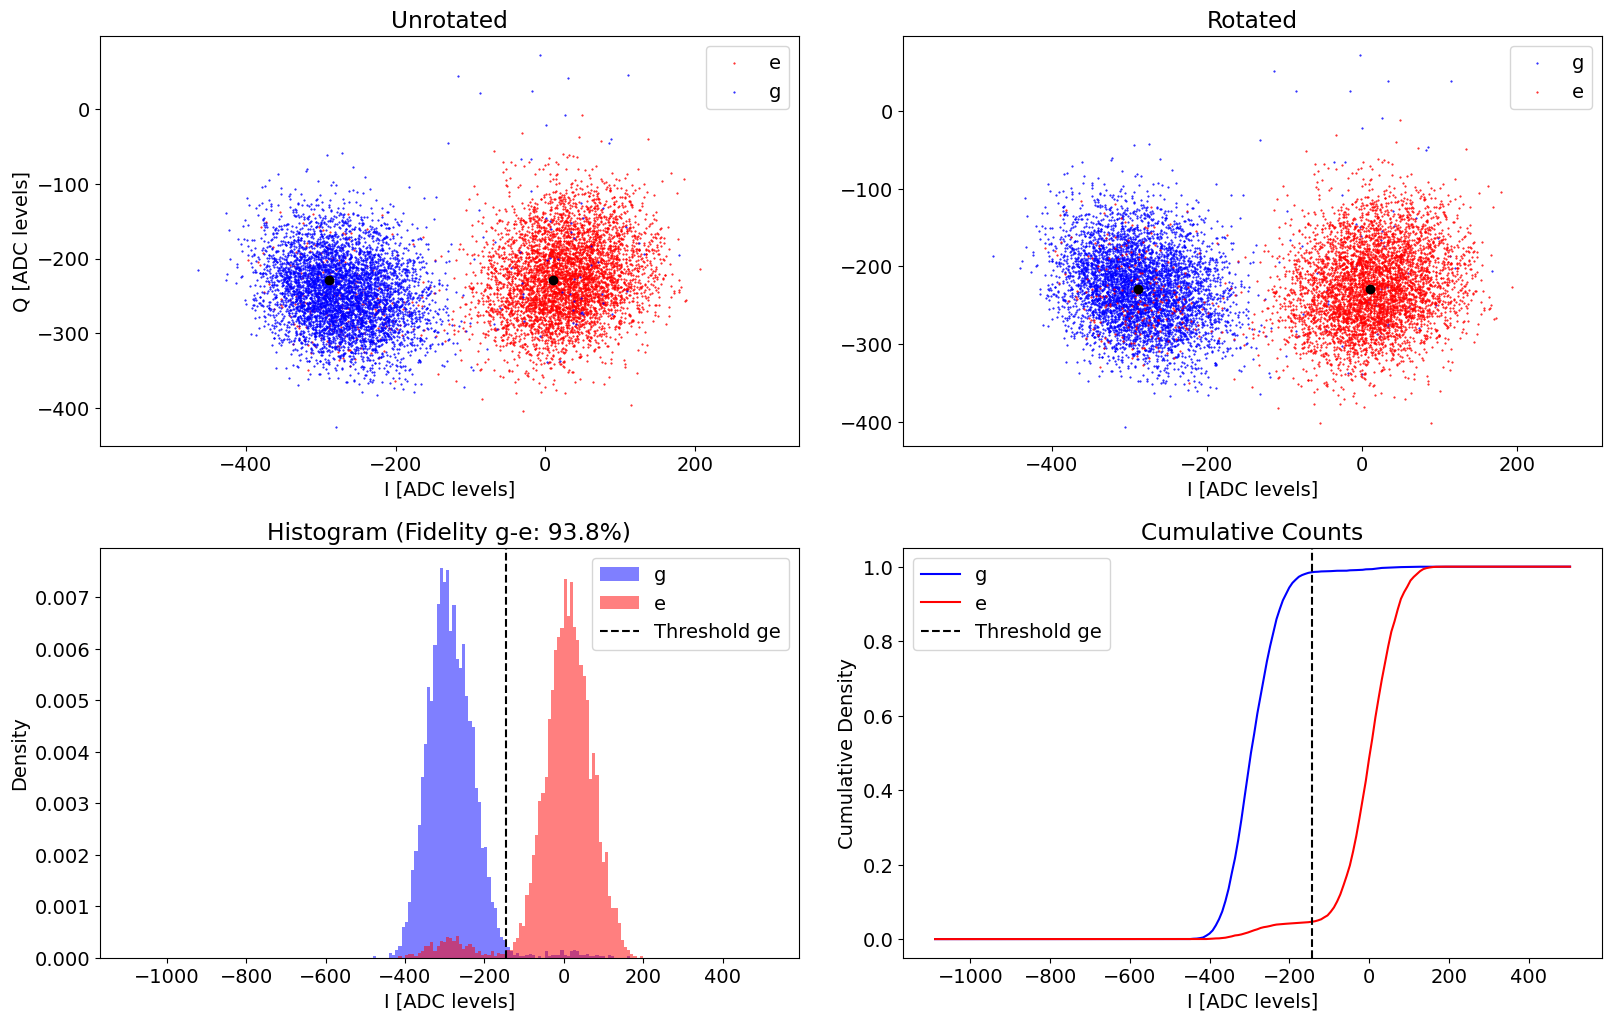

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-26_16-58-58_histogram.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-26.md
Updated readout!
Single shot done!


In [278]:
if expts_to_run['single_shot']:
    update_single_shot(hstgrm, config_thisrun)
    print('Single shot done!')

In [31]:
hstgrm.data

{'Ig': array([ -76.46103896,  -69.50649351,   23.67532468, ..., -107.75649351,
          30.20454545,    8.83116883]),
 'Qg': array([-358.29545455, -461.80194805, -352.8961039 , ..., -445.3961039 ,
        -420.82142857, -258.27597403]),
 'Ie': array([123.56818182,  98.56168831, 201.97727273, ..., 148.05519481,
        177.88961039, 206.03571429]),
 'Qe': array([-276.29220779, -151.29545455,  -68.77597403, ..., -184.84415584,
         -66.31818182, -234.46753247]),
 'Ig_rot': array([-327.82937769, -404.43077015, -261.18775057, ..., -415.44528101,
        -310.23171708, -196.45297313]),
 'Qg_rot': array([-163.55372924, -233.51219245, -238.48928718, ..., -193.37623883,
        -285.9357813 , -167.90085661]),
 'Ie_rot': array([-139.01980712,  -56.86680746,   72.12268203, ...,  -52.24848651,
          59.02958867,  -54.90934494]),
 'Qe_rot': array([-268.84934977, -171.37936626, -200.80655377, ..., -230.99306984,
        -180.43924846, -307.26324737])}

## Qubit ge

### Pulse-probe

In [32]:
def do_pulse_probe_ge(config_thisrun): 

    qspec = meas.single_qubit.pulse_probe_spectroscopy.PulseProbeSpectroscopyExperiment(
        soccfg=soc, path=expt_path, prefix='PulseProbeSpectroscopyExperiment', config_file=config_path
    )

    qspec.cfg = AttrDict(deepcopy(config_thisrun))

    qspec.cfg.expt = dict(
        start=3560,  # [MHz]
        step=0.1,  # min step ~1 MHz
        expts=200,  # Number of experiments stepping from start
        reps=2000,  # Number of averages per point
        rounds=1,  # Number of start to finish sweeps to average over
        length=1,  # Qubit probe constant pulse length [us]
        gain=400,  # Qubit pulse gain
        sigma=0.1,  # Qubit flat top sigma
        pulse_type='gaussian',
        wait_qubit=False,
        qubit=0,
        cavity_drive=False,
        cavity_name=0,  # 0 is man1, 1 is man2
        cavity_gain=4000,
        cavity_length=1,  # Constant pulses of cavity [us]
        cavity_pulse=[False, 0.1]  # Truth value for gaussian cavity pulse, type, sigma
    )


    qspec.cfg.device.readout.relax_delay = [50] # Wait time between experiments [us]
    qspec.go(analyze=True, display=True, progress=True, save=True)

def update_pulse_probe_ge(qspec, config_thisrun):
    config_thisrun.device.qubit.f_ge = [qspec.data['fit'][0]]
    print('Updated qubit frequency!')

In [33]:
if expts_to_run['pulse_probe_ge']: 
    qspec = do_pulse_probe_ge(config_thisrun)

In [34]:
if expts_to_run['pulse_probe_ge']:
    update_pulse_probe_ge(qspec, config_thisrun)
    print('Pulse probe spectroscopy done!')

### T2 Ramsey

In [172]:
def do_t2_ramsey_ge(config_thisrun, expt_path, config_path, 
                    pre_sweep_pulse = None, post_sweep_pulse = None, step_size = 0.2, if_ef = False, ef_init = True):
    """Run the T2 Ramsey experiment."""
    t2ramsey = meas.single_qubit.t2_ramsey.RamseyExperiment(
        soccfg=soc, path=expt_path, prefix='RamseyExperiment', config_file=config_path
    )

    t2ramsey.cfg = AttrDict(deepcopy(config_thisrun))
    checkEF = False
    qubit_ge_init = False
    qubit_ge_after = False
    if if_ef:
        checkEF = True
        qubit_ge_init = True if ef_init else False
        qubit_ge_after = True if ef_init else False
        


    t2ramsey.cfg.expt = {
        'start': 0.01,
        'step': step_size,
        'expts': 100,
        'ramsey_freq': 0.2,
        'reps': 200,
        'rounds': 1,
        'qubits': [0],
        'checkEF': checkEF,
        'user_defined_freq': [False, 3568.2038290468167, 5304, 0.035],
        'qubit_ge_init': qubit_ge_init,
        'qubit_ge_after': qubit_ge_after,
        'f0g1_cavity': 0,
        'normalize': False,
        'active_reset': False,
        'man_reset': False,
        'storage_reset': False,
        'prepulse': False if pre_sweep_pulse is None else True,
        'postpulse': False if post_sweep_pulse is None else True,
        'pre_active_reset_pulse': False,
        'pre_sweep_pulse': pre_sweep_pulse,
        'post_sweep_pulse': post_sweep_pulse,
        'advance_phase': 0,
        'echoes': [False, 0]
    }

    t2ramsey.cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]
    t2ramsey.go(analyze=False, display=False, progress=True, save=True)

    from multimode_expts.fit_display_classes import RamseyFitting
    t2ramsey_analysis = RamseyFitting(
        t2ramsey.data, 
        readout_per_round=4, config=t2ramsey.cfg,
    )
    return t2ramsey_analysis


def update_t2_ramsey_ge(t2ramsey, config_thisrun):
    """Update the configuration based on T2 Ramsey experiment results."""
    config_thisrun.device.qubit.f_ge = [config_thisrun.device.qubit.f_ge[0] + min(t2ramsey.data['f_adjust_ramsey_avgi'])]
    print('Updated qubit ge frequency to:', config_thisrun.device.qubit.f_ge[0])



In [ ]:
config_thisrun

In [187]:
t2ramsey_ge = None
if expts_to_run['t2_ge']:
    t2ramsey_ge = do_t2_ramsey_ge(config_thisrun, expt_path, config_path)
    t2ramsey_ge.analyze()
    t2ramsey_ge.display(title_str='T2_ge')
    update_t2_ramsey_ge(t2ramsey_ge, config_thisrun)
    print('T2 Ramsey done!')

fge is  3569.251799855827
fef is  3426.287416084909


  0%|          | 0/20000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00031_RamseyExperiment.h5
Attempted to init fitparam 4 to -139.65257608553063, which is out of bounds -219.22875 to -185.55459415584414. Instead init to -202.39167207792207
Attempted to init fitparam 4 to -202.39167207792207, which is out of bounds 185.77500775526985 to 350.76131576937155. Instead init to 268.2681617623207
Current pi pulse frequency: 3569.251799855827
Fit frequency from I [MHz]: 0.200189080917887 +/- 0.0014510294209852071
Suggested new pi pulse frequency from fit I [MHz]:
 	3569.251610774909
 	3569.6519889367446
T2 Ramsey from fit I [us]: 34.182880608680236
Fit frequency from Q [MHz]: 0.19957625941165139 +/- 0.009787303658808769
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3569.252223596415
 	3569.6513761152387
T2 Ramsey from fit Q [us]: 7.363290285601155


supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-26_11-06-31_T2_ge.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-26.md
Updated qubit ge frequency to: 3569.251610774909
T2 Ramsey done!


In [182]:
t2ramsey_ge.cfg

{'device': {'qubit': {'T1': [370.2930190133963],
   'f_ge': [3569.268703246875],
   'f_ef': [3426.287416084909],
   'ramp_sigma': [0.005],
   'ramp_sigma_num': [3.0],
   'pulses': {'pi_ge': {'gain': [11165],
     'sigma': [0.035],
     'length': [0.0],
     'type': ['gauss']},
    'hpi_ge': {'gain': [5289],
     'length': [0.0],
     'sigma': [0.035],
     'type': ['gauss']},
    'pi_ef': {'gain': [8590],
     'length': [0.0],
     'sigma': [0.035],
     'type': ['gauss']},
    'hpi_ef': {'gain': [4060], 'sigma': [0.035], 'type': ['gauss']}},
   'T1_ef': [167.5647128005103]},
  'readout': {'trig_offset': [450],
   'frequency': [748.8],
   'gain': [800],
   'phase': [173.61636552679084],
   'threshold': [-144.0901885932094],
   'threshold_list': [[-144.0901885932094]],
   'man1_drive_list': [0.0],
   'man2_drive_list': [0.0],
   'readout_length': [1],
   'relax_delay': [2500],
   'confusion_matrix_with_reset': [0.9964530022802125,
    0.0035469977197875036,
    0.013768302080657598,
   

In [44]:
soc.deg2reg(100, gen_ch = 3)

1193046471

In [113]:
config_thisrun.device.qubit.f_ge[0]

3569.419196540533

In [125]:
t2ramsey_ge.data['idata'].shape

(10000,)

### Amplitude Rabi

We should probably use a cosine fit with fixed phase=0 instead of decaying sine with varying phase?

In [59]:
def do_amplitude_rabi(config_thisrun, expt_path, config_path, if_ef = False):
    """Run the amplitude Rabi experiment."""
    amprabi = meas.single_qubit.amplitude_rabi.AmplitudeRabiExperiment(
        soccfg=soc, path=expt_path, prefix='AmplitudeRabiExperiment', config_file=config_path
    )

    amprabi.cfg = AttrDict(deepcopy(config_thisrun))

    pulse_ge = config_thisrun.device.qubit.pulses.pi_ge

    checkEF = False
    pulse_ge_init = False
    pulse_ge_after = False
    if if_ef:
        checkEF = True
        pulse_ge_init = True
        pulse_ge_init = True

    amprabi.cfg.expt = dict(
        start=50,  # Qubit gain [dac level]
        step=160,  # [dac level]
        expts=151,
        reps=100,
        rounds=1,
        sigma_test=pulse_ge.sigma[0],  # Gaussian sigma for pulse length - overrides config [us]
        qubit=0,
        pulse_type='gauss',  # 'gauss' or 'flat_top' or 'drag' or 'const'
        drag_beta=0.0,
        pulse_ge_init=pulse_ge_init,
        pulse_ge_after=pulse_ge_init,
        checkZZ=False,
        checkEF=checkEF,
        qubits=[0],
        flat_length=0,
        normalize=False,
        single_shot=False,  # For debugging
        singleshot_reps=10000,
        span=50,  # Single shot plot span
        user_defined_freq=[False, 3568.203829046816],  # [on/off, freq]
        prepulse=False,
        postpulse=False
    )

    amprabi.cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]
    amprabi.go(analyze=False, display=False, progress=True, save=True)

    from multimode_expts.fit_display_classes import AmplitudeRabiFitting
    amprabi_analysis = AmplitudeRabiFitting(
        amprabi.data, 
        readout_per_round=4, config=amprabi.cfg,
    )
    return amprabi_analysis


def update_amplitude_rabi(amprabi, config_thisrun):
    """Update the configuration based on amplitude Rabi experiment results."""
    config_thisrun.device.qubit.pulses.pi_ge.gain = [amprabi.data['pi_gain_avgi']]
    config_thisrun.device.qubit.pulses.hpi_ge.gain = [amprabi.data['hpi_gain_avgi']]
    print('Updated qubit ge pi and hpi gaussian gain!')



In [ ]:
# amprabi = do_amplitude_rabi(config_thisrun, expt_path, config_path)

Readout phase: 173.61636552679084


  0%|          | 0/15100 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00006_AmplitudeRabiExperiment.h5


Attempted to init fitparam 4 to -127.93983203463203, which is out of bounds -226.20561688311687 to -195.86866883116883. Instead init to -211.03714285714284
Attempted to init fitparam 4 to -211.03714285714284, which is out of bounds 198.20699461805637 to 355.3161074709325. Instead init to 276.7615510444944
Pi gain from avgi data [dac units]: 11204
	Pi/2 gain from avgi data [dac units]: 5298
Pi gain from avgq data [dac units]: 60785
	Pi/2 gain from avgq data [dac units]: 1185


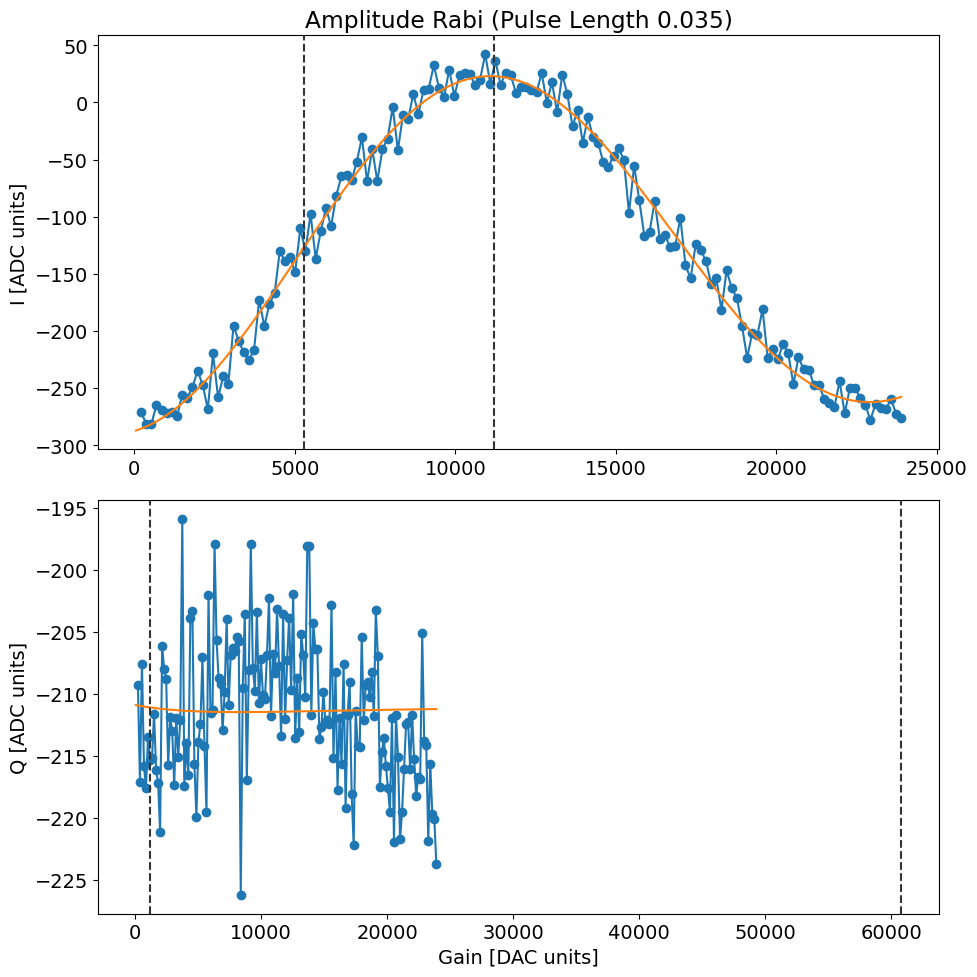

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-26_11-05-20_Amplitude_Rabi_ge.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-26.md
Updated qubit ge pi and hpi gaussian gain!


In [ ]:
# amprabi.analyze(fitparams=[np.max(amprabi.data['amps']), 0.00001, 90, None, None, None])
# amprabi.display(title_str='Amplitude Rabi_ge', save_fig=True)
# update_amplitude_rabi(amprabi, config_thisrun)

In [ ]:
amprabi = None
t2_ramsey_ge_after_amp = None
if expts_to_run['amplitude_ge']:
    amprabi = do_amplitude_rabi(config_thisrun, expt_path, config_path)
    amprabi.analyze(fitparams=[np.max(amprabi.data['amps']), 0.00001, 90, None, None, None])
    amprabi.display(title_str='Amplitude Rabi_ge', save_fig=True)
    update_amplitude_rabi(amprabi, config_thisrun)
    print('Amplitude Rabi done!')

    # After this do another round of T2 to fine tune the qubit frequency
    t2_ramsey_ge_after_amp  = do_t2_ramsey_ge(config_thisrun, expt_path, config_path)
    t2_ramsey_ge_after_amp.analyze()
    t2_ramsey_ge_after_amp.display(title_str='T2_ge_after_amp')
    update_t2_ramsey_ge(t2_ramsey_ge_after_amp , config_thisrun)
    print('T2 Ramsey done!')

Attempted to init fitparam 4 to -127.55463852813851, which is out of bounds -229.83922077922077 to -196.5414935064935. Instead init to -213.19035714285712
Attempted to init fitparam 4 to -213.19035714285712, which is out of bounds 197.8692579923992 to 359.3909089996301. Instead init to 278.63008349601466
Pi gain from avgi data [dac units]: 11165
	Pi/2 gain from avgi data [dac units]: 5289
Pi gain from avgq data [dac units]: 165470
	Pi/2 gain from avgq data [dac units]: 105870


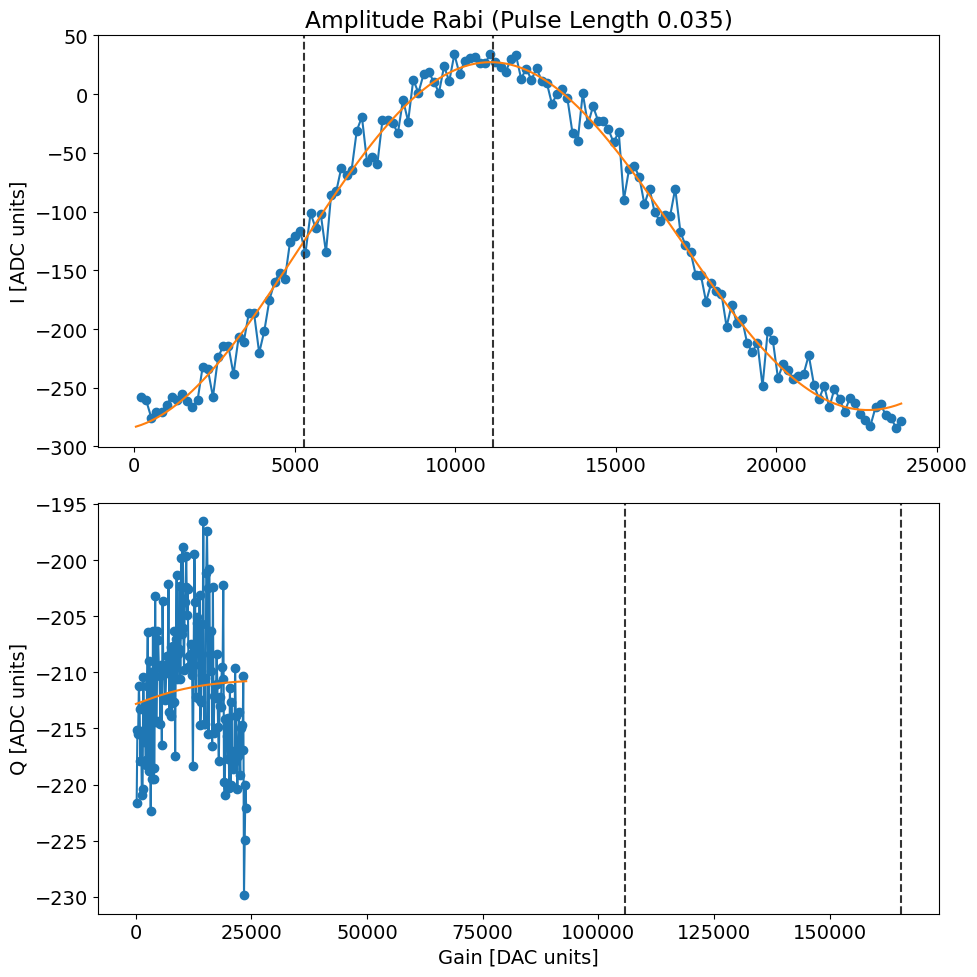

Updated qubit ge pi and hpi gaussian gain!
Amplitude Rabi done!


In [ ]:
# amprabi.analyze(fitparams= [np.max(amprabi.data['amps']), 0.00001, 90, None, None, None])
# amprabi.display()
# update_amplitude_rabi(amprabi, config_thisrun)
# print('Amplitude Rabi done!')

In [ ]:
# amprabi.analyze(fitparams= [np.max(amprabi.data['amps']), 0.0001, 90, None, None, None])
# amprabi.display()
# update_amplitude_rabi(amprabi, config_thisrun)


# Magic Params: [np.max(amprabi.data['amps']), 0.00001, 90, None, None, None]

### T1

In [41]:
def do_t1_ge(config_thisrun, expt_path, config_path):
    """Run the T1 experiment."""
    t1 = meas.single_qubit.t1.T1Experiment(
        soccfg=soc, path=expt_path, prefix='T1Experiment', config_file=config_path
    )

    t1.cfg = AttrDict(deepcopy(config_thisrun))

    t1.cfg.expt = {
        'start': 0,
        'step': 10,
        'expts': 100,
        'reps': 50,
        'rounds': 1,
        'qubit': 0,
        'qubit_ef': False,
        'normalize': False
    }

    t1.cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]
    t1.go(analyze=True, display=True, progress=True, save=True)
    return t1


def update_t1_ge(t1, config_thisrun):
    """Update the configuration based on T1 experiment results."""
    config_thisrun.device.qubit.T1 = [t1.data['fit_avgi'][3]]
    print('Updated qubit T1!')


In [42]:
t1 = None
if expts_to_run['t1_ge']:
    t1 = do_t1_ge(config_thisrun, expt_path, config_path)
    t1.analyze()
    t1.display()
    update_t1_ge(t1, config_thisrun)
    print('T1 done!')

## Qubit ef

### Pulse-probe

In [43]:
def do_pulse_probe_ef(config_thisrun): 

    qspec = meas.single_qubit.pulse_probe_spectroscopy.PulseProbeSpectroscopyExperiment(
        soccfg=soc, path=expt_path, prefix='PulseProbeEFSpectroscopyExperiment', config_file=config_path
    )

    qspec.cfg = AttrDict(deepcopy(config_thisrun))

    qspec.cfg.expt = {'start': 3415,
        'step': 0.05,
        'expts': 500,
        'reps': 200,
        'rounds': 1,
        'length': 2,
        'gain': 3000,
        'pulse_type': 'gaussian',
        'qubit_f': True,
        'qubit': 0}



    qspec.cfg.device.readout.relax_delay = [50] # Wait time between experiments [us]
    qspec.go(analyze=True, display=True, progress=True, save=True)

def update_pulse_probe_ef(qspec, config_thisrun):
    config_thisrun.device.qubit.f_ef = [qspec.data['fit'][0]]
    print('Updated qubit frequency!')

In [44]:
qspec_ef = None
if expts_to_run['pulse_probe_ef']: 
    qspec_ef = do_pulse_probe_ef(config_thisrun)


In [45]:
if expts_to_run['pulse_probe_ef']:
    update_pulse_probe_ef(qspec_ef, config_thisrun)
    print('Pulse probe spectroscopy done!')

### T2 Ramsey

In [72]:
def do_t2_ramsey_ef(config_thisrun, expt_path, config_path, ef_init = True, pre_sweep_pulse = None, post_sweep_pulse = None, step_size = 0.2):
    """Run the T2 Ramsey experiment."""
    return do_t2_ramsey_ge(config_thisrun, expt_path, config_path, pre_sweep_pulse=pre_sweep_pulse, 
                            post_sweep_pulse=post_sweep_pulse, step_size=step_size, if_ef=True, ef_init=ef_init)
    


def update_t2_ramsey_ef(t2ramsey, config_thisrun):
    """Update the configuration based on T2 Ramsey experiment results."""
    config_thisrun.device.qubit.f_ef = [config_thisrun.device.qubit.f_ef[0] + min(t2ramsey.data['f_adjust_ramsey_avgi'])]
    print('Updated qubit ef frequency to:', config_thisrun.device.qubit.f_ef[0])



fge is  3569.4263053206314
fef is  3426.3000465435616


  0%|          | 0/20000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00016_RamseyExperiment.h5
Attempted to init fitparam 4 to -109.18105880230881, which is out of bounds 54.16428396346272 to 346.3144413572134. Instead init to 200.23936266033806
Current pi pulse frequency: 3426.3000465435616
Fit frequency from I [MHz]: 0.2106402089048845 +/- 0.00031650418419079185
Suggested new pi pulse frequency from fit I [MHz]:
 	3426.2894063346566
 	3426.7106867524667
T2 Ramsey from fit I [us]: 98.61189979868541
Fit frequency from Q [MHz]: 0.21065506026998077 +/- 0.00038071800508996214
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3426.2893914832916
 	3426.7107016038317
T2 Ramsey from fit Q [us]: 96.74182990374062


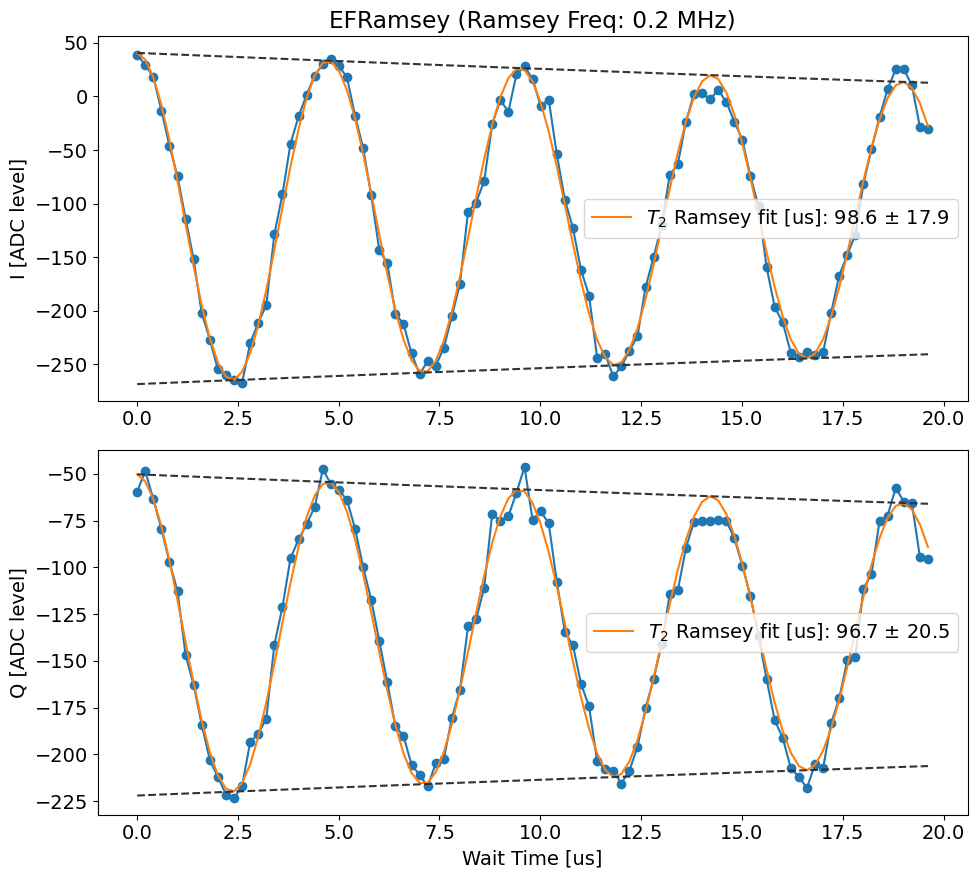

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-25_10-22-34_T2_ef.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-25.md
Updated qubit ef frequency to: 3426.2894063346566
T2 Ramsey done!


In [48]:
t2ramsey_ef = None
if expts_to_run['t2_ef']:
    t2ramsey_ef = do_t2_ramsey_ef(config_thisrun, expt_path, config_path)
    t2ramsey_ef.analyze()
    t2ramsey_ef.display(title_str='T2_ef')
    update_t2_ramsey_ef(t2ramsey_ef, config_thisrun)
    print('T2 Ramsey done!')

In [48]:
# t2ramsey_ge.analyze()
# t2ramsey_ge.display()
    

### Amplitude Rabi

We should probably use a cosine fit with fixed phase=0 instead of decaying sine with varying phase?

In [56]:
def do_amplitude_rabi_ef(config_thisrun, expt_path, config_path):
    """Run the amplitude Rabi experiment."""
    return do_amplitude_rabi(config_thisrun, expt_path, config_path, if_ef=True)


def update_amplitude_rabi_ef(amprabi, config_thisrun):
    """Update the configuration based on amplitude Rabi experiment results."""
    config_thisrun.device.qubit.pulses.pi_ef.gain = [amprabi.data['pi_gain_avgi']]
    config_thisrun.device.qubit.pulses.hpi_ef.gain = [amprabi.data['hpi_gain_avgi']]
    print('Updated qubit ef pi and hpi gaussian gain!')



In [57]:
expts_to_run['amplitude_ef'] = True

Readout phase: 0.8473846167680859


  0%|          | 0/15100 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00005_AmplitudeRabiExperiment.h5
Attempted to init fitparam 4 to -134.11095606060607, which is out of bounds 55.93664430219787 to 351.78727471984746. Instead init to 203.86195951102266
Pi gain from avgi data [dac units]: 8590
	Pi/2 gain from avgi data [dac units]: 4060
Pi gain from avgq data [dac units]: 163923
	Pi/2 gain from avgq data [dac units]: 104323


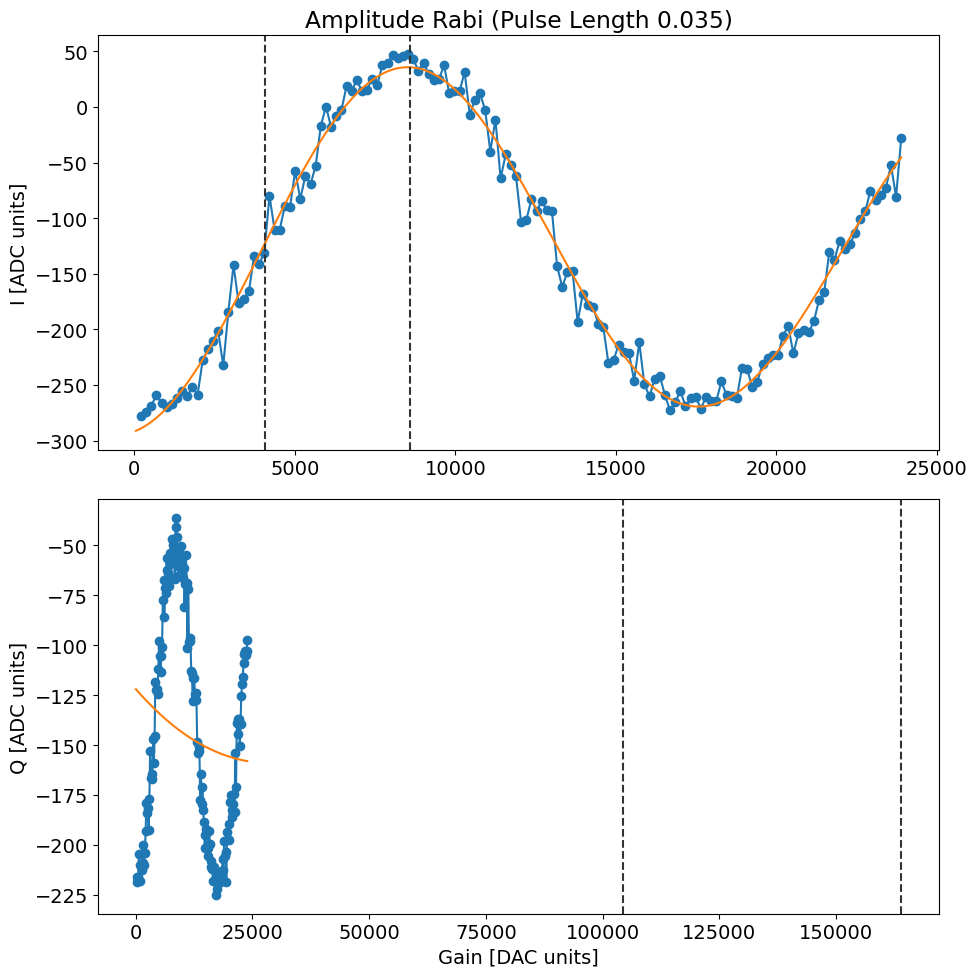

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-25_10-40-38_Amplitude_Rabi_ef.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-25.md
Updated qubit ef pi and hpi gaussian gain!
Amplitude Rabi done!
fge is  3569.4263053206314
fef is  3426.2894063346566


  0%|          | 0/20000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00017_RamseyExperiment.h5
Attempted to init fitparam 4 to -114.45409287682013, which is out of bounds 56.44285463064291 to 344.79813533024236. Instead init to 200.62049498044263
Current pi pulse frequency: 3426.2894063346566
Fit frequency from I [MHz]: 0.20199024974740315 +/- 0.0005093400906513863
Suggested new pi pulse frequency from fit I [MHz]:
 	3426.287416084909
 	3426.691396584404
T2 Ramsey from fit I [us]: 53.88318119011672
Fit frequency from Q [MHz]: 0.201855730747958 +/- 0.0005668545847969206
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3426.2875506039086
 	3426.6912620654048
T2 Ramsey from fit Q [us]: 46.099574808057646


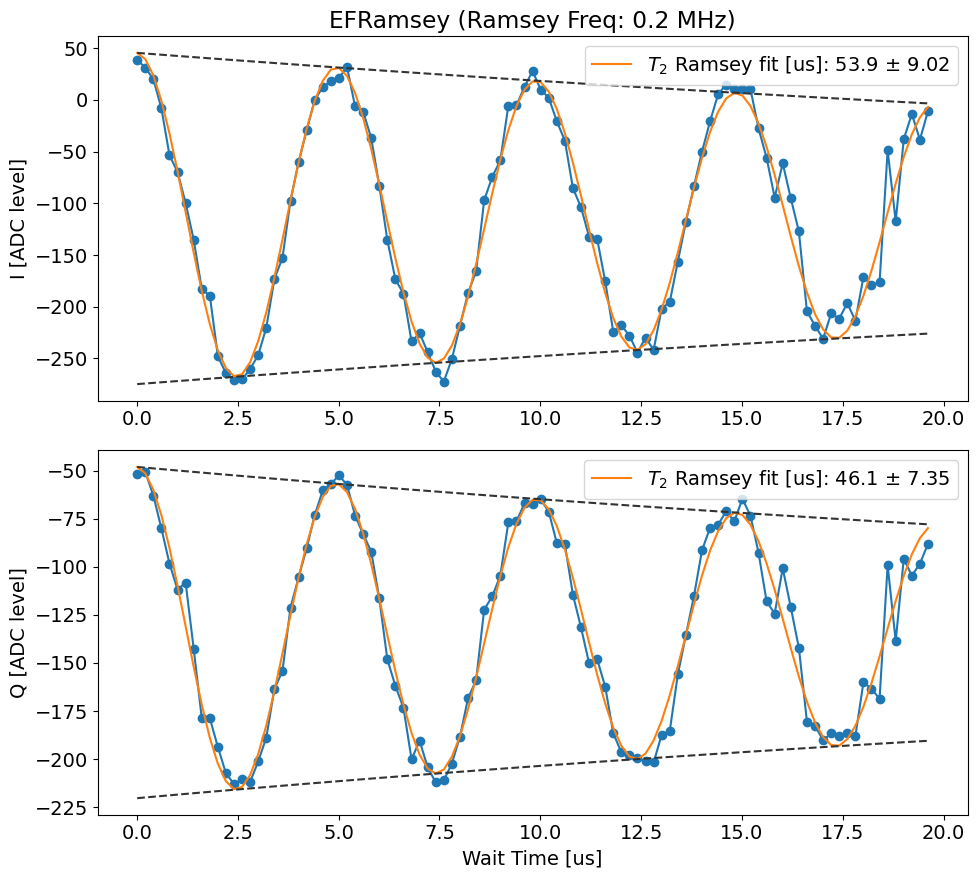

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-25_10-41-34_T2_ef_after_amp.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-25.md
Updated qubit ef frequency to: 3426.287416084909
T2 Ramsey done!


In [69]:
amprabi_ef = None
t2_ramsey_ef_after_amp = None
if expts_to_run['amplitude_ef']:
    amprabi_ef = do_amplitude_rabi_ef(config_thisrun, expt_path, config_path)
    amprabi_ef.analyze(fitparams=[np.max(amprabi_ef.data['amps']), 0.00001, 90, None, None, None])
    amprabi_ef.display(title_str = 'Amplitude Rabi_ef', save_fig=True)
    update_amplitude_rabi_ef(amprabi_ef, config_thisrun)
    print('Amplitude Rabi done!')

    # After this do another round of T2 to fine tune the qubit frequency
    t2_ramsey_ef_after_amp  = do_t2_ramsey_ef(config_thisrun, expt_path, config_path)
    t2_ramsey_ef_after_amp.analyze()
    t2_ramsey_ef_after_amp.display(title_str='T2_ef_after_amp')
    update_t2_ramsey_ef(t2_ramsey_ef_after_amp , config_thisrun)
    print('T2 Ramsey done!')

Attempted to init fitparam 4 to -130.64287164502167, which is out of bounds 46.92366247379537 to 353.0374822692438. Instead init to 199.9805723715196
Pi gain from avgi data [dac units]: 8475
	Pi/2 gain from avgi data [dac units]: 3922
Pi gain from avgq data [dac units]: 163752
	Pi/2 gain from avgq data [dac units]: 104152


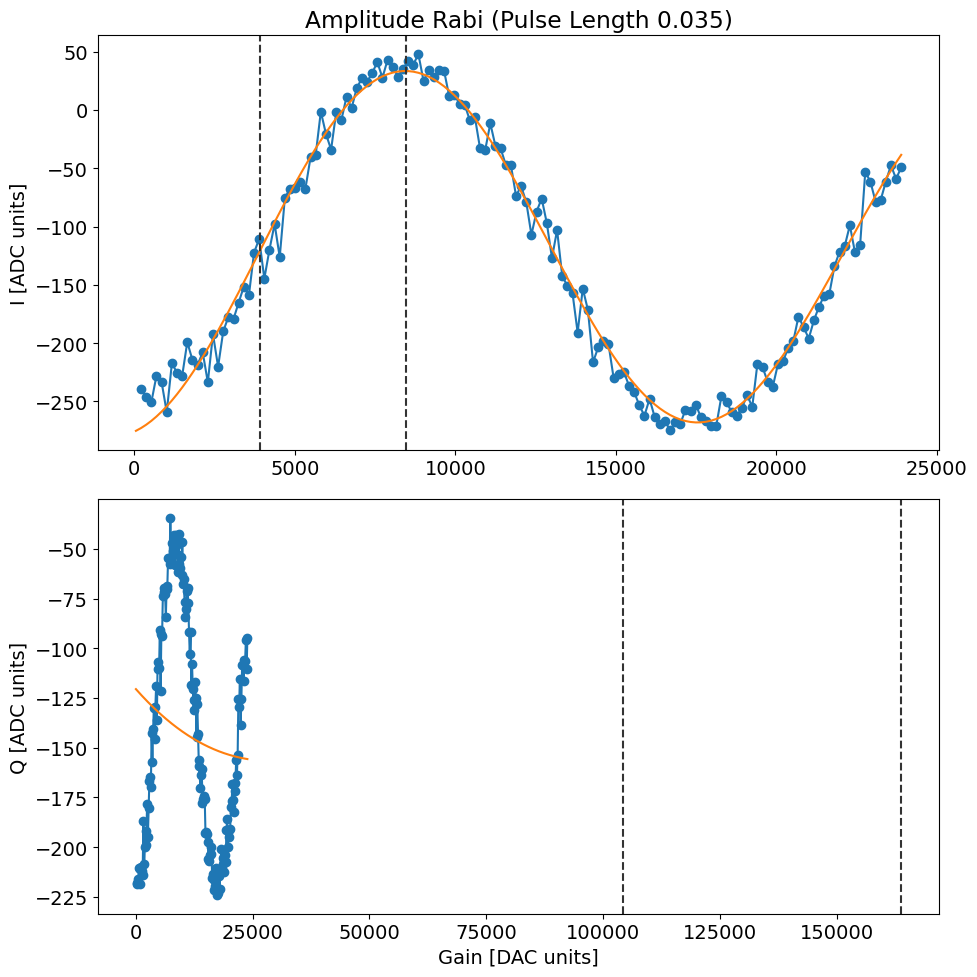

In [68]:
amprabi_ef.analyze(title_str = 'Amplitude Rabi_ef', save_fig=False, fitparams=[np.max(amprabi_ef.data['amps']), 0.00001, 90, None, None, None])
amprabi_ef.display(title_str = 'Amplitude Rabi_ef', save_fig=False)
# Magic Params: [np.max(amprabi_ef.data['amps']), 0.00001, 90, None, None, None]

In [ ]:
# update_amplitude_rabi_ef(amprabi_ef, config_thisrun)
# print('Amplitude Rabi done!')

# After this do another round of T2 to fine tune the qubit frequency
# t2_ramsey_ef_after_amp  = do_t2_ramsey_ef(config_thisrun, expt_path, config_path)
# t2_ramsey_ef_after_amp.analyze()
# t2_ramsey_ef_after_amp.display(title_str='T2_ef_after_amp')
# update_t2_ramsey_ef(t2_ramsey_ef_after_amp , config_thisrun)
# print('T2 Ramsey done!')

fge is  3569.4198176358545
fef is  3426.3181805352324


  0%|          | 0/20000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00011_RamseyExperiment.h5
Attempted to init fitparam 4 to -117.69186770300406, which is out of bounds 57.8644317424725 to 346.2564709215713. Instead init to 202.0604513320219
Current pi pulse frequency: 3426.3181805352324
Fit frequency from I [MHz]: 0.20177816336002957 +/- 0.00046997561004176805
Suggested new pi pulse frequency from fit I [MHz]:
 	3426.3164023718723
 	3426.7199586985926
T2 Ramsey from fit I [us]: 50.31470850686472
Fit frequency from Q [MHz]: 0.20238194366665718 +/- 0.0005600947913224493
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3426.315798591566
 	3426.720562478899
T2 Ramsey from fit Q [us]: 60.757146958568825


supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-22_11-13-45_T2_ef_after_amp.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-22.md
Updated qubit ge frequency to: 3426.3164023718723
T2 Ramsey done!


In [ ]:
# t2_ramsey_ef_after_amp.analyze(fitparams=[300, None, None, None, None, None])
# t2_ramsey_ef_after_amp.display(title_str='T2_ef_after_amp')
# update_t2_ramsey_ef(t2_ramsey_ef_after_amp , config_thisrun)

Attempted to init fitparam 4 to -116.55440345008529, which is out of bounds 60.73323445408372 to 348.7263250437679. Instead init to 204.7297797489258
Current pi pulse frequency: 3426.3164023718723
Fit frequency from I [MHz]: 0.21882570632979814 +/- 0.0005380744558043492
Suggested new pi pulse frequency from fit I [MHz]:
 	3426.2975766655427
 	3426.735228078202
T2 Ramsey from fit I [us]: 44.81982491598512
Fit frequency from Q [MHz]: 0.21862336100212773 +/- 0.0005909327735314028
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3426.2977790108703
 	3426.7350257328744
T2 Ramsey from fit Q [us]: 36.84019802269955


supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-22_11-17-28_T2_ef_after_amp.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-22.md
Updated qubit ge frequency to: 3426.2975766655427


### T1

In [51]:
def do_t1_ef(config_thisrun, expt_path, config_path):
    """Run the T1 experiment."""
    t1 = meas.single_qubit.t1.T1Experiment(
        soccfg=soc, path=expt_path, prefix='T1Experiment', config_file=config_path
    )

    t1.cfg = AttrDict(deepcopy(config_thisrun))

    t1.cfg.expt = {
        'start': 0,
        'step': 5,
        'expts': 100,
        'reps': 50,
        'rounds': 1,
        'qubit': 0,
        'qubit_ef': True,
        'normalize': False
    }

    t1.cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]
    t1.go(analyze=True, display=True, progress=True, save=True)
    return t1


def update_t1_ef(t1, config_thisrun):
    """Update the configuration based on T1 experiment results."""
    config_thisrun.device.qubit.T1_ef = [t1.data['fit_avgq'][3]]
    print('Updated qubit T1!')


In [52]:
t1_ef = None
if expts_to_run['t1_ef']:
    t1 = do_t1_ef(config_thisrun, expt_path, config_path)
    t1.analyze()
    t1.display()
    update_t1_ef(t1, config_thisrun)
    print('T1 done!')

# Manipulate

## Spectroscopy

In [141]:
def do_pulse_probe_f0g1(config_thisrun, ds_thisrun, man_mode_no = 1): 

    qspec = meas.single_qubit.pulse_probe_f0g1_spectroscopy.PulseProbeF0g1SpectroscopyExperiment(
        soccfg=soc, path=expt_path, prefix='PulseProbeF0g1SpectroscopyExperiment', config_file=config_path
    )

    qspec.cfg = AttrDict(deepcopy(config_thisrun))

    qspec.cfg.expt = {
        'start': ds_thisrun.get_freq('M' + str(man_mode_no)) - 2,  # resonator frequency to be mixed up [MHz]
        'step': 0.02,  # min step ~1 MHz
        'expts': 300,  # Number of experiments stepping from start
        'reps': 100,  # Number of averages per point
        'rounds': 1,  # Number of start to finish sweeps to average over
        'length': 1,  # ef probe constant pulse length [us]
        'gain': 5000,  # f0g1 pulse gain
        'pulse_type': 'gaussian',
        'qubit_f': True,
        'qubits': [0],
        'prepulse': False,
        'pre_sweep_pulse': [[3569.4827896982997], [11161], [0], [0], [2], ['g'], [0.035]]
    }

    qspec.cfg.device.readout.relax_delay = [200] # Wait time between experiments [us]
    qspec.go(analyze=False, display=False, progress=True, save=True)
    return qspec

def analyze_and_display_pulse_probe_f0g1(qspec):
    from multimode_expts.fit_display_classes import Spectroscopy
    spec_analysis = Spectroscopy(
        qspec.data)
    spec_analysis.analyze(fit=True)
    spec_analysis.display()

def update_pulse_probe_f0g1(qspec, config_thisrun, man_mode_no = 1):
    ''' 
    Update the configuration based on f0g1 spectroscopy experiment results.
    man_mode_no: 1 for man1, 2 for man2
    '''
    ds_thisrun.update_freq('M' + str(man_mode_no),  qspec.data['fit_avgi'][2])
    print('Updated man f0g1 freq to :', config_thisrun.device.manipulate.f0g1_freq[man_mode_no - 1])


Running pulse probe f0g1 for mode 1


  0%|          | 0/30000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data\00020_PulseProbeF0g1SpectroscopyExperiment.h5
Found peak in amps at [MHz] 2009.7472506054385, HWHM 0.4379890210255317
Found peak in I at [MHz] 2009.7444473320718, HWHM 0.4389563394135119
Found peak in Q at [MHz] 2009.7538489820745, HWHM 0.4497967415812675


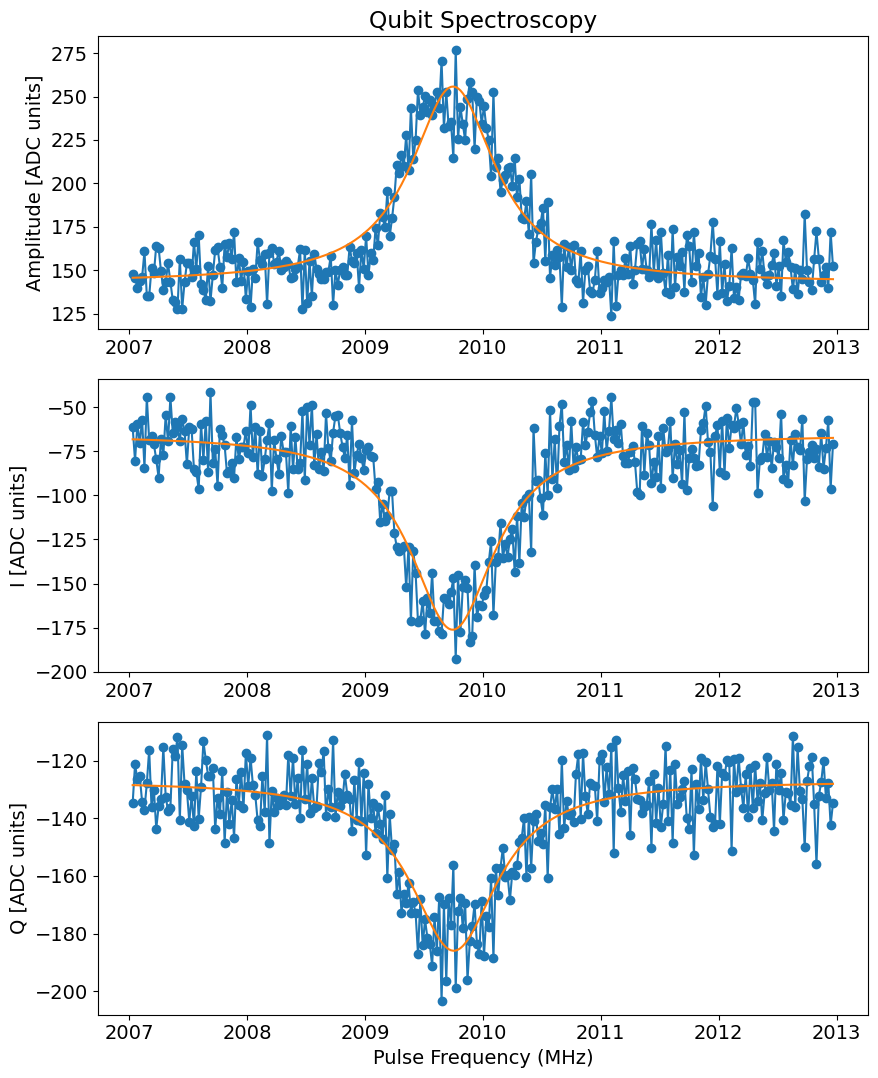

Updated man f0g1 freq to : 2007.09


In [46]:
man_specs =[None]* len(expts_to_run['man_modes'])

for i in range(len(expts_to_run['man_modes'])):

    if expts_to_run['pulse_probe_f0g1']:

        print('Running pulse probe f0g1 for mode', i+1)
        man_specs[i] = do_pulse_probe_f0g1(config_thisrun, ds_thisrun, man_mode_no = i+1)
        analyze_and_display_pulse_probe_f0g1(man_specs[i])
        update_pulse_probe_f0g1(man_specs[i], config_thisrun, man_mode_no=i+1)
        

## Find Frequency (Chevron)


In [47]:
%matplotlib inline

In [142]:
def do_length_rabi_f0g1_sweep(config_thisrun, expt_path, config_path, freq_start, freq_stop, freq_step):
    """Run the Length Rabi General F0g1 Experiment Sweep."""
    # length_rabi = meas.single_qubit.length_rabi.LengthRabiGeneralF0g1ExperimentSweep(
    #     soccfg=soc, path=expt_path, prefix='LengthRabiGeneralF0g1ExperimentSweep', config_file=config_path
    # )
    from multimode_expts.sequential_experiment_classes import man_f0g1_class
    experiment_class = man_f0g1_class
    sweep_experiment_name = 'length_rabi_f0g1_sweep'
    class_for_exp = experiment_class(soccfg=soc, path=expt_path, prefix=sweep_experiment_name, config_file=config_path, exp_param_file=exp_param_file)

    class_for_exp.yaml_cfg = AttrDict(deepcopy(config_thisrun))
    class_for_exp.loaded[sweep_experiment_name] = {
        'freq_start': freq_start,
        'freq_stop':  freq_stop,
        'freq_step': freq_step,
        'start': 30,
        'step': 0.05,
        'qubits': [0],
        'expts': 101,
        'reps': 100,
        'rounds': 1,
        'gain': 15000,
        'ramp_sigma': 0.005,
        'use_arb_waveform': False,
        'pi_ge_before': True,
        'pi_ef_before': True,
        'pi_ge_after': False,
        'normalize': False,
        'active_reset': False,
        'check_man_reset': [False, 0],
        'check_man_reset_pi': [],
        'prepulse': False,
        'pre_sweep_pulse': []
    }
 
    return eval('class_for_exp.run_sweep')( sweep_experiment_name = sweep_experiment_name)

def update_length_rabi_f0g1_sweep(expt_path, prefix, config_thisrun, man_mode_no = 1):
    """Update sweep data and analyze results."""
    temp_data, attrs, filename = prev_data(expt_path, prefix=prefix)
    print('File saved at :', filename)
    from multimode_expts.fit_display_classes import ChevronFitting
    from datetime import datetime
    
    chevron_analysis = ChevronFitting(
        frequencies=temp_data['freq_sweep'],
        time=temp_data['xpts'][0],
        response_matrix=temp_data['avgi']
    )
    chevron_analysis.analyze()
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    chevron_analysis.display_results(save_fig=True, directory=autocalib_path, title=f'M{man_mode_no}_{current_time}')

    #config_thisrun.device.manipulate.f0g1_freq[0] = chevron_analysis.results['frequency']
    ds_thisrun.update_freq('M' + str(man_mode_no), chevron_analysis.results['best_frequency_contrast'])
    print('Updated the frequency to:', chevron_analysis.results['best_frequency_contrast'])
    return chevron_analysis



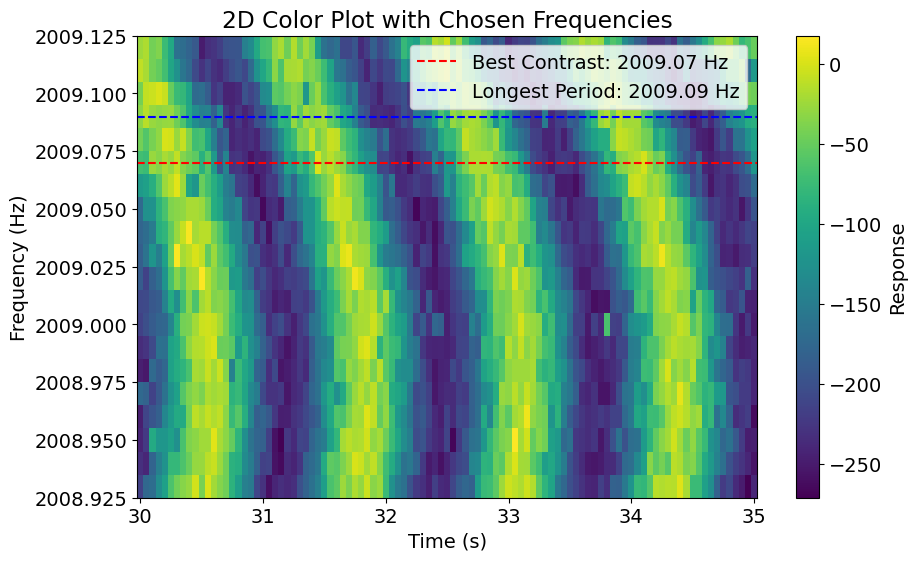

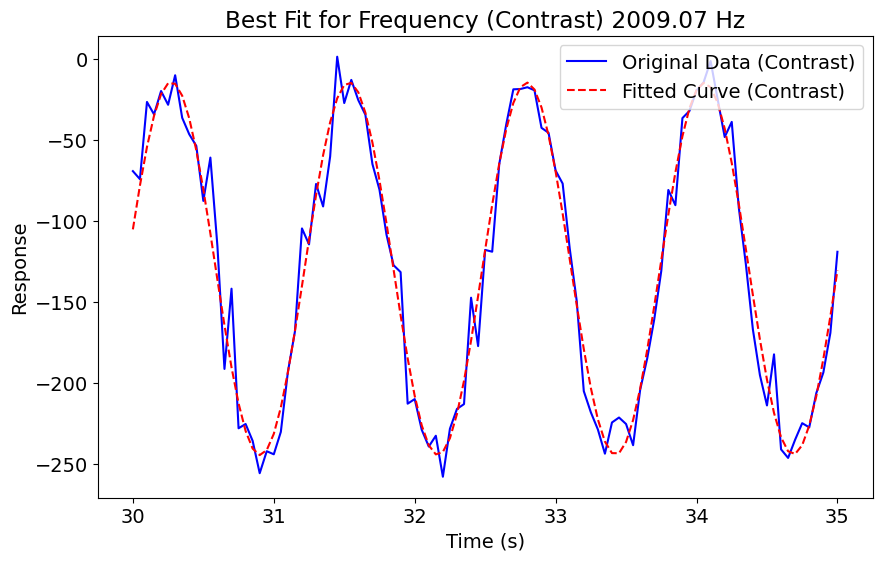

File saved at : H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00000_length_rabi_f0g1_sweep.h5
Figure saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\autocalibration_plots_2025-05-22\M1_2025-05-22_11-32-06


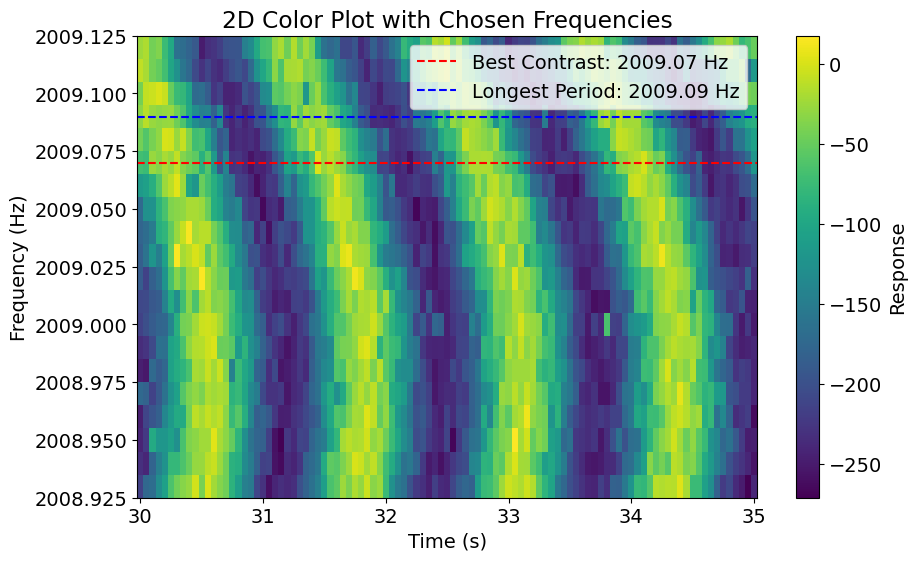

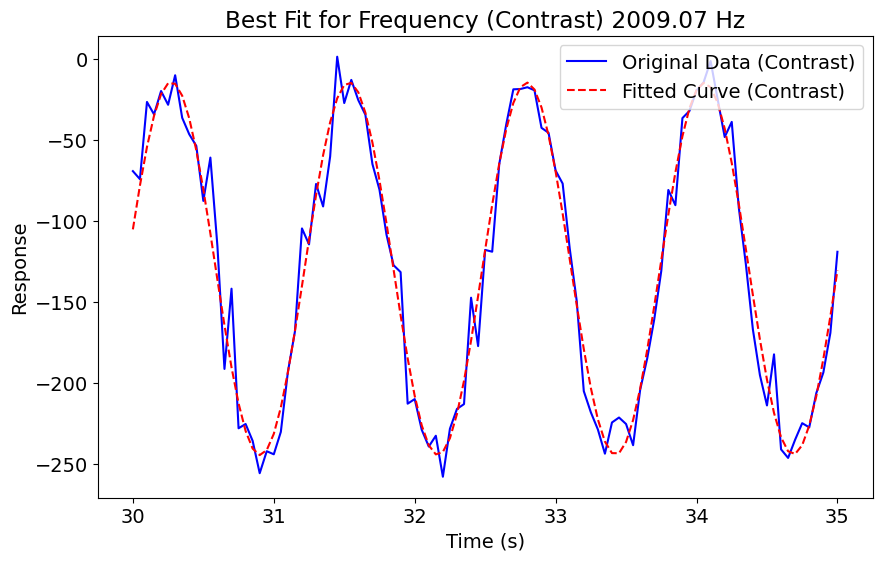

Updated the frequency to: 2009.07


In [ ]:
man_chevrons_coarse = [None] * len(expts_to_run['man_modes'])
man_chevrons_fine = [None] * len(expts_to_run['man_modes'])
# man_sweeps = [None] * len(expts_to_run['man_modes'])

for i in range(len(expts_to_run['man_modes'])):
    if expts_to_run['length_rabi_sweep']:
        print(f'Running coarse length rabi sweep for mode {i + 1}')
        freq_start = ds_thisrun.get_freq('M' + str(i + 1)) - 2
        freq_stop = ds_thisrun.get_freq('M' + str(i + 1)) + 2
        freq_step = 0.2
        man_chevrons_coarse[i] = do_length_rabi_f0g1_sweep(config_thisrun, expt_path, config_path, freq_start, freq_stop, freq_step)
        update_length_rabi_f0g1_sweep(expt_path, 'length_rabi_f0g1_sweep', config_thisrun, man_mode_no=i + 1)

        print(f'Running fine length rabi sweep for mode {i + 1}')
        freq_start = ds_thisrun.get_freq('M' + str(i + 1)) - 0.2
        freq_stop = ds_thisrun.get_freq('M' + str(i + 1)) + 0.2
        freq_step = 0.01
        man_chevrons_fine[i] = do_length_rabi_f0g1_sweep(config_thisrun, expt_path, config_path, freq_start, freq_stop, freq_step)
        update_length_rabi_f0g1_sweep(expt_path, 'length_rabi_f0g1_sweep', config_thisrun, man_mode_no=i + 1)

In [148]:
ds_thisrun.update_freq('M1',  2008.975)

In [114]:
soc.cycles2us(3)

0.006975446428571429

## Length Rabi f0g1 (Update time)

In [ ]:
def do_length_rabi_f0g1_general(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no = 1):
    """Run the Length Rabi General F0g1 Experiment."""
    length_rabi = meas.single_qubit.length_rabi_f0g1_general.LengthRabiGeneralF0g1Experiment(
        soccfg=soc, path=expt_path, prefix='LengthRabiGeneralF0g1Experiment', config_file=config_path
    )

    length_rabi.cfg = AttrDict(deepcopy(config_thisrun))

    length_rabi.cfg.expt = dict(
        start=soc.cycles2us(3),  # Pulse start length [us]
        step=0.04,  # Pulse step length [us]
        qubits=[0],
        expts=100,
        reps=100,
        rounds=1,
        rep_start=0, # 0 means just 1 pi pulse, no error amp
        rep_end=19, # will do 1+2*rep_end rounds of pi pulses max
        gain=15000,  # Qubit gain [DAC units]
        freq= ds_thisrun.get_freq('M' + str(man_mode_no)),  # Frequency [MHz]
        use_arb_waveform=False,
        pi_ge_before=True,
        pi_ef_before=True,
        pi_ef_after=True,
        normalize=False,
        active_reset=False,
        check_man_reset=[False, 0],
        swap_lossy=False,
        check_man_reset_pi=[],
        prepulse=False,
        pre_sweep_pulse=[],
        err_amp_reps = 0, # Number of error amp rounds
    )

    length_rabi.cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]
    length_rabi.go(analyze=False, display=False, progress=True, save=True)

    from multimode_expts.fit_display_classes import LengthRabiFitting
    # Analyze the data
    length_rabi_analysis = LengthRabiFitting(length_rabi.data, config = length_rabi.cfg)
    length_rabi_analysis.analyze()
    length_rabi_analysis.display(title_str='Length Rabi General F0g1')


    return length_rabi_analysis


def update_length_rabi_f0g1_combined(length_rabi, config_thisrun, ds, man_mode_no = 1):
    """Update the configuration and dataset based on Length Rabi General F0g1 experiment results."""

    # Update dataset
    pi_length = length_rabi.results['pi_length']
    pi2_length = length_rabi.results['pi2_length']
    gain = length_rabi.cfg.expt['gain']
    freq = length_rabi.cfg.expt['freq']
    ds.update_all('M' + str(man_mode_no), freq, np.nan, pi_length, pi2_length, gain)
    print(f'Updated dataset: pi_length={pi_length}, pi2_length={pi2_length}, gain={gain}')



Running length rabi for mode 1


  0%|          | 0/100 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00065_LengthRabiGeneralF0g1Experiment.h5
p1: 0.7277650023672517
Pi length: 0.6816880200810652
Pi/2 length: 0.3381705395938095
p1: 0.7505648429570831
Pi length: 0.7194607205079652
Pi/2 length: 0.386378239565949


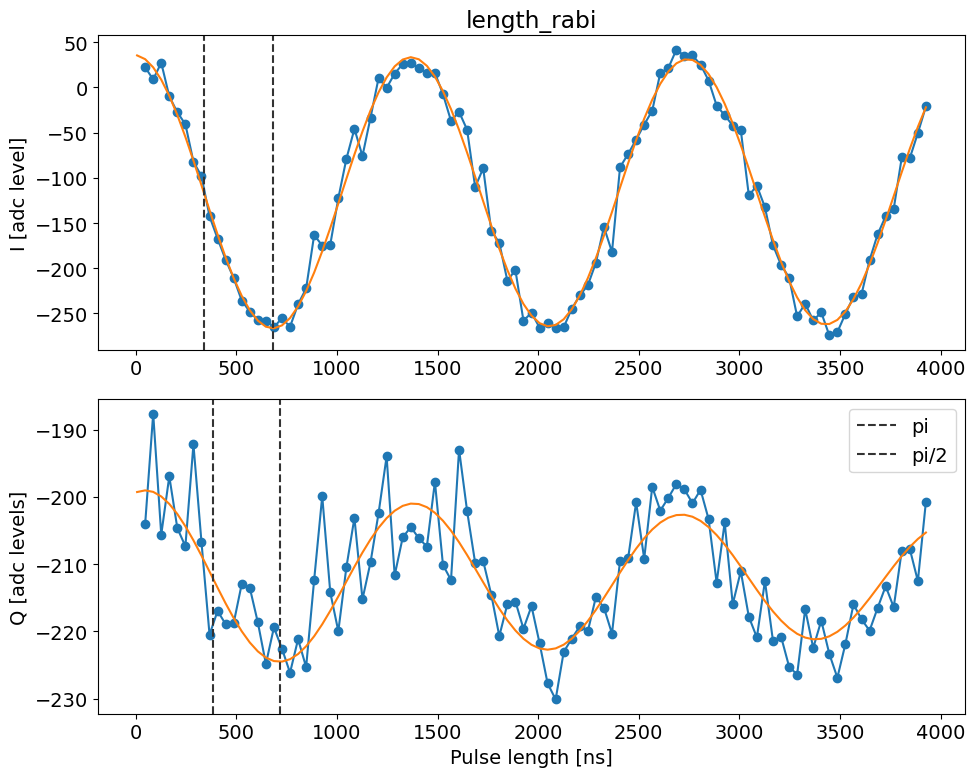

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-23_10-34-03_Length_Rabi_General_F0g1.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-23.md
Updated dataset: pi_length=0.6816880200810652, pi2_length=0.3381705395938095, gain=15000


In [146]:
len_rabis_mans = [None]* len(expts_to_run['man_modes'])
for i in range(len(expts_to_run['man_modes'])):
    if expts_to_run['length_rabi'] or expts_to_run['length_rabi_sweep']:
        print('Running length rabi for mode', i+1)
        len_rabis_mans[i] = do_length_rabi_f0g1_general(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no= i+1)
        update_length_rabi_f0g1_combined(len_rabis_mans[i], config_thisrun, ds_thisrun, man_mode_no= i+1)
        

In [149]:
p1 = 0.7505648429570831
T = 1/p1 # TIME PERIOD
T

1.3323299237680646

p1: 0.7277650023672517
p2: 91.40087392271151
Pi length: 0.6816880200810652
Pi/2 length: 0.3381705395938095
vline: 1338 ns
p1: 0.7505648429570831
p2: 75.59930782733372
Pi length: 0.7194607205079652
Pi/2 length: 0.386378239565949


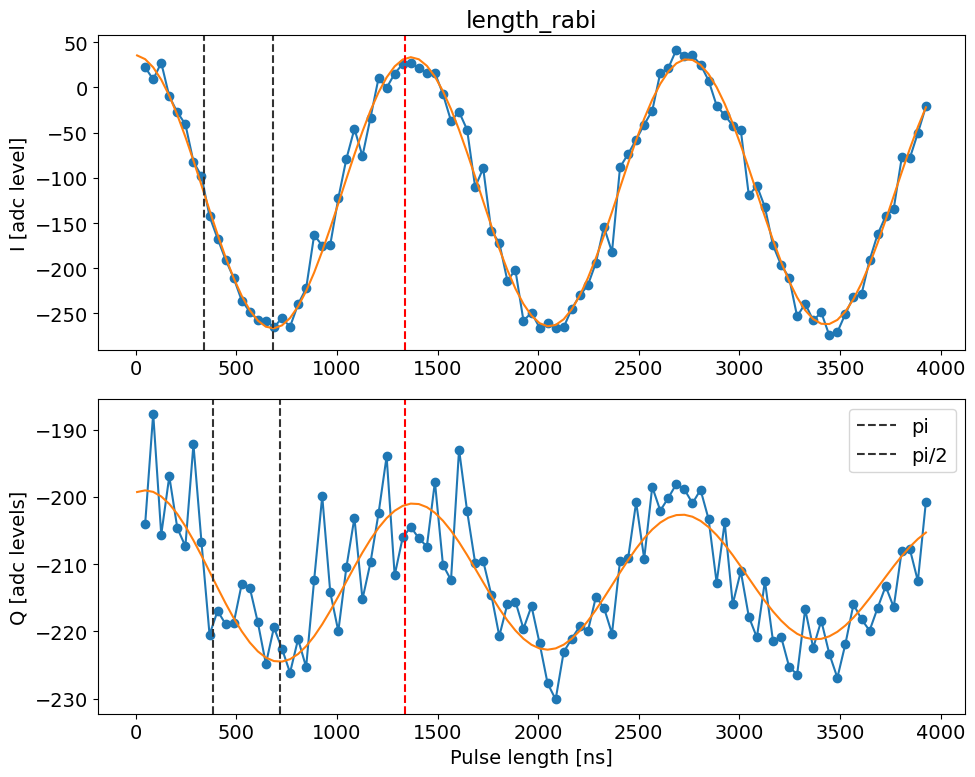

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-23_10-40-44_Length_Rabi_General_F0g1.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-23.md


In [155]:
len_rabis_mans[0].analyze()
len_rabis_mans[0].display(title_str='Length Rabi General F0g1', vlines = [1338])

In [142]:
update_length_rabi_f0g1_combined(len_rabis_mans[i], config_thisrun, ds_thisrun, man_mode_no= i+1)

NameError: name 'length_rabi_analysis' is not defined

In [128]:
soc.us2cycles(0.1)

43

In [ ]:
# adding channel index
soc.us2cycles(0.1, 0)

40

In [22]:
i = 0
update_length_rabi_f0g1_combined(len_rabis_mans[i], config_thisrun, ds_thisrun, man_mode_no= i+1)

Pi length: 0.6336344988370962
Pi/2 length: 0.313482947403078
Pi length: 0.6306209158427425
Pi/2 length: 0.30718246504928653


supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-22_20-52-42_Length_Rabi_General_F0g1.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-22.md
Updated dataset: pi_length=0.6336344988370962, pi2_length=0.313482947403078, gain=15000


### Quick and dirty error amplification

Very slightly modified length rabi f0g1 general (see git)

In [54]:
soc.cycles2us(1)

0.0023251488095238095

In [ ]:
def length_rabi_f0g1_err_amp(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no = 1):
    """Run the Length Rabi General F0g1 repeatedly to amplify error."""

    expt_cfg = dict(
        start=ds_thisrun.get_pi('M1')-soc.cycles2us(1)*50,  # Pulse start length [us]
        step=soc.cycles2us(1),  # Pulse step length [us]
        qubits=[0],
        expts=100,
        reps=200,
        rounds=1,
        rep_start=0, # 0 means just 1 pi pulse, no error amp
        rep_end=19, # will do 1+2*rep_end rounds of pi pulses max
        gain=15000,  # Qubit gain [DAC units]
        freq= ds_thisrun.get_freq('M' + str(man_mode_no)),  # Frequency [MHz]
        use_arb_waveform=False,
        pi_ge_before=True,
        pi_ef_before=True,
        pi_ef_after=True,
        normalize=False,
        active_reset=False,
        check_man_reset=[False, 0],
        swap_lossy=False,
        check_man_reset_pi=[],
        prepulse=False,
        pre_sweep_pulse=[]
    )

    for err_amp_reps in tqdm(range(expt_cfg['rep_start'], expt_cfg['rep_end'] + 1)):
        length_rabi = meas.single_qubit.length_rabi_f0g1_general.LengthRabiGeneralF0g1Experiment(
            soccfg=soc, path=expt_path, prefix='LengthRabiGeneralF0g1Experiment', config_file=config_path
        )

        length_rabi.cfg = AttrDict(deepcopy(config_thisrun))

        expt_cfg['err_amp_reps'] = err_amp_reps

        length_rabi.cfg.expt = expt_cfg

        length_rabi.cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]
        length_rabi.go(analyze=False, display=False, progress=False, save=True)
    return length_rabi

In [81]:
length_rabi_f0g1_err_amp(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no=1)

  5%|▌         | 1/20 [00:56<17:57, 56.72s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00043_LengthRabiGeneralF0g1Experiment.h5


 10%|█         | 2/20 [01:53<17:01, 56.73s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00044_LengthRabiGeneralF0g1Experiment.h5


 15%|█▌        | 3/20 [02:50<16:06, 56.87s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00045_LengthRabiGeneralF0g1Experiment.h5


 20%|██        | 4/20 [03:47<15:10, 56.89s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00046_LengthRabiGeneralF0g1Experiment.h5


 25%|██▌       | 5/20 [04:44<14:14, 56.95s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00047_LengthRabiGeneralF0g1Experiment.h5


 30%|███       | 6/20 [05:41<13:19, 57.08s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00048_LengthRabiGeneralF0g1Experiment.h5


 35%|███▌      | 7/20 [06:39<12:22, 57.14s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00049_LengthRabiGeneralF0g1Experiment.h5


 40%|████      | 8/20 [07:36<11:26, 57.18s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00050_LengthRabiGeneralF0g1Experiment.h5


 45%|████▌     | 9/20 [08:33<10:29, 57.26s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00051_LengthRabiGeneralF0g1Experiment.h5


 50%|█████     | 10/20 [09:31<09:33, 57.34s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00052_LengthRabiGeneralF0g1Experiment.h5


 55%|█████▌    | 11/20 [10:28<08:36, 57.41s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00053_LengthRabiGeneralF0g1Experiment.h5


 60%|██████    | 12/20 [11:26<07:39, 57.49s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00054_LengthRabiGeneralF0g1Experiment.h5


 65%|██████▌   | 13/20 [12:24<06:42, 57.54s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00055_LengthRabiGeneralF0g1Experiment.h5


 70%|███████   | 14/20 [13:22<05:45, 57.66s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00056_LengthRabiGeneralF0g1Experiment.h5


 75%|███████▌  | 15/20 [14:20<04:49, 57.86s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00057_LengthRabiGeneralF0g1Experiment.h5


 80%|████████  | 16/20 [15:18<03:51, 57.91s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00058_LengthRabiGeneralF0g1Experiment.h5


 85%|████████▌ | 17/20 [16:16<02:53, 57.94s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00059_LengthRabiGeneralF0g1Experiment.h5


 90%|█████████ | 18/20 [17:14<01:55, 57.98s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00060_LengthRabiGeneralF0g1Experiment.h5


 95%|█████████▌| 19/20 [18:12<00:58, 58.10s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00061_LengthRabiGeneralF0g1Experiment.h5


100%|██████████| 20/20 [19:11<00:00, 57.57s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00062_LengthRabiGeneralF0g1Experiment.h5


In [100]:
lines = []
ypts = []
for prefix_num in range(43,63):
    fname = f'{prefix_num:05d}_LengthRabiGeneralF0g1Experiment.h5'
    temp_data, attrs, filename = prev_data(expt_path, fname)
    ypts.append(attrs['config']['expt']['err_amp_reps'])
    lines.append(temp_data['avgi'])
    
xpts = temp_data['xpts']
ypts = np.array(ypts)
lines = np.array(lines)

import matplotlib.pyplot as plt


plt.figure(figsize=(8, 6))
plt.pcolormesh(xpts, ypts, lines, shading='auto', cmap='viridis')
# add vertical line at dsthisrun.get_pi('M1')
plt.axvline(x=ds_thisrun.get_pi('M1'), color='r', linestyle='--', label='Old calib Pi Pulse Length')

# add vertical line where the new calib pi pulse length is
lines_processed = np.abs(np.prod((lines-lines.mean())/(np.max(lines)-lines.mean()), axis=0))
xmax = np.argmax(lines_processed)
                          
plt.axvline(x=xpts[xmax], color='g', linestyle='--', label='New calib Pi Pulse Length')
# in legend mention the difference between the two
diff = xpts[xmax] - ds_thisrun.get_pi('M1')
plt.legend(title=f'ΔPi = {diff:.5f} us')
plt.xlabel('Pulse Length [us]')
plt.ylabel('Error Amplification Reps')
plt.title('Length Rabi Error Amplification')
plt.colorbar(label='Signal (avgi)')
plt.show()


In [90]:
temp_data

{'avgi': array([ -53.68680195, -110.9299513 , -149.09532468, -197.84996753,
        -187.33191558, -185.89797078, -178.61267857, -159.59829545,
        -115.89733766,  -52.10194805,  -29.00863636,    6.9463474 ,
         -20.19797078,  -17.81321429,  -57.11675325,  -87.74079545,
        -137.29349026, -179.82748377, -180.47282468, -201.53340909,
        -179.92034091, -157.38269481, -127.48480519,  -81.79931818,
         -49.54599026,  -11.19844156,    9.37722403,  -29.26441558,
         -35.88862013,  -72.42011364, -137.56219156, -168.67550325,
        -185.91043831, -196.37027597, -175.60637987, -187.28741883,
        -112.84353896,  -86.2725974 ,  -60.51396104,  -12.86730519,
           0.7576461 ,  -15.3961039 ,  -45.4036526 ,  -51.4599026 ,
        -109.19717532, -164.18725649, -173.49650974, -205.46608766,
        -196.85589286, -136.5787987 , -140.81306818, -129.33214286,
         -48.81967532,  -18.55790584,   -8.15680195,  -10.68431818,
         -46.46946429,  -60.12952922,  -

In [89]:
xpts

array([0.51737706, 0.51970221, 0.52202736, 0.5243525 , 0.52667765,
       0.5290028 , 0.53132795, 0.5336531 , 0.53597825, 0.5383034 ,
       0.54062855, 0.5429537 , 0.54527884, 0.54760399, 0.54992914,
       0.55225429, 0.55457944, 0.55690459, 0.55922974, 0.56155489,
       0.56388003, 0.56620518, 0.56853033, 0.57085548, 0.57318063,
       0.57550578, 0.57783093, 0.58015608, 0.58248123, 0.58480637,
       0.58713152, 0.58945667, 0.59178182, 0.59410697, 0.59643212,
       0.59875727, 0.60108242, 0.60340756, 0.60573271, 0.60805786,
       0.61038301, 0.61270816, 0.61503331, 0.61735846, 0.61968361,
       0.62200875, 0.6243339 , 0.62665905, 0.6289842 , 0.63130935,
       0.6336345 , 0.63595965, 0.6382848 , 0.64060995, 0.64293509,
       0.64526024, 0.64758539, 0.64991054, 0.65223569, 0.65456084,
       0.65688599, 0.65921114, 0.66153628, 0.66386143, 0.66618658,
       0.66851173, 0.67083688, 0.67316203, 0.67548718, 0.67781233,
       0.68013748, 0.68246262, 0.68478777, 0.68711292, 0.68943

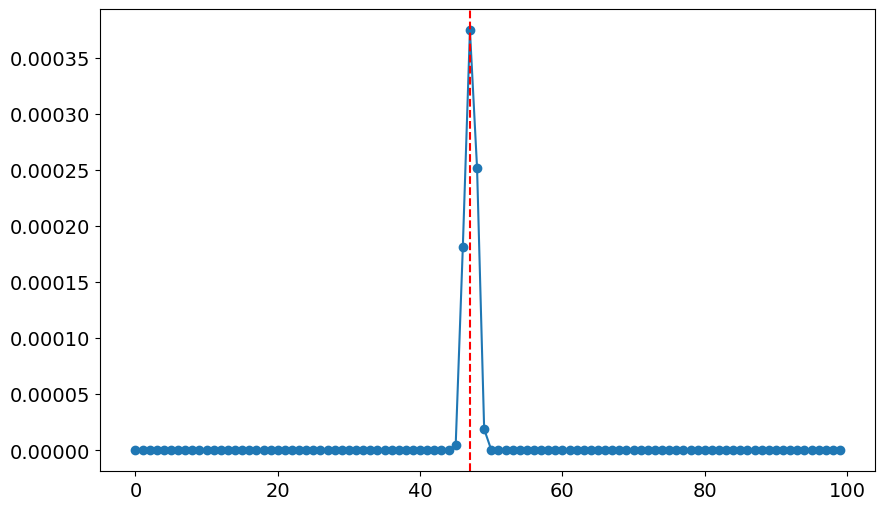

In [83]:
lines_processed = np.abs(np.prod((lines-lines.mean())/(np.max(lines)-lines.mean()), axis=0))
xmax = np.argmax(lines_processed)
                          
plt.plot(lines_processed, marker='o')
plt.axvline(x=xmax, color='r', linestyle='--')


### and amplitude

In [84]:
def amp_rabi_f0g1_err_amp(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no = 1):
    """Run the Length Rabi General F0g1 repeatedly to amplify error."""

    expt_cfg = dict(
        start=ds_thisrun.get_gain(f'M{man_mode_no}')-50*50,  # Pulse start length [dac unit]
        step=50,  # Pulse step length [dac unit]
        qubits=[0],
        expts=100,
        reps=200,
        rounds=1,
        rep_start=0,
        rep_end=19,
        # gain=15000,  # Qubit gain [DAC units]
        ramp_sigma=0.005,  # Ramp sigma [us]
        freq= ds_thisrun.get_freq('M' + str(man_mode_no)),  # Frequency [MHz]
        length= ds_thisrun.get_pi(f'M{man_mode_no}'),
        use_arb_waveform=False,
        pi_ge_before=True,
        pi_ef_before=True,
        pi_ef_after=True,
        normalize=False,
        active_reset=False,
        check_man_reset=[False, 0],
        swap_lossy=False,
        check_man_reset_pi=[],
        prepulse=False,
        pre_sweep_pulse=[]
    )

    for err_amp_reps in tqdm(range(expt_cfg['rep_start'], expt_cfg['rep_end'] + 1)):
        amp_rabi = meas.single_qubit.amplitude_rabi_f0g1_general.AmplitudeRabiGeneralF0g1Experiment(
            soccfg=soc, path=expt_path, prefix='AmplitudeRabiGeneralF0g1Experiment', config_file=config_path
        )

        amp_rabi.cfg = AttrDict(deepcopy(config_thisrun))

        expt_cfg['err_amp_reps'] = err_amp_reps

        amp_rabi.cfg.expt = expt_cfg

        amp_rabi.cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]
        amp_rabi.go(analyze=False, display=False, progress=False, save=True)
    return amp_rabi

In [85]:
amp_rabi_f0g1_err_amp(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no=1)
    

  5%|▌         | 1/20 [00:56<17:57, 56.73s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00015_AmplitudeRabiGeneralF0g1Experiment.h5


 10%|█         | 2/20 [01:53<17:01, 56.72s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00016_AmplitudeRabiGeneralF0g1Experiment.h5


 15%|█▌        | 3/20 [02:50<16:05, 56.80s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00017_AmplitudeRabiGeneralF0g1Experiment.h5


 20%|██        | 4/20 [03:47<15:09, 56.86s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00018_AmplitudeRabiGeneralF0g1Experiment.h5


 25%|██▌       | 5/20 [04:44<14:13, 56.89s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00019_AmplitudeRabiGeneralF0g1Experiment.h5


 30%|███       | 6/20 [05:41<13:17, 56.96s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00020_AmplitudeRabiGeneralF0g1Experiment.h5


 35%|███▌      | 7/20 [06:38<12:21, 57.01s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00021_AmplitudeRabiGeneralF0g1Experiment.h5


 40%|████      | 8/20 [07:35<11:25, 57.11s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00022_AmplitudeRabiGeneralF0g1Experiment.h5


 45%|████▌     | 9/20 [08:33<10:28, 57.17s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00023_AmplitudeRabiGeneralF0g1Experiment.h5


 50%|█████     | 10/20 [09:30<09:32, 57.24s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00024_AmplitudeRabiGeneralF0g1Experiment.h5


 55%|█████▌    | 11/20 [10:28<08:36, 57.36s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00025_AmplitudeRabiGeneralF0g1Experiment.h5


 60%|██████    | 12/20 [11:25<07:39, 57.38s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00026_AmplitudeRabiGeneralF0g1Experiment.h5


 65%|██████▌   | 13/20 [12:23<06:42, 57.46s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00027_AmplitudeRabiGeneralF0g1Experiment.h5


 70%|███████   | 14/20 [13:20<05:45, 57.50s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00028_AmplitudeRabiGeneralF0g1Experiment.h5


 75%|███████▌  | 15/20 [14:18<04:48, 57.66s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00029_AmplitudeRabiGeneralF0g1Experiment.h5


 80%|████████  | 16/20 [15:16<03:50, 57.72s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00030_AmplitudeRabiGeneralF0g1Experiment.h5


 85%|████████▌ | 17/20 [16:14<02:53, 57.79s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00031_AmplitudeRabiGeneralF0g1Experiment.h5


 90%|█████████ | 18/20 [17:12<01:55, 57.94s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00032_AmplitudeRabiGeneralF0g1Experiment.h5


 95%|█████████▌| 19/20 [18:11<00:58, 58.01s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00033_AmplitudeRabiGeneralF0g1Experiment.h5


100%|██████████| 20/20 [19:09<00:00, 57.46s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00034_AmplitudeRabiGeneralF0g1Experiment.h5


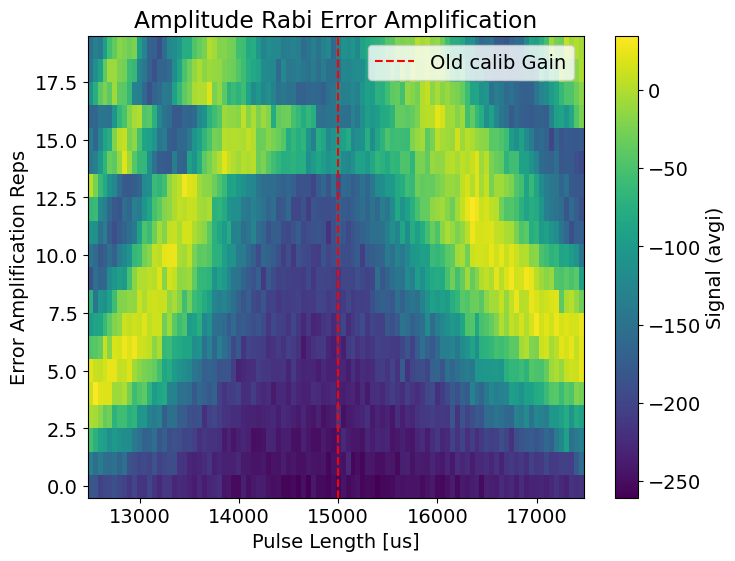

In [130]:
lines = []
ypts = []
for prefix_num in range(15,35):
    fname = f'{prefix_num:05d}_AmplitudeRabiGeneralF0g1Experiment.h5'
    temp_data, attrs, filename = prev_data(expt_path, fname)
    lines.append(temp_data['avgi'])
    ypts.append(attrs['config']['expt']['err_amp_reps'])
xpts = temp_data['xpts']

lines = np.array(lines)
ypts = np.array(ypts)

plt.figure(figsize=(8, 6))
plt.pcolormesh(xpts, ypts, lines, shading='auto', cmap='viridis')
plt.axvline(x=ds_thisrun.get_gain('M1'), color='r', linestyle='--', label='Old calib Gain')
plt.xlabel('Pulse Length [us]')
plt.ylabel('Error Amplification Reps')
plt.title('Amplitude Rabi Error Amplification')
plt.colorbar(label='Signal (avgi)')
plt.legend()
plt.show()

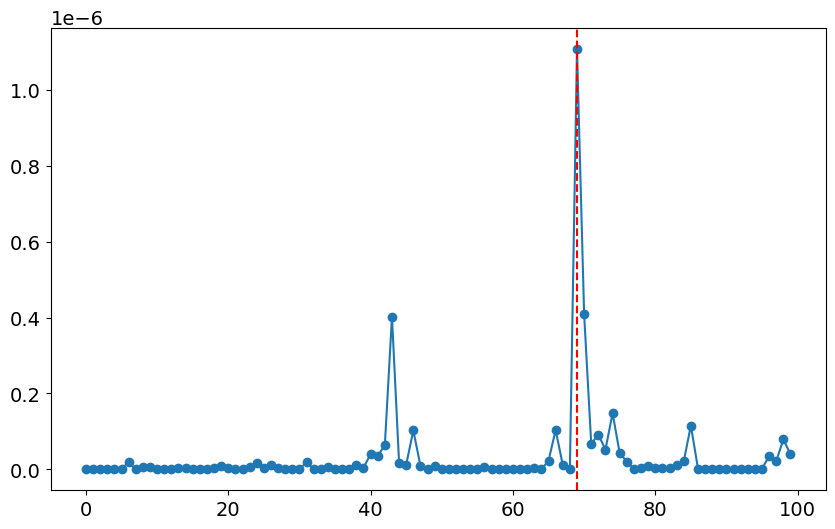

In [131]:
lines_processed = np.abs(np.prod((lines-lines.mean())/(np.max(lines)-lines.mean()), axis=0))
xmax = np.argmax(lines_processed)
                          
plt.plot(lines_processed, marker='o')
plt.axvline(x=xmax, color='r', linestyle='--')

## Chi between qubit and Manipulate 

### ge

In [101]:
from MM_dual_rail_base import MM_dual_rail_base

# the do function contains 2 calls to ramsey, one with no prepulse and one with prepulse 
# that initializes manipulation mode to 1 state
def do_chi(config_thisrun, expt_path, config_path, prepulse=None, standard_ramsey=True,
           man_mode_no=1):
    """
    Run two Ramsey experiments: one standard, one with a prepulse that initializes manipulation mode 1.
    Returns both experiment objects.
    """
    # Standard Ramsey (no prepulse)
    if standard_ramsey:
        t2ramsey_no_prepulse = do_t2_ramsey_ge(config_thisrun, expt_path, config_path, pre_sweep_pulse=None, post_sweep_pulse=None, 
                                                step_size=0.1)
    else: 
        t2ramsey_no_prepulse = None

    # Ramsey with prepulse (initialize manipulation mode 1)
    if prepulse is None:
        mm_base_dummy = MM_dual_rail_base(config_thisrun)
        prep_man_pi = mm_base_dummy.prep_man_photon(man_mode_no)
        prepulse = mm_base_dummy.get_prepulse_creator(prep_man_pi).pulse.tolist()

    t2ramsey_with_prepulse = do_t2_ramsey_ge(config_thisrun, expt_path, config_path, pre_sweep_pulse=prepulse, post_sweep_pulse=None,
                                                step_size=0.1)

    return t2ramsey_no_prepulse, t2ramsey_with_prepulse

def update_chi(t2_ramsey_original, t2_ramsey_prepulse, config_thisrun, man_mode_no=1):
    """
    Update config_thisrun.device.qubit.chi for the given manipulation mode.
    """
    f_without_prepulse = t2_ramsey_original.data['f_adjust_ramsey_avgi'][0]
    f_with_prepulse = t2_ramsey_prepulse.data['f_adjust_ramsey_avgi'][0]
    chi = f_with_prepulse - f_without_prepulse
    print('Chi:', chi)
    config_thisrun.device.manipulate.chi_ge[man_mode_no - 1] = chi
    config_thisrun.device.manipulate.revival_time[man_mode_no-1] = np.abs(np.pi/(2 * np.pi * chi))
    print('Delay time (mus):', config_thisrun.device.manipulate.revival_time[man_mode_no-1] )


fge is  3569.462965491148
fef is  3426.2579958470365


  0%|          | 0/10000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data\00062_RamseyExperiment.h5
fge is  3569.462965491148
fef is  3426.2579958470365


  0%|          | 0/10000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data\00063_RamseyExperiment.h5
Attempted to init fitparam 4 to -95.11045356158992, which is out of bounds -241.44194805194806 to -185.17496753246752. Instead init to -213.30845779220778
Attempted to init fitparam 4 to -213.30845779220778, which is out of bounds 195.10469796722958 to 356.44599582715864. Instead init to 275.77534689719414
Current pi pulse frequency: 3569.462965491148
Fit frequency from I [MHz]: 0.21269538809070834 +/- 0.0008396159067629018
Suggested new pi pulse frequency from fit I [MHz]:
 	3569.4502701030574
 	3569.875660879239
T2 Ramsey from fit I [us]: 142.81352774778344
Fit frequency from Q [MHz]: 0.2100035403441782 +/- 0.004005113223192058
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3569.452961950804
 	3569.8729690314926
T2 Ramsey from fit Q [us]: 6.7630317620075875


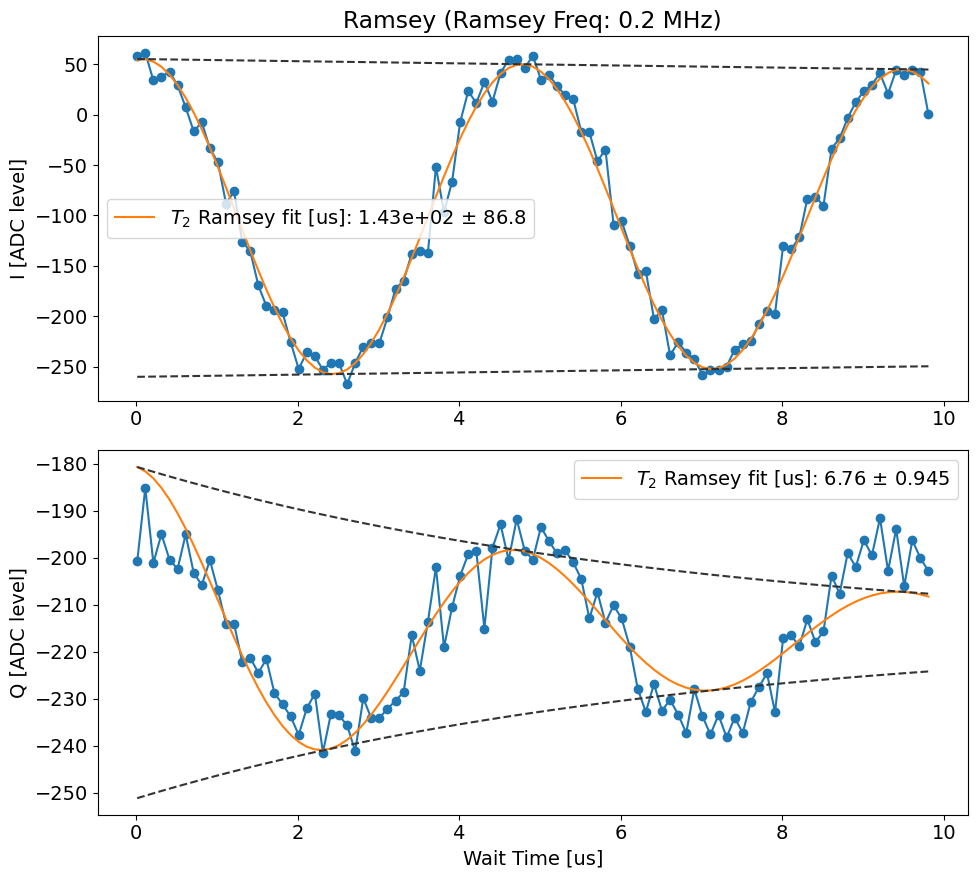

Attempted to init fitparam 4 to -95.94864390659846, which is out of bounds -238.83262987012986 to -177.970487012987. Instead init to -208.40155844155845
Attempted to init fitparam 4 to -208.40155844155845, which is out of bounds 178.16317119024183 to 342.57638338711104. Instead init to 260.36977728867646
Current pi pulse frequency: 3569.462965491148
Fit frequency from I [MHz]: 0.5056226810226293 +/- 0.000848827482405089
Suggested new pi pulse frequency from fit I [MHz]:
 	3569.1573428101256
 	3570.168588172171
T2 Ramsey from fit I [us]: 84.21360554378474
Fit frequency from Q [MHz]: 0.5023580316241741 +/- 0.005239018005397417
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3569.1606074595243
 	3570.1653235227723
T2 Ramsey from fit Q [us]: 6.17165850771561


Chi: -0.292927292931921


AttributeError: 'AttrDict' object has no attribute 'chi'

In [106]:
t2_ramsey_original, t2_ramsey_prepulse = None, None
if expts_to_run['chi']:
    # Run the chi experiment
    t2_ramsey_original, t2_ramsey_prepulse = do_chi(config_thisrun, expt_path, config_path, standard_ramsey=True)
    # analyze and display the results
    t2_ramsey_original.analyze(fitparams=[300, None, None, None, None, None])
    t2_ramsey_original.display()
    t2_ramsey_prepulse.analyze(fitparams=[300, None, None, None, None, None])
    t2_ramsey_prepulse.display() 
    # update the config_thisrun with the chi value
    update_chi(t2_ramsey_original, t2_ramsey_prepulse, config_thisrun, man_mode_no=1)
    print('Only doing it for mode 1')

In [116]:
update_chi(t2_ramsey_original, t2_ramsey_prepulse, config_thisrun, man_mode_no=1)

Chi: -0.292927292931921
Delay time (mus): 1.7069082057717464


In [112]:
config_thisrun.device.manipulate.revival_time[0] = np.pi/(2 * np.pi * config_thisrun.device.manipulate.chi[0])

In [73]:
[[1],[2]] + [[3]]

[[1], [2], [3]]

### ef

In [ ]:
from MM_dual_rail_base import MM_dual_rail_base

# the do function contains 2 calls to ramsey, one with no prepulse and one with prepulse 
# that initializes manipulation mode to 1 state
def do_chi_f(config_thisrun, expt_path, config_path, 
           man_mode_no=1):
    """
    Run two Ramsey experiments: one standard, one with a prepulse that initializes manipulation mode 1.
    Returns both experiment objects.
    """

    
    mm_base_dummy = MM_dual_rail_base(config_thisrun)
    prep_man_pi = mm_base_dummy.prep_man_photon(man_mode_no)
    # Add qubit ge prepulse and postpulse for ef (ge init)
    qubit_ge_prepulse = [['qubit', 'ge', 'pi', 0]]
    prep_man_pi_prepulse = mm_base_dummy.get_prepulse_creator(prep_man_pi).pulse.tolist()
    prepulse =  mm_base_dummy.get_prepulse_creator(prep_man_pi + qubit_ge_prepulse ).pulse.tolist() 
    postpulse  = mm_base_dummy.get_prepulse_creator(qubit_ge_prepulse).pulse.tolist()

    # Add chi to frequency of qubit ge 
    # prepulse[0][-1] += config_thisrun.device.manipulate.chi[man_mode_no - 1]
    # postpulse[0][-1] += config_thisrun.device.manipulate.chi[man_mode_no - 1]

    # Do an ef and ge ramsey with this prepulse 
    # Run ge Ramsey 
    
    
    t2ramsey_no_prepulse_ge = do_t2_ramsey_ge(config_thisrun,
        expt_path,
        config_path,
        step_size=0.1,
        pre_sweep_pulse=prep_man_pi_prepulse,
        post_sweep_pulse=None)
    # Run ef Ramsey with prepulse and postpulse
    t2ramsey_with_prepulse_ef = do_t2_ramsey_ef(
        config_thisrun,
        expt_path,
        config_path,
        pre_sweep_pulse=prepulse,
        post_sweep_pulse=postpulse,
        step_size=0.1,
        ef_init=False  # Do not initialize ef, we are already in ef state
    )
    

    return t2ramsey_no_prepulse_ge, t2ramsey_with_prepulse_ef

def update_chi_ef(t2_standard_ramsey, t2_prepulsed_ramsey, config_thisrun, man_mode_no=1):
    """
    Update config_thisrun.device.qubit.chi for the given manipulation mode.
    """
    f_with_prepulse = t2_prepulsed_ramsey.data['f_adjust_ramsey_avgi'][0]
    f_without_prepulse = t2_standard_ramsey.data['f_adjust_ramsey_avgi'][0]
    chi_ef = f_with_prepulse - f_without_prepulse
    print('Chi:', chi_ef)
    config_thisrun.device.manipulate.chi_ef[man_mode_no - 1] = chi_ef


In [95]:
expts_to_run['chi_ef'] = True

fge is  3569.4263053206314
fef is  3426.287416084909


  0%|          | 0/20000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00025_RamseyExperiment.h5
Attempted to init fitparam 4 to -117.74935753640297, which is out of bounds 60.4033278621117 to 347.8021004718075. Instead init to 204.1027141669596
Current pi pulse frequency: 3426.287416084909
Fit frequency from I [MHz]: 0.1966158344557557 +/- 0.0004053549939583848
Suggested new pi pulse frequency from fit I [MHz]:
 	3426.2908002504532
 	3426.6840319193648
T2 Ramsey from fit I [us]: 59.95073651347737
Fit frequency from Q [MHz]: 0.1967541049575576 +/- 0.00045642866587789827
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3426.2906619799514
 	3426.6841701898666
T2 Ramsey from fit Q [us]: 40.098270832451576


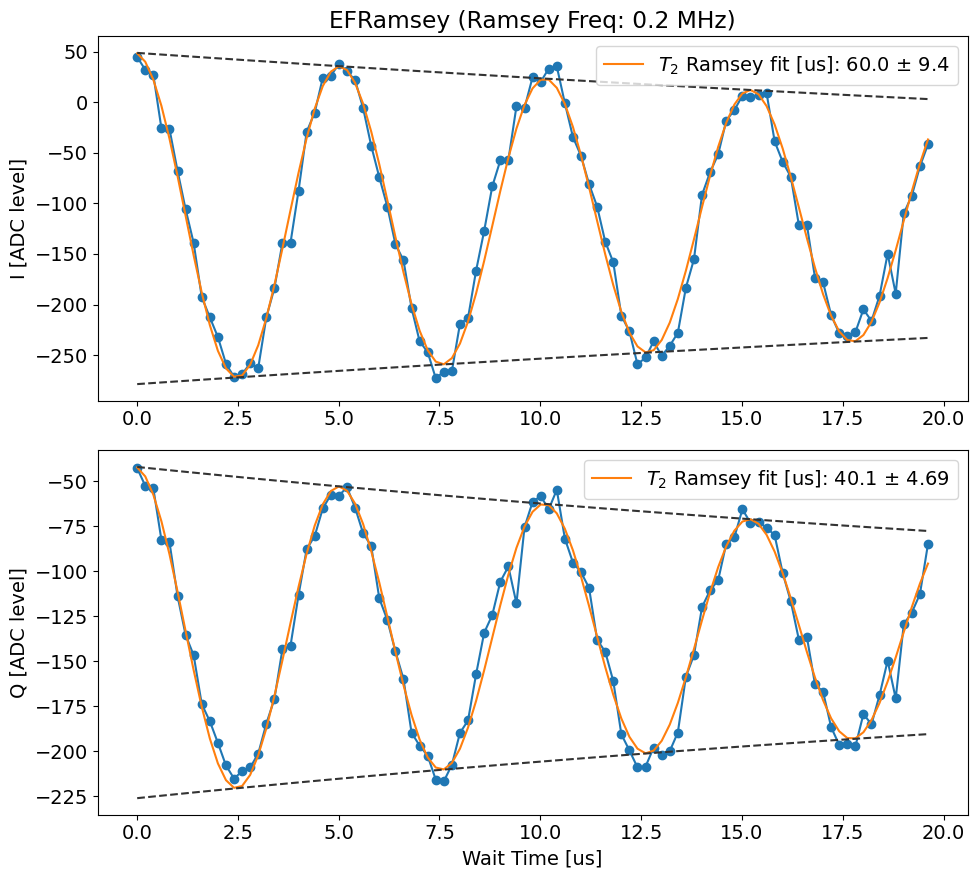

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-25_11-40-48_T2_ef_standard_for_chief.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-25.md
fge is  3569.1333780276996
fef is  3426.287416084909


  0%|          | 0/20000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00026_RamseyExperiment.h5
fge is  3569.1333780276996
fef is  3426.287416084909


  0%|          | 0/20000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00027_RamseyExperiment.h5
Attempted to init fitparam 4 to -125.59985406008136, which is out of bounds -222.16439935064935 to -198.52011363636365. Instead init to -210.3422564935065
Attempted to init fitparam 4 to -210.3422564935065, which is out of bounds 200.76991084469594 to 347.51340013886016. Instead init to 274.14165549177807
Current pi pulse frequency: 3569.1333780276996
Fit frequency from I [MHz]: 0.19927913869446717 +/- 0.0006042866743850056
Suggested new pi pulse frequency from fit I [MHz]:
 	3569.134098889005
 	3569.532657166394
T2 Ramsey from fit I [us]: 127.59796910682137
Fit frequency from Q [MHz]: 0.20202020202020202 +/- inf
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3569.1313578256795
 	3569.5353982297197
T2 Ramsey from fit Q [us]: 9.8


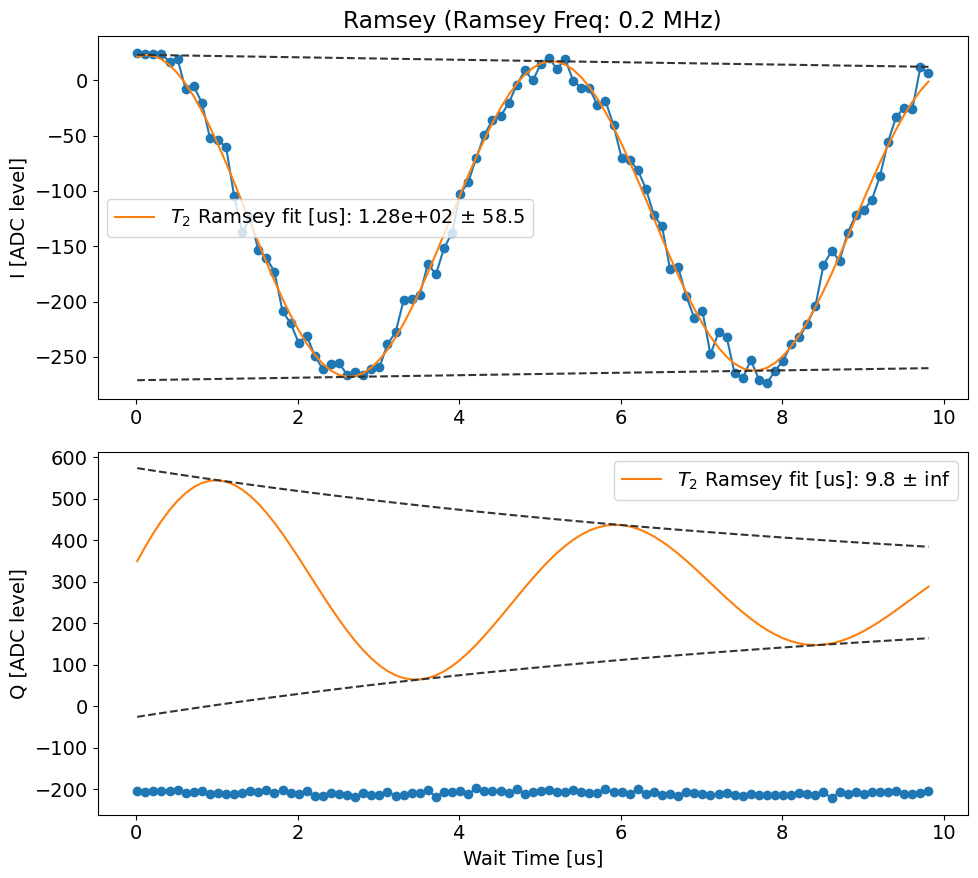

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-25_11-42-38_T2_ge_for_chief_tocheck_this_is_correctly_at_ramsey_freq.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-25.md
Attempted to init fitparam 4 to -113.20719778958416, which is out of bounds 58.252174763413876 to 333.7562584025612. Instead init to 196.0042165829875
Current pi pulse frequency: 3426.287416084909
Fit frequency from I [MHz]: 0.4436092689059414 +/- 0.000649920925814412
Suggested new pi pulse frequency from fit I [MHz]:
 	3426.0438068160033
 	3426.931025353815
T2 Ramsey from fit I [us]: 80.31943781627605
Fit frequency from Q [MHz]: 0.44294459649585743 +/- 0.0010204731612759002
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3426.0444714884134
 	3426.930360681405
T2 Ramsey from fit Q [us]: 20.029225954138347


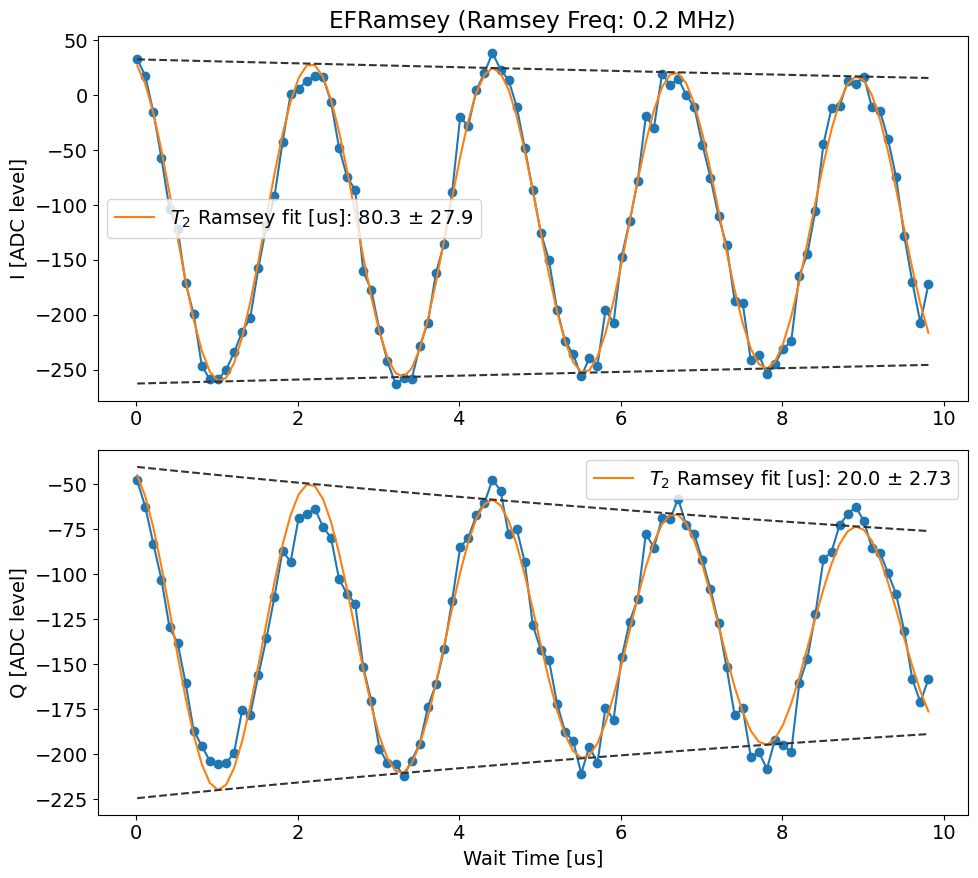

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-25_11-42-39_T2_ef_for_chief.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-25.md
Chi: -0.24699343445018568


AttributeError: 'AttrDict' object has no attribute 'chi_ef'

In [ ]:
man_mode_no = 1
t2ge_ramsey_forchief, t2ef_ramsey_forchief = None, None
t2ef_standard_ramsey_forchief = None
if expts_to_run['chi_ef']:
    
    #get standard ef ramsey 
    t2ef_standard_ramsey_forchief = do_t2_ramsey_ef(config_thisrun, expt_path, config_path)
    # analyze and display the results
    t2ef_standard_ramsey_forchief.analyze(fitparams=[300, None, None, None, None, None])
    t2ef_standard_ramsey_forchief.display(title_str='T2_ef_standard_for_chief')

    # Now ramseys with man photon prepulse
    config_thisrun_chief = deepcopy(config_thisrun)
    config_thisrun_chief.device.qubit.f_ge[0] += config_thisrun.device.manipulate.chi_ge[man_mode_no - 1]
    t2ge_ramsey_forchief, t2ef_ramsey_forchief = do_chi_f(config_thisrun_chief, expt_path, config_path)
    # analyze and display the results
    t2ge_ramsey_forchief.analyze(fitparams=[300, None, None, None, None, None])
    t2ge_ramsey_forchief.display(title_str='T2_ge_for_chief_tocheck_this_is_correctly_at_ramsey_freq')
    t2ef_ramsey_forchief.analyze(fitparams=[300, None, None, None, None, None])
    t2ef_ramsey_forchief.display(title_str='T2_ef_for_chief')
    # update the config_thisrun with the chi value
    update_chi_ef(t2ef_standard_ramsey_forchief, t2ef_ramsey_forchief, config_thisrun)


In [110]:
update_chi_ef(t2ef_standard_ramsey_forchief, t2ef_ramsey_forchief, config_thisrun)

Chi: -0.24699343445018568
Delay time (mus): 1.7069082057717464


In [93]:
t2ge_ramsey_forchief.cfg.expt.ramsey_freq 

0.2

In [89]:
t2ge_ramsey_forchief.analyze(fitparams=[300, None, None, None, None, None])
t2ge_ramsey_forchief.display(title_str='T2_ef_ramsey_forchief')

Attempted to init fitparam 4 to -125.71023448773448, which is out of bounds -219.5887012987013 to -199.48212662337662. Instead init to -209.53541396103896
Attempted to init fitparam 4 to -209.53541396103896, which is out of bounds 200.54989956758706 to 346.5241438050083. Instead init to 273.5370216862977
Current pi pulse frequency: 3569.1333780276996
Fit frequency from I [MHz]: 0.19854995842665096 +/- 0.0005827086582817522
Suggested new pi pulse frequency from fit I [MHz]:
 	3569.1348280692728
 	3569.531927986126
T2 Ramsey from fit I [us]: 105.66479817677455
Fit frequency from Q [MHz]: 0.2095425690008492 +/- 0.015508265275182623
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3569.1238354586985
 	3569.5429205967002
T2 Ramsey from fit Q [us]: 3.507065327879664


supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-25_11-26-28_T2_ef_ramsey_forchief.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-25.md


Attempted to init fitparam 4 to -117.4212093335957, which is out of bounds 57.88465010748641 to 337.4661756256318. Instead init to 197.6754128665591
Current pi pulse frequency: 3426.287416084909
Fit frequency from I [MHz]: 0.4416697734129779 +/- 0.0010226455923950694
Suggested new pi pulse frequency from fit I [MHz]:
 	3426.0457463114963
 	3426.929085858322
T2 Ramsey from fit I [us]: 50.898566061848925
Fit frequency from Q [MHz]: 0.4413191695544237 +/- 0.0014350706333218263
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3426.0460969153546
 	3426.9287352544634
T2 Ramsey from fit Q [us]: 19.14881222091236


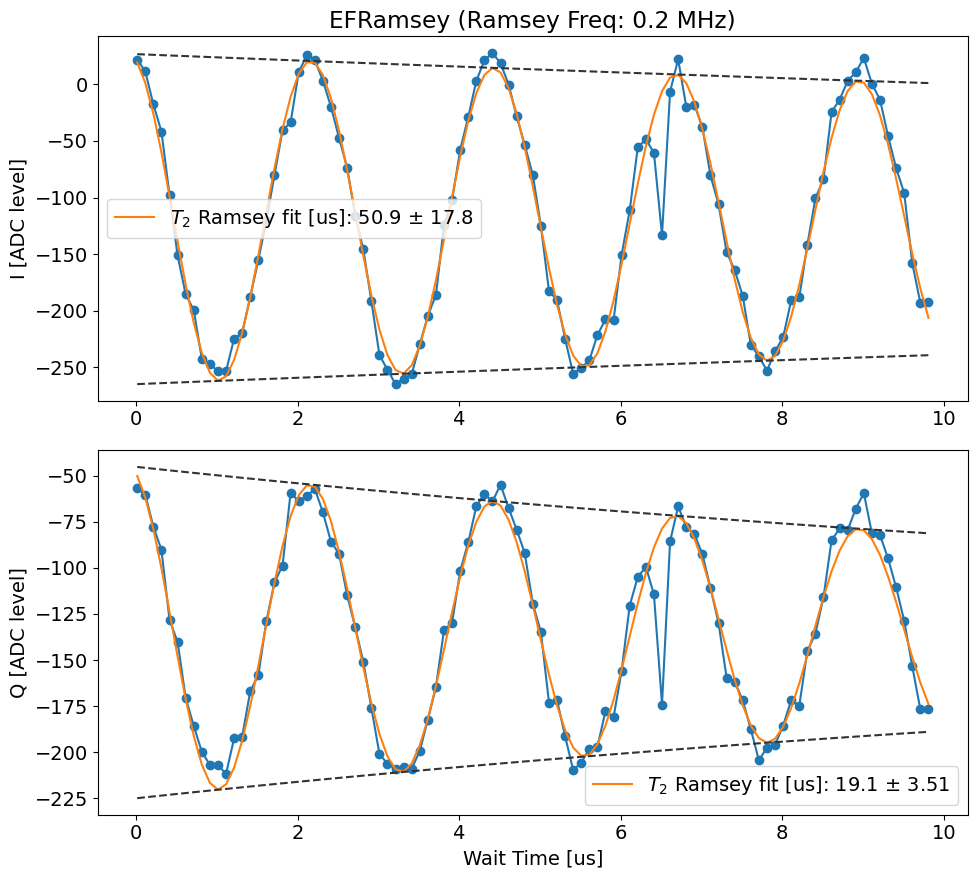

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-25_11-26-41_T2_ef_ramsey_forchief.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-25.md


In [90]:
t2ef_ramsey_forchief.analyze(fitparams=[300, None, None, None, None, None])
t2ef_ramsey_forchief.display(title_str='T2_ef_ramsey_forchief')

In [ ]:
t2ge_ramsey_forchief.analyze()
t2ge_ramsey_forchief.display(title_str='T2_ge_ramsey_forchief')

## Parity Delay
NOT Implemented yet: We can use chi to estimate parity waiting time pi/chi but can also fine tune it using this experiment

Basically Length rabi analysis 

## T1

In [144]:


def do_t1_manipulate(config_thisrun, expt_path, config_path, man_mode_no=1):
    """
    Run T1 experiment for the specified manipulate mode (man_mode_no).
    """
    t1_man = meas.single_qubit.t1_cavity.T1CavityExperiment(
        soccfg=soc, path=expt_path, prefix='T1CavityExperiment', config_file=config_path
    )

    t1_man.cfg = AttrDict(deepcopy(config_thisrun))

    # Set experiment parameters for the specified manipulate mode
    t1_man.cfg.expt = dict(
        start=0,
        step=15,
        expts=60,
        reps=300,
        rounds=1,
        cavity_prepulse=[False, 300, 1.5],
        f0g1_prep=True,
        f0g1_param=[ds_thisrun.get_freq(f'M{man_mode_no}'), ds_thisrun.get_gain(f'M{man_mode_no}'), ds_thisrun.get_pi(f'M{man_mode_no}')],
        resolved_pi=False,
        cavity=man_mode_no,
        qubit=0,
        normalize=False
    )

    t1_man.cfg.device.readout.relax_delay = [2500]
    t1_man.go(analyze=True, display=True, progress=True, save=True)
    return t1_man



  0%|          | 0/18000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data\00000_T1CavityExperiment.h5
Fit T1 avgi [us]: 245.73319298547162
Fit T1 avgq [us]: 239.08476736949262


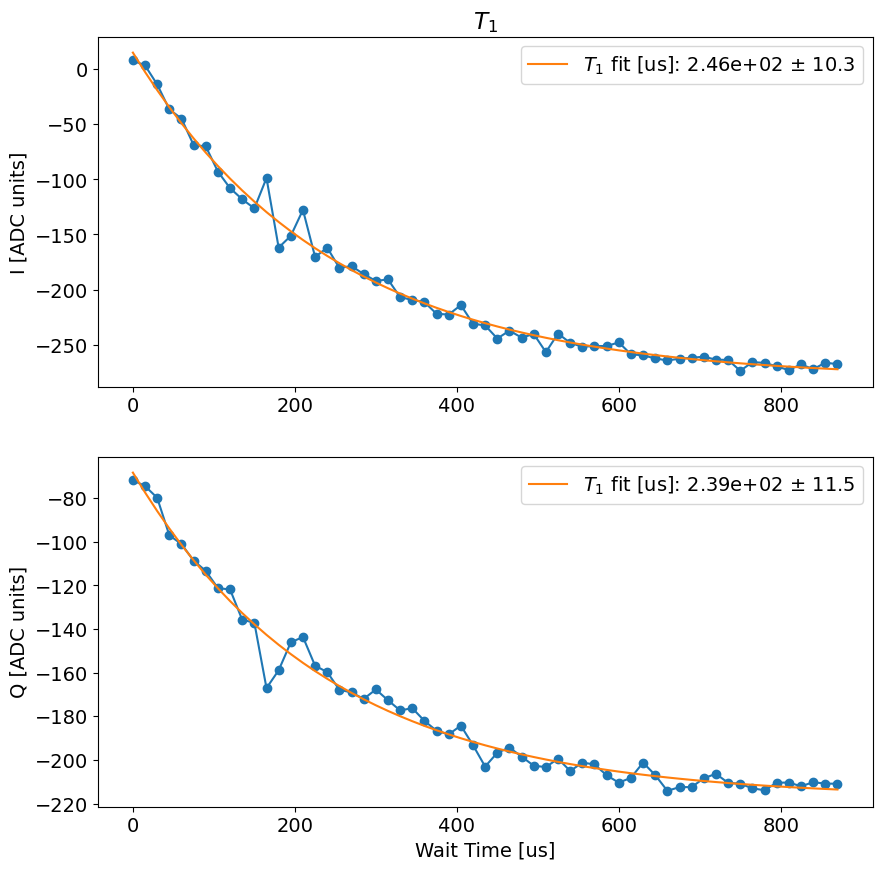

In [ ]:
t1_man = do_t1_manipulate(config_thisrun, expt_path, config_path, 1)

## T2

In [177]:
def do_cavity_ramsey(config_thisrun, expt_path, config_path, man_mode_no=1):
    """
    Run the Cavity Ramsey experiment using the specified configuration.
    """
    cavity_ramsey = meas.single_qubit.t2_cavity.CavityRamseyExperiment(
        soccfg=soc, path=expt_path, prefix='CavityRamseyExperiment', config_file=config_path
    )

    cavity_ramsey.cfg = AttrDict(deepcopy(config_thisrun))

    # Prepulse and postpulse

    # Set experiment parameters as in the YAML block above
    cavity_ramsey.cfg.expt = dict(
        start=0.01,
        step=0.05,
        expts=100,
        ramsey_freq=3.7,
        reps=50,
        rounds=1,
        qubits=[0],
        checkEF=False,
        f0g1_cavity=0,
        init_gf=False,
        active_reset=False,
        man_reset=True,
        storage_reset=True,
        user_defined_pulse=[True, ds_thisrun.get_freq(stor_name='M'+ str(man_mode_no)), 
                            ds_thisrun.get_gain(stor_name='M'+ str(man_mode_no)), 0.005, 
                            ds_thisrun.get_pi(stor_name='M'+ str(man_mode_no)), 0],
        parity_meas=False,
        man_idx=1,
        storage_ramsey=[False, 2, True],
        man_ramsey=[False, man_mode_no],
        coupler_ramsey=False,
        custom_coupler_pulse=[[944.25], [1000], [0.316677658], [0], [1], ['flat_top'], [0.005]],
        echoes=[False, 0],
        prepulse=True,
        postpulse=True,
        gate_based = True,
        pre_sweep_pulse= [['qubit', 'ge', 'hpi', 0], ['qubit', 'ef', 'pi', 0]],
        post_sweep_pulse=[['qubit', 'ef', 'pi', 0], ['qubit', 'ge', 'hpi', 0]]
    )

    cavity_ramsey.cfg.device.readout.relax_delay = [2500]
    cavity_ramsey.go(analyze=False, display=False, progress=True, save=True)
    return cavity_ramsey

cavity_ramsey = do_cavity_ramsey(config_thisrun, expt_path, config_path, man_mode_no=1)

Running f0g1 ramsey
phase update channel: [0]
phase step deg: 66.60000000000001
phase step logic: +
inide t2 cavity acquire
100


  0%|          | 0/5000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data\00008_CavityRamseyExperiment.h5


In [178]:
cavity_ramsey.analyze()
cavity_ramsey.display()

Attempted to init fitparam 1 to 6.8686868686868685, which is out of bounds 0.02040816326530612 to 3.061224489795918. Instead init to 1.540816326530612
Current pi pulse frequency: 3569.462965491148
Fit frequency from I [MHz]: 3.060276703771371 +/- 0.05821304578443343
Suggested new pi pulse frequency from fit I [MHz]:
 	3570.102688787377
 	3576.2232421949197
T2 Ramsey from fit I [us]: 2.6830715424324296
Fit frequency from Q [MHz]: 0.9785645272761624 +/- 0.06768238650507281
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3572.184400963872
 	3574.1415300184244
T2 Ramsey from fit Q [us]: 2.8151631256662872


# Storage

## Stor Spectroscopy

In [196]:
def get_storage_mode_parameters(ds_thisrun, config_thisrun, man_mode_no, stor_mode_no):
    """
    Get pulse parameters for a given storage mode. 
    Also returns prepulse and postpulse (single photon prep and meas for ge meas)

    Args:
        ds_thisrun: Dataset object for managing frequency data.
        config_thisrun: Configuration dictionary for the current run.
        man_mode_no: Manipulation mode number.
        stor_mode_no: Storage mode number.

    Returns:
        A tuple containing freq, gain, ch, prepulse, and postpulse.
    """
    freq = ds_thisrun.get_freq('M' + str(man_mode_no) + '-S' + str(stor_mode_no))
    gain = ds_thisrun.get_gain('M' + str(man_mode_no) + '-S' + str(stor_mode_no))
    ch = 'low' if freq < 1000 else 'high'

    from MM_dual_rail_base import MM_dual_rail_base
    mm_base_dummy = MM_dual_rail_base(config_thisrun)
    prep_man_pi = mm_base_dummy.prep_man_photon(man_mode_no)
    prepulse = mm_base_dummy.get_prepulse_creator(prep_man_pi).pulse.tolist()
    postpulse = mm_base_dummy.get_prepulse_creator(prep_man_pi[-1:-3:-1]).pulse.tolist() # for ge meas, only do f0g1 and ef pi

    return freq, gain, ch, prepulse, postpulse


def do_stor_spectroscopy(config_thisrun, ds_thisrun,  expt_path, config_path, man_mode_no = 1, stor_no = 1):
    """
    Run the Flux Spectroscopy F0g1 Experiment.

    This function performs a flux spectroscopy experiment to measure the transition frequency
    between the f0 and g1 states of a qubit. It configures the experiment parameters, executes
    the experiment, and saves the results.

    Args:
        config_thisrun (AttrDict): Configuration dictionary for the current run.
        ds_thisrun (dataset.storage_man_swap_dataset): Dataset object for managing frequency data.
        expt_path (str): Path to save the experiment results.
        config_path (str): Path to the configuration file.
        man_mode_no (int, optional): Manipulation mode number (default is 1).
        stor_no (int, optional): Storage mode number (default is 1).

    Returns:
        FluxSpectroscopyF0g1Experiment: The experiment object containing the results.
    """
    flux_spec = meas.single_qubit.rf_flux_spectroscopy_f0g1.FluxSpectroscopyF0g1Experiment(
        soccfg=soc, path=expt_path, prefix='FluxSpectroscopyF0g1Experiment', config_file=config_path
    )

    flux_spec.cfg = AttrDict(deepcopy(config_thisrun))

    freq, gain,ch, prepulse, postpulse = get_storage_mode_parameters(ds_thisrun, config_thisrun,
                                                                      man_mode_no, stor_no)

    flux_spec.cfg.expt = dict(
        start=freq - 15,  # Start RF frequency [MHz]
        step=0.15,  # Step size [MHz]
        expts=200,  # Number of experiments
        reps=100,  # Number of averages per point
        qubit=[0],
        flux_drive=[ch, 1,5000, 1],  # RF flux modulation parameters [low/high (ch), freq (will be overwritten), gain, length(us)]
        prepulse=True,
        postpulse=True,
        active_reset=False,
        pre_sweep_pulse= prepulse,
        post_sweep_pulse= postpulse,
    )

    flux_spec.cfg.device.readout.relax_delay = [500]  # Wait time between experiments [us]
    flux_spec.go(analyze=False, display=False, progress=True, save=True)
    return flux_spec



def analyze_and_display_stor_spectroscopy(flux_spec):
    """Analyze and display results of Flux Spectroscopy F0g1 Experiment."""
    from multimode_expts.fit_display_classes import Spectroscopy
    spec_analysis = Spectroscopy(flux_spec.data)
    spec_analysis.analyze(fit=True)
    spec_analysis.display()


def update_stor_spectroscopy(flux_spec, ds_thisrun, man_mode_no = 1, stor_no = 1):
    """Update the configuration based on Flux Spectroscopy F0g1 experiment results."""
    # Update the dataset with the new frequency
    ds_thisrun.update_freq('M' + str(man_mode_no) + '-S' + str(stor_no), flux_spec.data['fit_avgi'][2])
    print(f"Updated frequency for M{man_mode_no}-S{stor_no}: {flux_spec.data['fit_avgi'][2]}")


In [194]:
ds_thisrun.update_freq('M1-S2', 520)

In [102]:
stor_specs = [None]* len(expts_to_run['stor_modes'])
for i in range(len(expts_to_run['stor_modes'])):
    if expts_to_run['stor_spectroscopy']:
        print('Running flux spectroscopy f0g1 for mode', i+1)
        flux_spec = do_stor_spectroscopy(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no=1, stor_no=i+1)
        stor_specs[i] = flux_spec
        analyze_and_display_stor_spectroscopy(flux_spec)
        update_stor_spectroscopy(flux_spec, ds_thisrun, man_mode_no=1, stor_no=i+1)

Running flux spectroscopy f0g1 for mode 1


  0%|          | 0/200 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data\00035_FluxSpectroscopyF0g1Experiment.h5
Found peak in amps at [MHz] 348.0052001187364, HWHM 1.2412066730721865
Found peak in I at [MHz] 348.2197174269142, HWHM 1.640551713115102
Found peak in Q at [MHz] 349.2924017553497, HWHM 3.7133525661026057


Updated frequency for M1-S1: 348.2197174269142
Running flux spectroscopy f0g1 for mode 2


KeyboardInterrupt: 

  0%|          | 0/200 [00:00<?, ?it/s]

dict_keys(['device', 'hw', 'aliases', 'data_management', 'expt', 'start', 'step', 'expts', 'reps', 'qubit', 'flux_drive', 'prepulse', 'postpulse', 'active_reset', 'pre_sweep_pulse', 'post_sweep_pulse', 'frequency']) dict_keys(['start', 'step', 'expts', 'reps', 'qubit', 'flux_drive', 'prepulse', 'postpulse', 'active_reset', 'pre_sweep_pulse', 'post_sweep_pulse', 'frequency'])
dict_keys(['device', 'hw', 'aliases', 'data_management', 'expt', 'start', 'step', 'expts', 'reps', 'qubit', 'flux_drive', 'prepulse', 'postpulse', 'active_reset', 'pre_sweep_pulse', 'post_sweep_pulse', 'frequency']) dict_keys(['start', 'step', 'expts', 'reps', 'qubit', 'flux_drive', 'prepulse', 'postpulse', 'active_reset', 'pre_sweep_pulse', 'post_sweep_pulse', 'frequency'])
dict_keys(['device', 'hw', 'aliases', 'data_management', 'expt', 'start', 'step', 'expts', 'reps', 'qubit', 'flux_drive', 'prepulse', 'postpulse', 'active_reset', 'pre_sweep_pulse', 'post_sweep_pulse', 'frequency']) dict_keys(['start', 'step', 

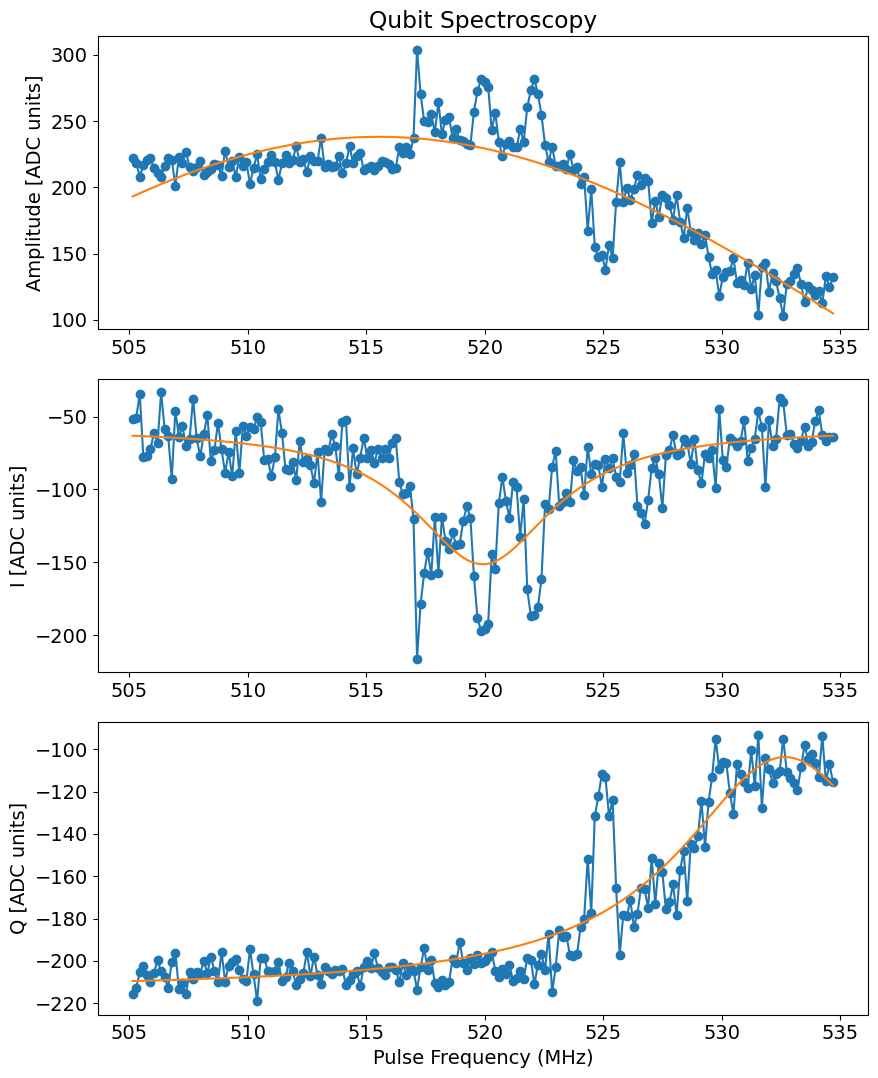

In [199]:
i = 1
spec = do_stor_spectroscopy(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no=1, stor_no=i+1)
analyze_and_display_stor_spectroscopy(spec)

### Man-dump

In [225]:
def get_dump_mode_parameters(ds_thisrun, config_thisrun, man_mode_no, dump_mode_no):
    """
    Get pulse parameters for a given storage mode. 
    Also returns prepulse and postpulse (single photon prep and meas for ge meas)

    Args:
        ds_thisrun: Dataset object for managing frequency data.
        config_thisrun: Configuration dictionary for the current run.
        man_mode_no: Manipulation mode number.
        dump_mode_no: Dump mode number.

    Returns:
        A tuple containing freq, gain, ch, prepulse, and postpulse.
    """
    freq = ds_thisrun.get_freq('M' + str(man_mode_no) + '-D' + str(dump_mode_no))
    gain = ds_thisrun.get_gain('M' + str(man_mode_no) + '-D' + str(dump_mode_no))
    ch = 'low' if freq < 1000 else 'high'

    from MM_dual_rail_base import MM_dual_rail_base
    mm_base_dummy = MM_dual_rail_base(config_thisrun)
    prep_man_pi = mm_base_dummy.prep_man_photon(man_mode_no)
    prepulse = mm_base_dummy.get_prepulse_creator(prep_man_pi).pulse.tolist()
    postpulse = mm_base_dummy.get_prepulse_creator(prep_man_pi[-1:-3:-1]).pulse.tolist() # for ge meas, only do f0g1 and ef pi

    return freq, gain, ch, prepulse, postpulse


def do_dump_spectroscopy(config_thisrun, ds_thisrun,  expt_path, config_path, man_mode_no = 1, dump_no = 1):
    """
    Run the Flux Spectroscopy F0g1 Experiment.

    This function performs a flux spectroscopy experiment to measure the transition frequency
    between the f0 and g1 states of a qubit. It configures the experiment parameters, executes
    the experiment, and saves the results.

    Args:
        config_thisrun (AttrDict): Configuration dictionary for the current run.
        ds_thisrun (dataset.storage_man_swap_dataset): Dataset object for managing frequency data.
        expt_path (str): Path to save the experiment results.
        config_path (str): Path to the configuration file.
        man_mode_no (int, optional): Manipulation mode number (default is 1).
        dump_no (int, optional): Storage mode number (default is 1).

    Returns:
        FluxSpectroscopyF0g1Experiment: The experiment object containing the results.
    """
    flux_spec = meas.single_qubit.rf_flux_spectroscopy_f0g1.FluxSpectroscopyF0g1Experiment(
        soccfg=soc, path=expt_path, prefix='FluxSpectroscopyF0g1Experiment', config_file=config_path
    )

    flux_spec.cfg = AttrDict(deepcopy(config_thisrun))

    freq, gain,ch, prepulse, postpulse = get_dump_mode_parameters(ds_thisrun, config_thisrun,
                                                                      man_mode_no, dump_no)

    flux_spec.cfg.expt = dict(
        start=freq - 5,  # Start RF frequency [MHz]
        step=0.05,  # Step size [MHz]
        expts=200,  # Number of experiments
        reps=200,  # Number of averages per point
        qubit=[0],
        flux_drive=[ch, 1,4000, 1],  # RF flux modulation parameters [low/high (ch), freq (will be overwritten), gain, length(us)]
        prepulse=True,
        postpulse=True,
        active_reset=False,
        pre_sweep_pulse= prepulse,
        post_sweep_pulse= postpulse,
    )

    flux_spec.cfg.device.readout.relax_delay = [500]  # Wait time between experiments [us]
    flux_spec.go(analyze=False, display=False, progress=True, save=True)
    return flux_spec


def update_dump_spectroscopy(flux_spec, ds_thisrun, man_mode_no = 1, dump_no = 1):
    """Update the configuration based on Flux Spectroscopy F0g1 experiment results."""
    # Update the dataset with the new frequency
    ds_thisrun.update_freq('M' + str(man_mode_no) + '-D' + str(dump_no), flux_spec.data['fit_avgi'][2])
    print(f"Updated frequency for M{man_mode_no}-D{dump_no}: {flux_spec.data['fit_avgi'][2]}")


  0%|          | 0/200 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00011_FluxSpectroscopyF0g1Experiment.h5
Found peak in amps at [MHz] 2313.500996625966, HWHM -0.14275933848924893
Found peak in I at [MHz] 2313.4991151732856, HWHM -0.17361788534605876
Found peak in Q at [MHz] 2315.8179483982244, HWHM -0.23541661584492962


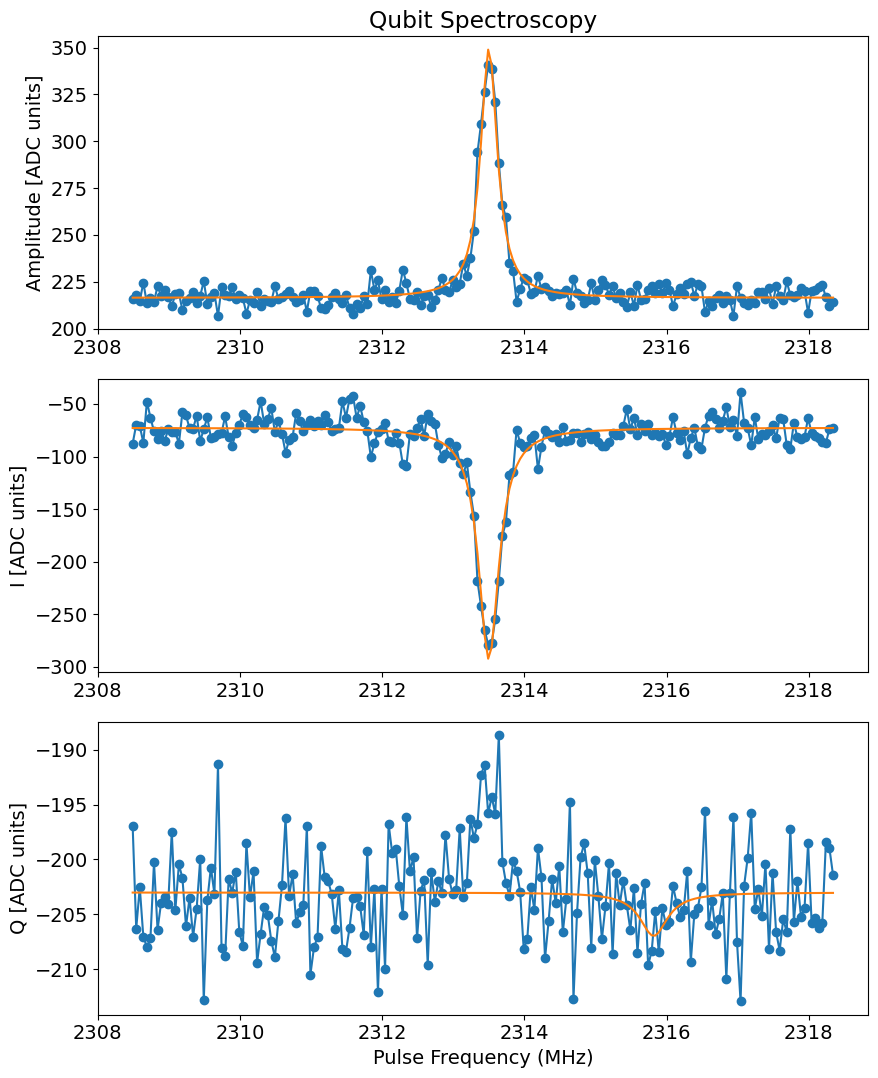

In [226]:
spec = do_dump_spectroscopy(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no=1, dump_no=1)
analyze_and_display_stor_spectroscopy(spec)

In [230]:
update_dump_spectroscopy(spec, ds_thisrun, man_mode_no = 1, dump_no = 1)
ds_thisrun.update_gain('M1-D1', 4000)

Updated frequency for M1-D1: 2313.4991151732856


## Find Frequency (Chevron)

In [141]:
def do_sideband_general_sweep(config_thisrun, ds_thisrun, expt_path, config_path, freq_start, freq_stop, freq_step,
                              man_mode_no = 1, stor_mode_no = 1, start_time = 0.007):
    """Run the Sideband General Sweep Experiment."""
    from multimode_expts.sequential_experiment_classes import sidebands_class
    experiment_class = sidebands_class
    sweep_experiment_name = 'sideband_general_sweep'
    class_for_exp = experiment_class(soccfg=soc, path=expt_path, prefix=sweep_experiment_name, config_file=config_path, exp_param_file=exp_param_file)

    class_for_exp.yaml_cfg = AttrDict(deepcopy(config_thisrun))
    # get pulse parameters for the given storage mode
    freq, gain, ch, prepulse, postpulse = get_storage_mode_parameters(ds_thisrun, config_thisrun, man_mode_no, stor_mode_no)
    
    class_for_exp.loaded[sweep_experiment_name] =  dict(
        start=start_time,  # Pulse start length [us]
        step=0.1,  # Pulse step length [us]
        qubits=[0],
        expts=100,
        reps=100,
        rounds=1,
        freq_start=freq_start,
        freq_stop=freq_stop,
        freq_step=freq_step,
        flux_drive=[ch, freq, gain, 0.05],  # RF flux modulation parameters [low/high (ch), freq (will be overwritten), gain, length(us)]
        prepulse=True,
        postpulse=True,
        active_reset=False,
        man_reset=True,
        storage_reset=True,
        update_post_pulse_phase=[False, 1.07],
        pre_sweep_pulse= prepulse,
        post_sweep_pulse= postpulse,
    )
    class_for_exp.yaml_cfg.device.readout.relax_delay = [8000]  # Wait time between experiments [us]

    return eval('class_for_exp.run_sweep')( sweep_experiment_name = sweep_experiment_name)


def update_sideband_general_sweep(expt_path, config_thisrun, ds_thisrun, man_mode_no=1, stor_mode_no=1):
    """Update sweep data and analyze results."""
    temp_data, attrs, filename = prev_data(expt_path, prefix='sideband_general_sweep')
    print('File saved at:', filename)

    from multimode_expts.fit_display_classes import ChevronFitting
    from datetime import datetime
    chevron_analysis = ChevronFitting(
        frequencies=temp_data['freq_sweep'],
        time=temp_data['xpts'][0],
        response_matrix=temp_data['avgi']
    )
    chevron_analysis.analyze()
    
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    chevron_analysis.display_results(save_fig=True, directory=autocalib_path, title=f'M{man_mode_no}-S{stor_mode_no}_{current_time}')

    # Update dataset
    ds_thisrun.update_freq('M' + str(man_mode_no) + '-S' + str(stor_mode_no),chevron_analysis.results['best_frequency_contrast'])
    print('Updated the frequency to:', chevron_analysis.results['best_frequency_contrast'])
    return chevron_analysis

Fitting basically doesn't work when starting from say 20us for a fine sweep, where the chevron is narrower than starting from 0us. Doing things by eye atm.

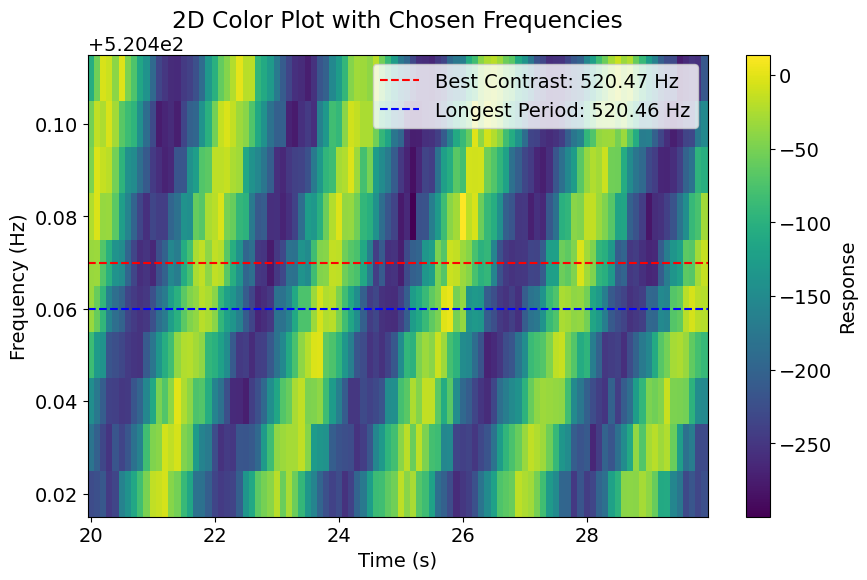

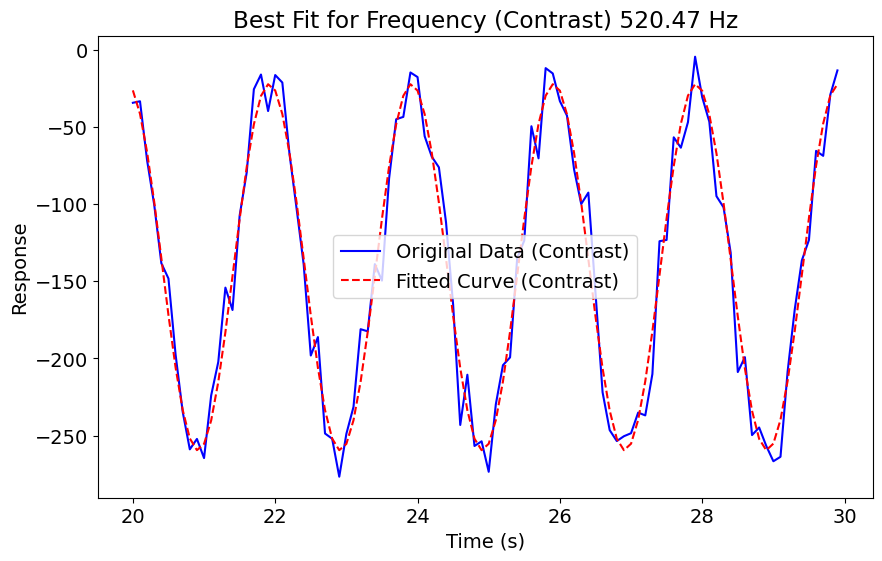

Index: 10 Freq. = 520.5199999999999 MHz
Waiting for 8000 us


KeyboardInterrupt: 

In [160]:
sideband_chevrons_coarse = [None] * len(expts_to_run['stor_modes'])
sideband_chevrons_fine = [None] * len(expts_to_run['stor_modes'])

for i in range(len(expts_to_run['stor_modes'])):
    if expts_to_run['sideband_freq_sweep']:
        # print(f'Running coarse sideband sweep for storage mode {i + 1}')
        # freq_start = ds_thisrun.get_freq('M1-S' + str(i + 1)) - 2
        # freq_stop = ds_thisrun.get_freq('M1-S' + str(i + 1)) + 2
        # freq_step = 0.2
        # sideband_chevrons_coarse[i] = do_sideband_general_sweep(config_thisrun, ds_thisrun, expt_path, config_path, freq_start, freq_stop, freq_step, man_mode_no=1, stor_mode_no=i + 1)
        # update_sideband_general_sweep(expt_path, config_thisrun, ds_thisrun, man_mode_no=1, stor_mode_no=i + 1)

        print(f'Running fine sideband sweep for storage mode {i + 1}')
        freq_start = ds_thisrun.get_freq('M1-S' + str(i + 1)) - 0.2
        freq_stop = ds_thisrun.get_freq('M1-S' + str(i + 1)) + 0.2
        freq_step = 0.01
        sideband_chevrons_fine[i] = do_sideband_general_sweep(
            config_thisrun, ds_thisrun, expt_path, config_path, freq_start, freq_stop, freq_step, 
            man_mode_no=1, stor_mode_no=i + 1, start_time=20)
        update_sideband_general_sweep(expt_path, config_thisrun, ds_thisrun, man_mode_no=1, stor_mode_no=i + 1)

### Manually get the frequencies from the chevrons

In [204]:
# file_list = np.arange(42,50, 1)
# chevrons_stor_objects = [None]* len(file_list)
# name = '_sideband_general_sweep.h5'
# # name = '_storage_sideband_sweep.h5'
# for idx, file_no in enumerate(file_list):
#     full_name = str(file_no).zfill(5)+name
#     expt_path_mod = r"H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data"
#     temp_data, attrs, filename = prev_data(expt_path_mod, full_name)  # ef

#     from multimode_expts.fit_display_classes import ChevronFitting
#     chevron_analysis = ChevronFitting(
#         frequencies=temp_data['freq_sweep'],
#         time=temp_data['xpts'][0],
#         response_matrix=temp_data['avgi']
#     )
#     chevrons_stor_objects[idx] = chevron_analysis

c:\Users\26049\.conda\envs\slab\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\_Lib\python\multimode_expts\fit_display_classes.py:710: RuntimeWarning: overflow encountered in exp
  return A * np.sin(omega * t + phi) * np.exp(-t / tau) + C
C:\_Lib\python\multimode_expts\fit_display_classes.py:710: RuntimeWarning: overflow encountered in multiply
  return A * np.sin(omega * t + phi) * np.exp(-t / tau) + C


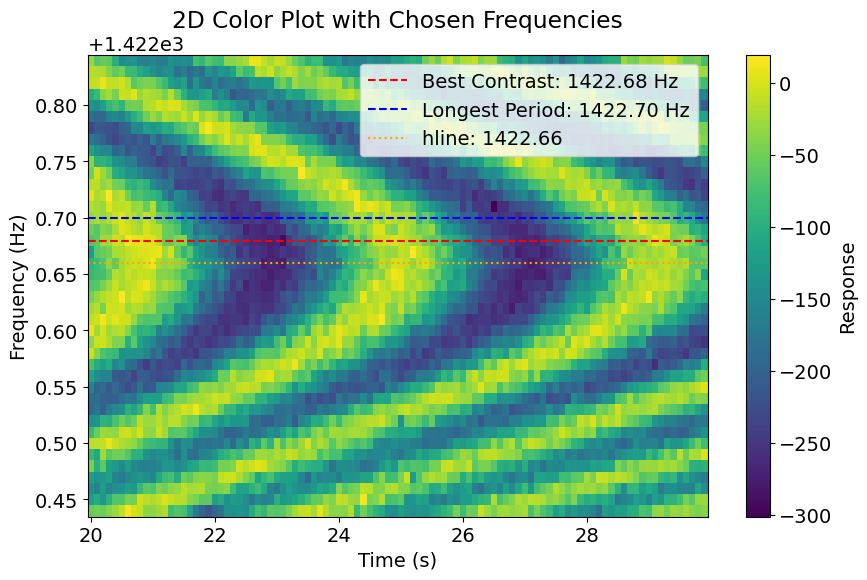

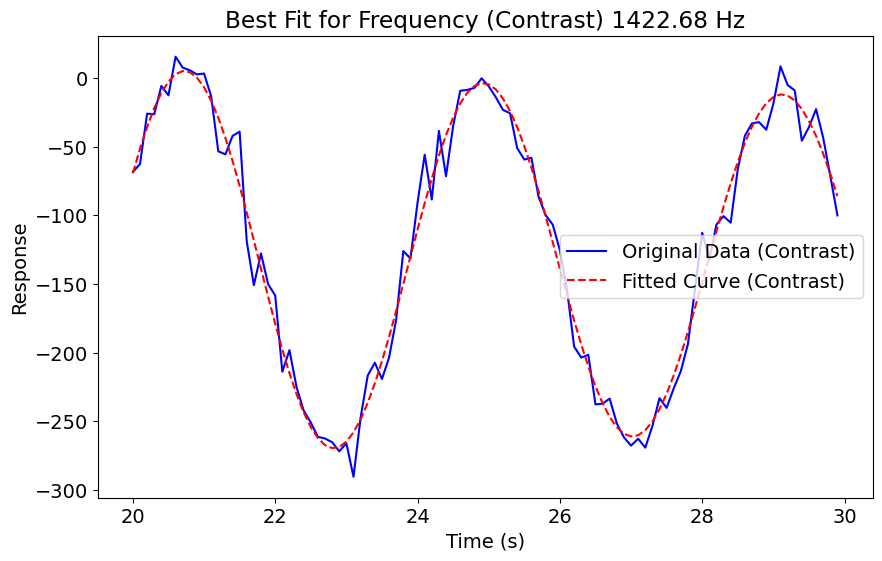

In [ ]:
# i = 7
# guess_freq = 1422.66
# chevrons_stor_objects[i].analyze()
# chevrons_stor_objects[i].display_results(save_fig=False, directory=autocalib_path, title=f'M1-S2_{0}', hlines = [guess_freq])

In [ ]:

# ds_thisrun.update_freq('M1-S' + str(i), guess_freq)

In [118]:
ds_thisrun.get_freq('M1-S3')

696.35

## Sideband General

In [142]:
def do_sideband_general(config_thisrun, expt_path, config_path, man_mode_no = 1,stor_mode_no=1):
    """Run the Sideband General Experiment."""
    
    sideband_general = meas.single_qubit.sideband_general.SidebandGeneralExperiment(
        soccfg=soc, path=expt_path, prefix='SidebandGeneralExperiment', config_file=config_path
    )

    sideband_general.cfg = AttrDict(deepcopy(config_thisrun))

    # Sideband general experiment parameters
    freq, gain, ch, prepulse, postpulse = get_storage_mode_parameters(ds_thisrun, config_thisrun, man_mode_no, stor_mode_no)

    sideband_general.cfg.expt = dict(
        start=0.007,  # Pulse start length [us]
        step=0.05,  # Pulse step length [us]
        qubits=[0],
        expts=100,
        reps=200,
        rounds=1,
        flux_drive=[ch, freq, gain],  # RF flux modulation
        prepulse=True,
        postpulse=True,
        active_reset=False,
        man_reset=True,
        storage_reset=True,
        update_post_pulse_phase=[False, 1.07],
        pre_sweep_pulse=prepulse,
        post_sweep_pulse=postpulse,
    )

    sideband_general.cfg.device.readout.relax_delay = [8000]  # Wait time between experiments [us]
    sideband_general.go(analyze=False, display=False, progress=True, save=True)
    from multimode_expts.fit_display_classes import LengthRabiFitting
    sideband_analysis = LengthRabiFitting(sideband_general.data, config=sideband_general.cfg)
    sideband_analysis.analyze()
    sideband_analysis.display(title_str='Sideband General', save_fig=True)

    return sideband_analysis


def update_sideband_general(sideband_general, config_thisrun, ds, man_mode_no=1, stor_mode_no=1):
    """Update the configuration and dataset based on Sideband General experiment results."""
    # Analyze the data
    

    # Update dataset
    pi_length = sideband_general.results['pi_length']
    pi2_length = sideband_general.results['pi2_length']
    gain = sideband_general.cfg.expt['flux_drive'][2]
    freq = sideband_general.cfg.expt['flux_drive'][1]
    ds.update_all('M' + str(man_mode_no) + '-S' + str(stor_mode_no), freq, np.nan, pi_length, pi2_length, gain)
    print(f'Updated configuration and dataset: pi_length={pi_length}, pi2_length={pi2_length}, gain={gain}')



Running sideband general for manipulation mode 1 and storage mode 1


  0%|          | 0/100 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00005_SidebandGeneralExperiment.h5
p1: 0.5134535850523158
p2: 91.72609536292715
Pi length: 0.9644597001072244
Pi/2 length: 0.4775607723793607
p1: 0.27682065009462103
p2: -22.319468844010007
Pi length: 1.12707821638324
Pi/2 length: 0.2239664004311186


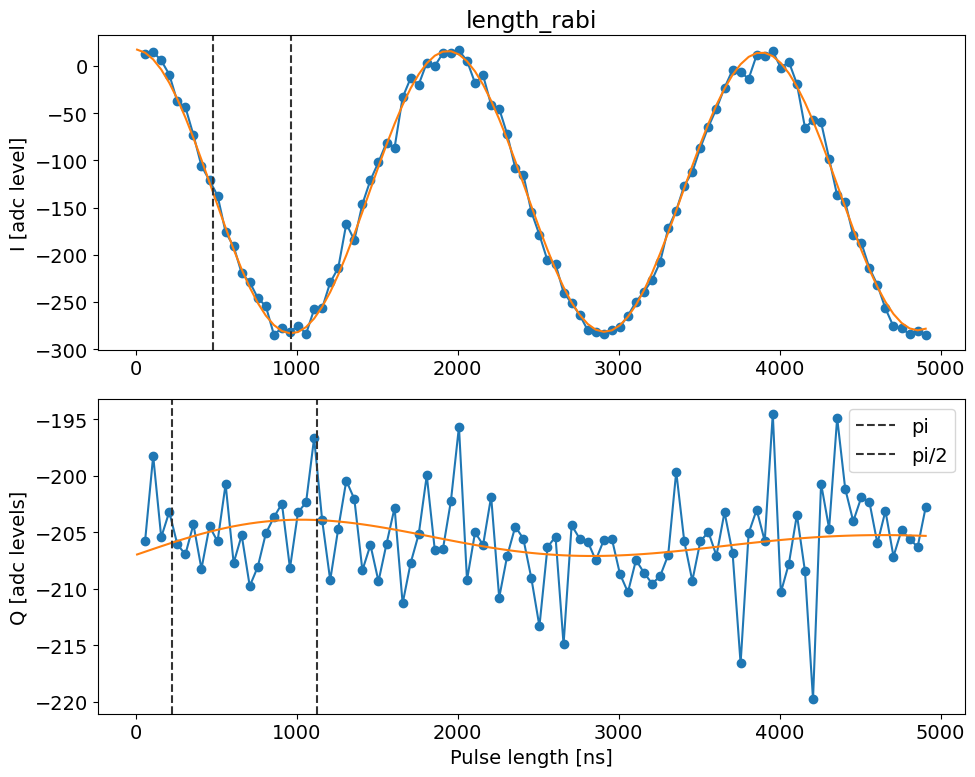

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-25_13-58-23_Sideband_General.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-25.md
Updated configuration and dataset: pi_length=0.9644597001072244, pi2_length=0.4775607723793607, gain=3000
Running sideband general for manipulation mode 1 and storage mode 2


  0%|          | 0/100 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00006_SidebandGeneralExperiment.h5
Attempted to init fitparam 1 to 5.858585858585858, which is out of bounds 0.02040816326530612 to 3.061224489795918. Instead init to 1.540816326530612
p1: 0.4454259983211033
p2: 89.22855894309536
Pi length: 1.1273317985869902
Pi/2 length: 0.5660713401891905
p1: 1.522933486506496
p2: -34.89661091644842
Pi length: 0.22780707982153098
Pi/2 length: 0.06365020612018327


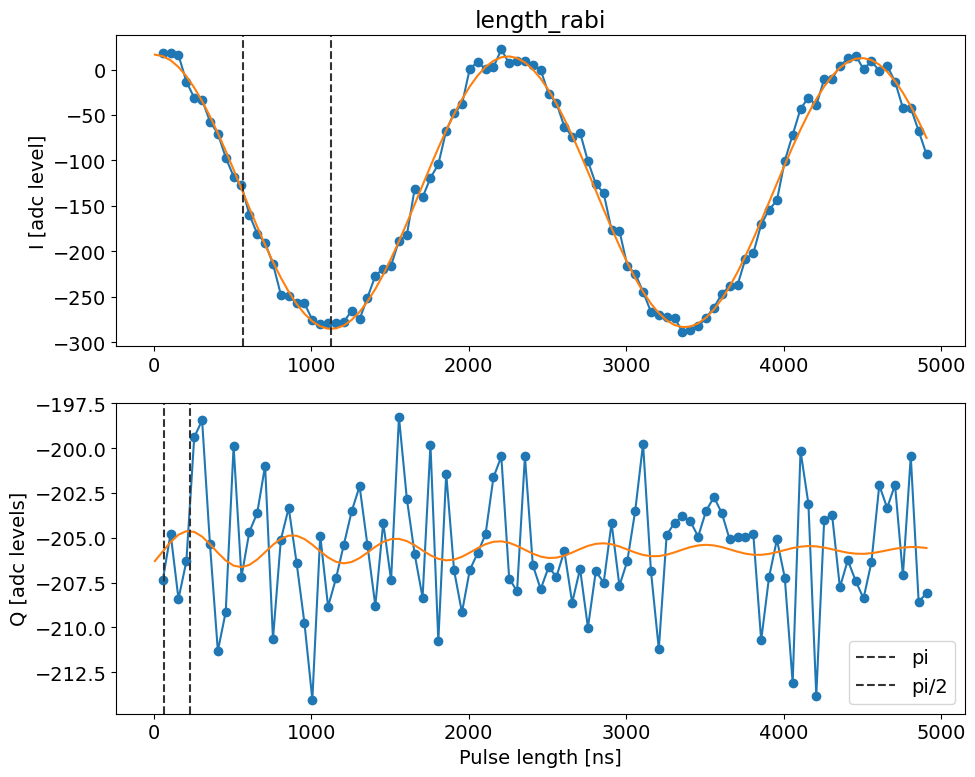

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-25_14-01-11_Sideband_General.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-25.md
Updated configuration and dataset: pi_length=1.1273317985869902, pi2_length=0.5660713401891905, gain=5000
Running sideband general for manipulation mode 1 and storage mode 3


  0%|          | 0/100 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00007_SidebandGeneralExperiment.h5
Attempted to init fitparam 1 to 3.2323232323232323, which is out of bounds 0.02040816326530612 to 3.061224489795918. Instead init to 1.540816326530612
p1: 0.37582756813152984
p2: 89.73227398313189
Pi length: 1.3323761369334728
Pi/2 length: 0.6671774628635958
p1: 1.5553111600360081
p2: 80.78294118242191
Pi length: 0.3379406993696171
Pi/2 length: 0.17720115964033745


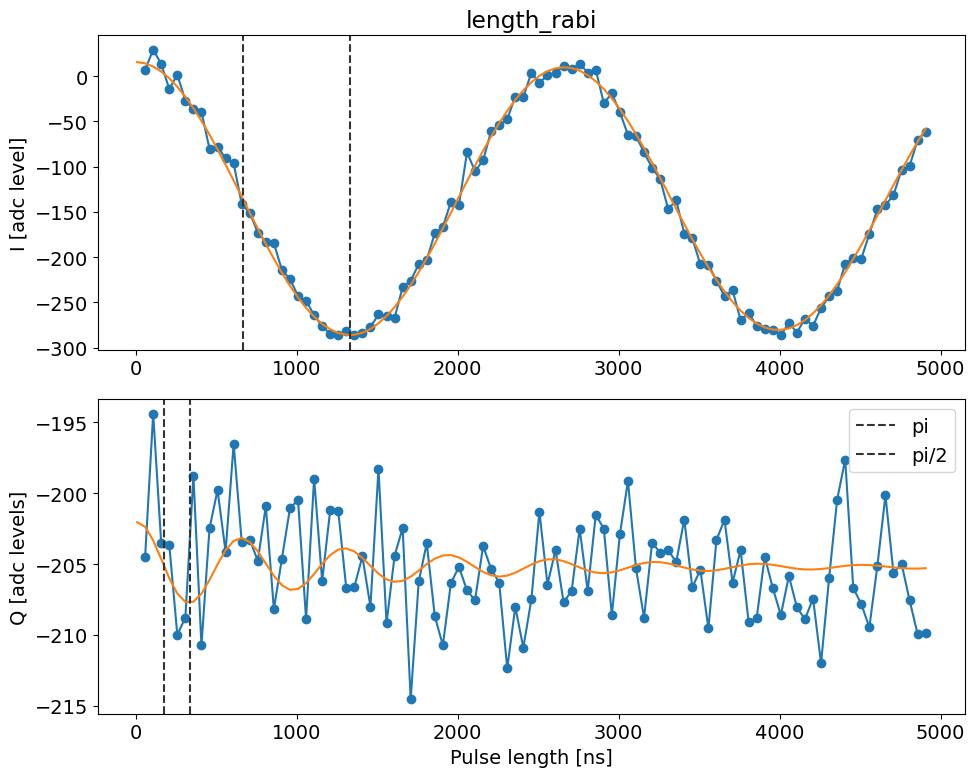

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-25_14-03-59_Sideband_General.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-25.md
Updated configuration and dataset: pi_length=1.3323761369334728, pi2_length=0.6671774628635958, gain=9000
Running sideband general for manipulation mode 1 and storage mode 4


  0%|          | 0/100 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00008_SidebandGeneralExperiment.h5
Attempted to init fitparam 1 to 7.6767676767676765, which is out of bounds 0.02040816326530612 to 3.061224489795918. Instead init to 1.540816326530612
p1: 0.4000446807582878
p2: 90.804342796794
Pi length: 1.2442752982237664
Pi/2 length: 0.6193451041111411
p1: 1.929412123906772
p2: 179.08776033319472
Pi length: 0.13088649954324708
Pi/2 length: 0.0013133529343270223


supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-25_14-06-47_Sideband_General.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-25.md
Updated configuration and dataset: pi_length=1.2442752982237664, pi2_length=0.6193451041111411, gain=9000
Running sideband general for manipulation mode 1 and storage mode 5


  0%|          | 0/100 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00009_SidebandGeneralExperiment.h5
Attempted to init fitparam 1 to 6.0606060606060606, which is out of bounds 0.02040816326530612 to 3.061224489795918. Instead init to 1.540816326530612
p1: 0.252871712536562
p2: 91.86006886309355
Pi length: 1.9568544740860088
Pi/2 length: 0.9682108749572481
p1: 1.7189124080622515
p2: -104.3516776698885
Pi length: 0.31407404401358785
Pi/2 length: 0.16863324154603937


supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-25_14-09-35_Sideband_General.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-25.md
Updated configuration and dataset: pi_length=1.9568544740860088, pi2_length=0.9682108749572481, gain=7500
Running sideband general for manipulation mode 1 and storage mode 6


  0%|          | 0/100 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00010_SidebandGeneralExperiment.h5
p1: 0.31268210067921
p2: 90.90139509313003
Pi length: 1.5910604529668992
Pi/2 length: 0.7915263592117772
p1: 0.24295957112790229
p2: 20.597671151572932
Pi length: 2.851438383699158
Pi/2 length: 1.8224606042298679


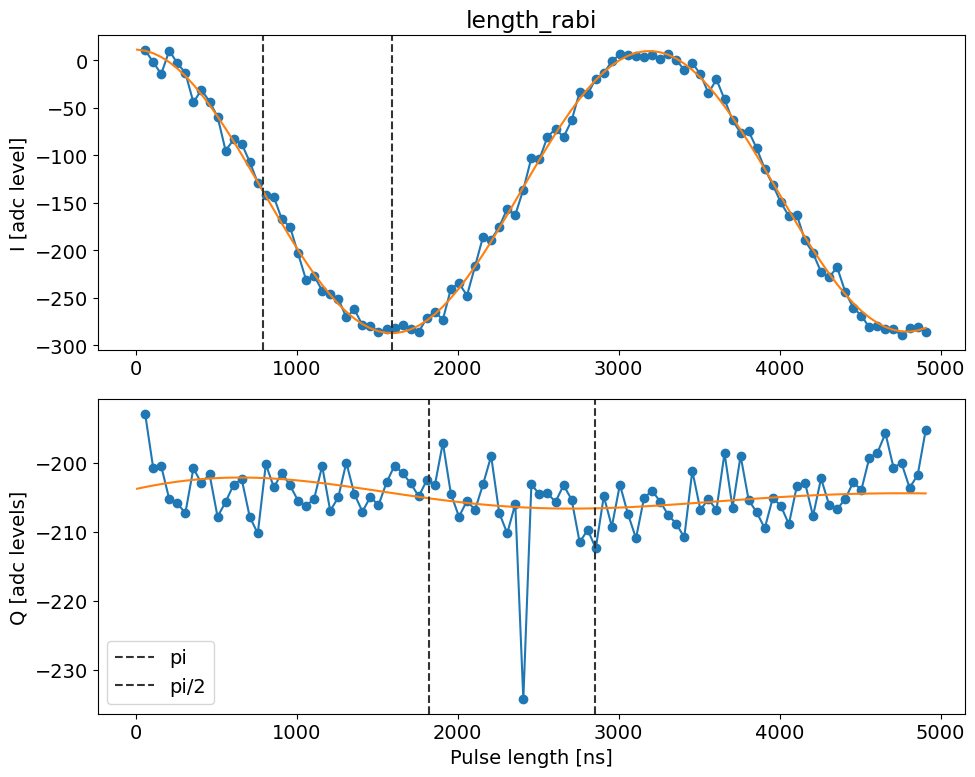

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-25_14-12-22_Sideband_General.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-25.md
Updated configuration and dataset: pi_length=1.5910604529668992, pi2_length=0.7915263592117772, gain=13500
Running sideband general for manipulation mode 1 and storage mode 7


  0%|          | 0/100 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00011_SidebandGeneralExperiment.h5
Attempted to init fitparam 1 to 6.262626262626262, which is out of bounds 0.02040816326530612 to 3.061224489795918. Instead init to 1.540816326530612
p1: 0.22289727482743538
p2: 89.15029246276846
Pi length: 2.2537749692249665
Pi/2 length: 1.1321820731541319
p1: 1.2453553451579744
p2: 157.8538226434694
Pi length: 0.25014319048366057
Pi/2 length: 0.049397274089583276


supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-25_14-15-10_Sideband_General.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-25.md
Updated configuration and dataset: pi_length=2.2537749692249665, pi2_length=1.1321820731541319, gain=10000


In [143]:
len_rabi_storages = [None]* len(expts_to_run['stor_modes'])
if expts_to_run['sideband_length_rabi']:
    for man_mode_no in expts_to_run['man_modes']:
        for stor_mode_no in expts_to_run['stor_modes']:
            print(f'Running sideband general for manipulation mode {man_mode_no} and storage mode {stor_mode_no}')
            len_rabi_storages[stor_mode_no-1] = do_sideband_general(config_thisrun, expt_path, config_path, man_mode_no, stor_mode_no)
            update_sideband_general(len_rabi_storages[stor_mode_no-1], config_thisrun, ds_thisrun, man_mode_no, stor_mode_no)


  0%|          | 0/100 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00004_SidebandGeneralExperiment.h5
Attempted to init fitparam 1 to 7.474747474747475, which is out of bounds 0.02040816326530612 to 3.061224489795918. Instead init to 1.540816326530612
p1: 0.5156139789528535
p2: 89.44622025936214
Pi length: 0.9727010855599528
Pi/2 length: 0.4878422372647258
p1: 1.1928488211637922
p2: -175.8385207680922
Pi length: 0.6190560969381436
Pi/2 length: 0.40947379651210153


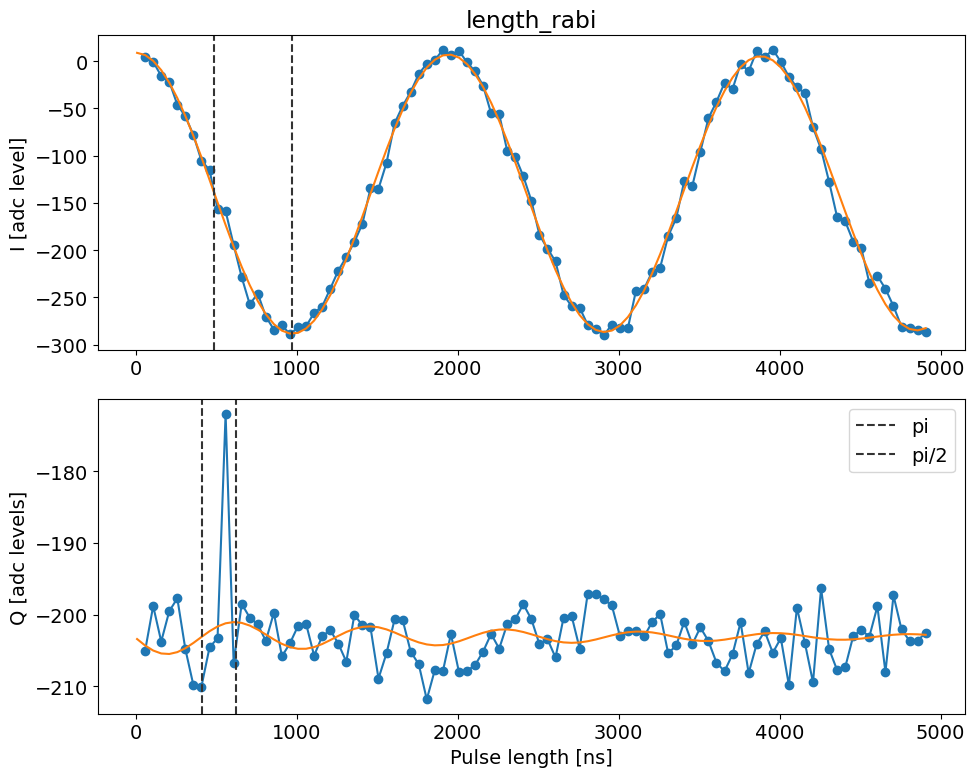

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-23_13-48-55_Sideband_General.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-23.md
Updated configuration and dataset: pi_length=0.9727010855599528, pi2_length=0.4878422372647258, gain=3000


In [ ]:
# stor_mode_no = 1
# man_mode_no = 1
# len_rabi_storage = do_sideband_general(config_thisrun, expt_path, config_path, man_mode_no, stor_mode_no)
# update_sideband_general(len_rabi_storage, config_thisrun, ds_thisrun, man_mode_no, stor_mode_no)

## Randomized Benchmarking

In [24]:
len([1, 5, 10, 15, 25, 50, 75, 100, 150, 200, 250, 400, 500, 600, 700, 850, 1000, 1250, 1500])

19

In [153]:
config_thisrun.device.storage.ramp_sigma
man_mode_no = 1
stor_mode_no = 7
req = ds_thisrun.get_freq('M' + str(man_mode_no) + '-S' + str(stor_mode_no))
gain = ds_thisrun.get_gain('M' + str(man_mode_no) + '-S' + str(stor_mode_no))
hpi_length = ds_thisrun.get_h_pi('M' + str(man_mode_no) + '-S' + str(stor_mode_no))
print("ramp_sigma:", config_thisrun.device.storage.ramp_sigma)
print("man_mode_no:", man_mode_no)
print("stor_mode_no:", stor_mode_no)
print("freq:", req)
print("gain:", gain)
print("hpi_length:", hpi_length)

ramp_sigma: 0.005
man_mode_no: 1
stor_mode_no: 7
freq: 1422.66
gain: 10000
hpi_length: 1.1321820731541319


In [144]:


def do_single_beam_splitter_rb_postselection_sweep_depth(config_thisrun, ds_thisrun, expt_path, config_path, exp_param_file, man_mode_no=1, stor_mode_no=1,
                                                         prev_data=None):
    """
    Run the SingleBeamSplitterRBPostSelection_sweep_depth experiment.
    """
    from multimode_expts.sequential_experiment_classes import MM_DualRailRB
    experiment_class = MM_DualRailRB
    sweep_experiment_name = 'SingleBeamSplitterRBPostSelection_sweep_depth'
    class_for_exp = experiment_class(
        soccfg=soc, path=expt_path, prefix=sweep_experiment_name, config_file=config_path, exp_param_file=exp_param_file, 
        prev_data=prev_data
    )

    class_for_exp.yaml_cfg = AttrDict(deepcopy(config_thisrun))
    # Customize bs_para for the given manipulation and storage mode using ds_thisrun directly
    freq = ds_thisrun.get_freq('M' + str(man_mode_no) + '-S' + str(stor_mode_no))
    gain = ds_thisrun.get_gain('M' + str(man_mode_no) + '-S' + str(stor_mode_no))
    hpi_length = ds_thisrun.get_h_pi('M' + str(man_mode_no) + '-S' + str(stor_mode_no))
    bs_para = [freq, gain, hpi_length, config_thisrun.device.storage.ramp_sigma]
    print('Beam splitter parameters:', bs_para)
    # Optionally, set up experiment parameters here if needed, e.g.:
    # class_for_exp.loaded[sweep_experiment_name] = dict(...)
    class_for_exp.loaded[sweep_experiment_name] = dict(
        depth_list=[1, 5, 10, 15, 25, 50, 75, 100, 150, 200, 250, 400, 500, 600, 700, 850, 1000, 1250, 1500, 2000],  # RB sequence depth list
        reps_list = [],
        qubits=[0],
        reps=0,  # doesn't matter

        single_shot_bef_expt=False,  # single shot before experiment
        singleshot_reps=2000,        # single shot measurement repetitions
        span=1000,                   # single shot plot span

        active_reset=False,          # for single shot post selection
        man_reset=True,              # for single shot post selection
        storage_reset=True,          # for single shot post selection
        threshold=None,              # for single shot post selection
        readout_per_round=4,         # for single shot post selection

        rb_active_reset=False,
        rb_man_reset=True,
        rb_storage_reset=True,
        rb_reps=1000,
        gates_per_wait=100000,       # ????
        parity_meas=True,            # If parity measurement is used, set to True; if False the reset arguments below should be false as well
        reset_qubit_after_parity=False,  # True # resetting via second parity str 
        reset_qubit_via_active_reset_after_first_meas=False,  # resetting via active reset after first parity str; the other reset should be false

        rounds=1,                    # always set to 1
        variations=10,                # number of different sequences
        rb_depth=10,                 # rb sequence depth
        IRB_gate_no=-1,              # IRB gate number, -1 means not using
        postselection_delay=2.0,     # in us, gap between two readout pulses
        bs_repeat=1,
        sync=False,
        setup=False,

        bs_para=bs_para,  # at 96  # beam splitter parameters [[frequency], [gain], [length (us)], [sigma]]
        prepulse=False,
        postpulse=False,
        f0g1_offset=0,               # offset phase in deg as a result of f0g1 prepulse/postpulse

        pre_sweep_pulse=[[None]],    # Gate based; prep f0g1 is done automatically ; RAM state prep is also automatic 
        ram_prepulse=[False, 6, [1], 1],  # [True/False, number of storage modes to be populated, [idx of modes to be skipped], variations]
        ram_prepulse_strs=None       # see SingleBeamSplitterRBPostSelection_sweep_depth_and_ram
    )
    

    class_for_exp.yaml_cfg.device.readout.relax_delay = [8000]  # Example, adjust as needed

    prefix, dir_path =eval('class_for_exp.run_sweep')(sweep_experiment_name=sweep_experiment_name)
    print('File saved at:', prefix)
    print('Directory path:', dir_path)

    # from multimode_expts.fit_display_classes import MM_DualRailRBFitting
    # rb_analysis = MM_DualRailRBFitting(
    #     filename=None,
    #     file_prefix=prefix,
    #     config=yaml_cfg,
    #     expt_path=expt_path,
    #     title=f'M{man_mode_no}-S{stor_mode_no}',
    #     prev_data=prev_data,
    #     dir_path=dir_path
    # )
    # rb_analysis.show_rb(save_fig=True)
    # return rb_analysis





In [146]:
storage_rbs = [None] * len(expts_to_run['stor_modes'])
for i in range(len(expts_to_run['stor_modes'])):
    print(f'Running storage RB postselection sweep depth for storage mode {i + 1}')
    storage_rbs[i] = do_single_beam_splitter_rb_postselection_sweep_depth(
        config_thisrun,
        ds_thisrun,
        expt_path,
        config_path,
        exp_param_file=exp_param_file,
        man_mode_no=1,
        stor_mode_no=i + 1
    )

RBAnalysis args:
  filename: None
  file_prefix: SingleBeamSplitterRBPostSelection_sweep_depth
  config: {'device': {'qubit': {'T1': [370.2930190133963], 'f_ge': [3569.4263053206314], 'f_ef': [3426.287416084909], 'ramp_sigma': [0.005], 'ramp_sigma_num': [3.0], 'pulses': {'pi_ge': {'gain': [11165], 'sigma': [0.035], 'length': [0.0], 'type': 'gauss'}, 'hpi_ge': {'gain': [5289], 'length': [0.0], 'sigma': [0.035], 'type': 'gauss'}, 'pi_ef': {'gain': [8590], 'length': [0.0], 'sigma': [0.035], 'type': 'gauss'}, 'hpi_ef': {'gain': [4060], 'sigma': [0.035], 'type': 'gauss'}}, 'T1_ef': [167.5647128005103]}, 'readout': {'trig_offset': 450, 'frequency': [748.8], 'gain': [800], 'phase': [0.8473846167680859], 'threshold': [-148.02027429647023], 'threshold_list': [[-148.02027429647023]], 'man1_drive_list': [0.0], 'man2_drive_list': [0.0], 'readout_length': [1], 'relax_delay': [8000], 'confusion_matrix_with_reset': [0.9964530022802125, 0.0035469977197875036, 0.013768302080657598, 0.9862316979193424],

In [152]:
0.9972**(3/2)

0.9958029413734426

filenames: ['00000_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00001_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00002_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00003_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00004_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00005_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00006_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00007_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00008_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00009_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00010_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00011_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00012_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00013_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00014_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00015_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00016_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '0

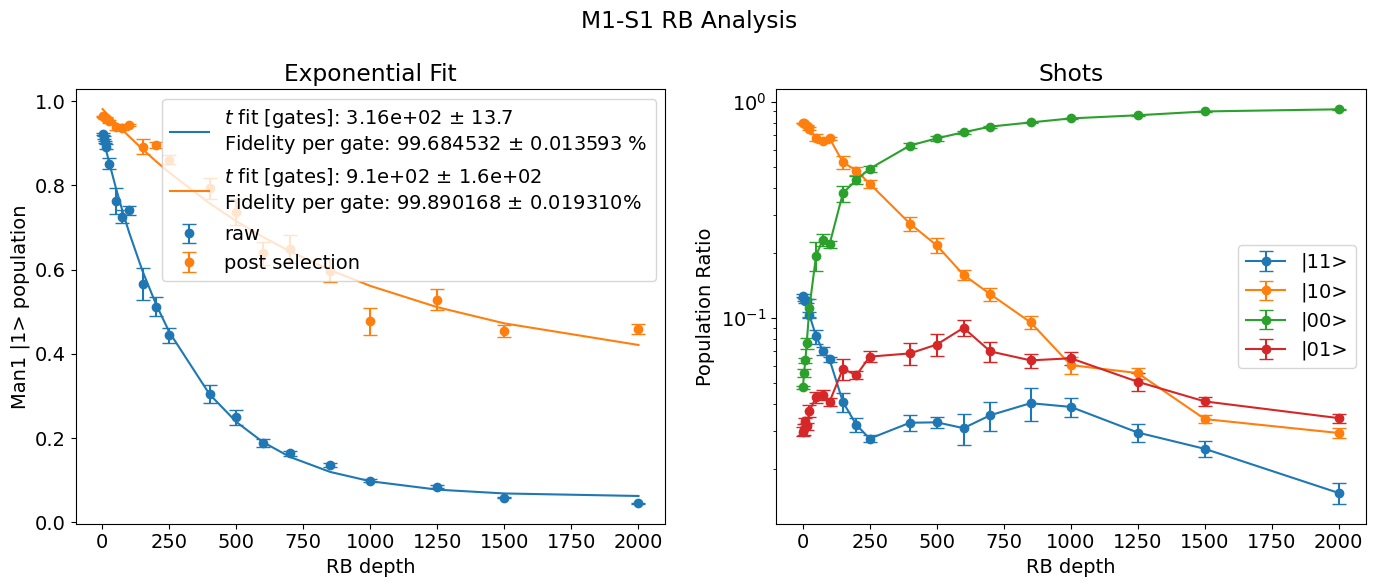

supertitle is  Text(0.5, 0.98, 'M1-S1 RB Analysis')
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-26_08-53-52_M1-S1_RB_Analysis.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-26.md
filenames: ['00000_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00001_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00002_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00003_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00004_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00005_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00006_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00007_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00008_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00009_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00010_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00011_SingleBeamSplitterRBPostSelection_sweep_d

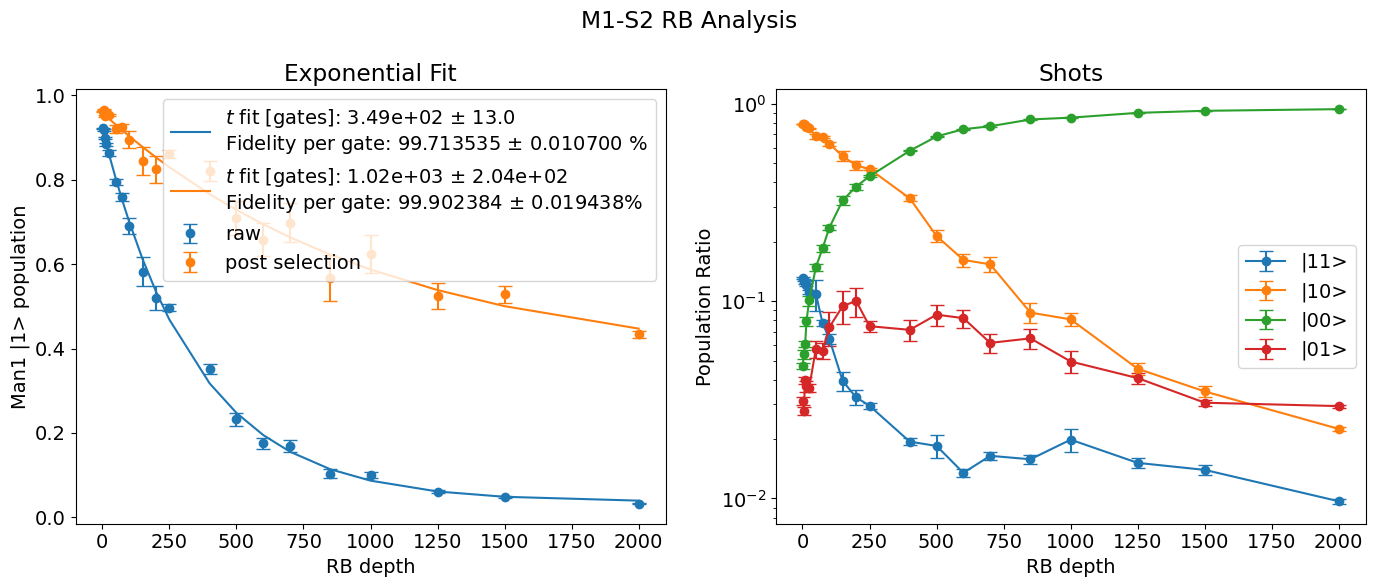

supertitle is  Text(0.5, 0.98, 'M1-S2 RB Analysis')
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-26_08-54-05_M1-S2_RB_Analysis.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-26.md
filenames: ['00000_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00001_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00002_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00003_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00004_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00005_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00006_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00007_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00008_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00009_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00010_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00011_SingleBeamSplitterRBPostSelection_sweep_d

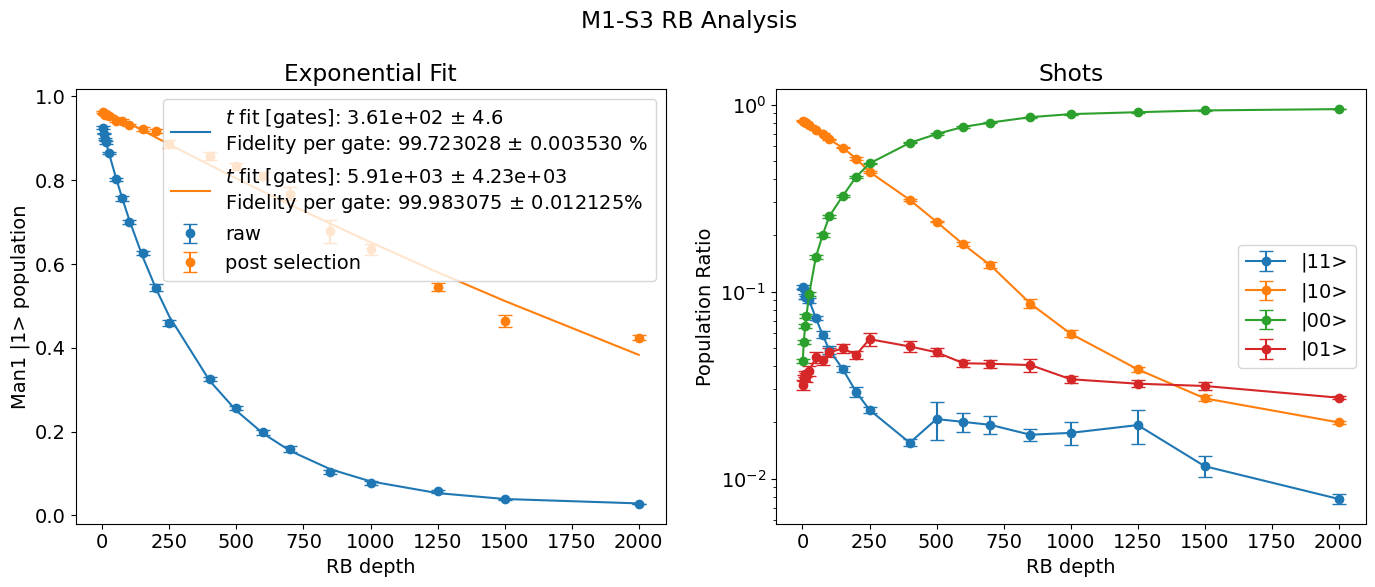

supertitle is  Text(0.5, 0.98, 'M1-S3 RB Analysis')
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-26_08-54-18_M1-S3_RB_Analysis.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-26.md
filenames: ['00000_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00001_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00002_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00003_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00004_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00005_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00006_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00007_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00008_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00009_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00010_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00011_SingleBeamSplitterRBPostSelection_sweep_d

C:\_Lib\python\multimode_expts\experiments\fitting.py:55: RuntimeWarning: overflow encountered in exp
  return y0 + yscale*np.exp(-(x-x0)/decay)


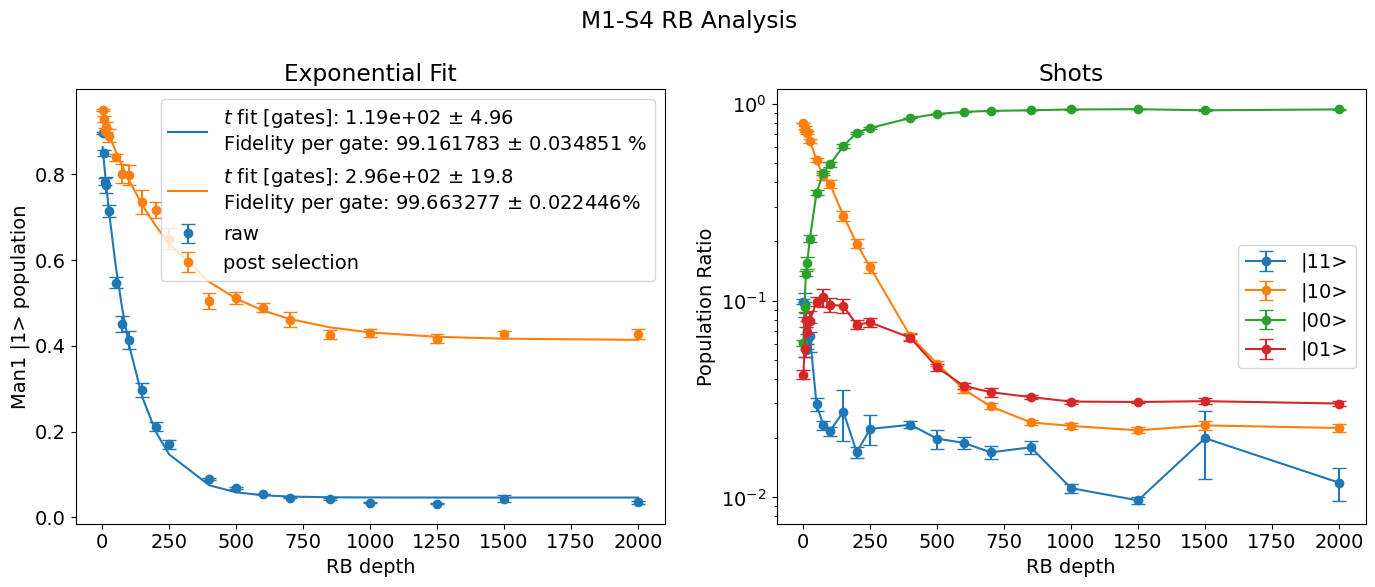

supertitle is  Text(0.5, 0.98, 'M1-S4 RB Analysis')
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-26_08-54-33_M1-S4_RB_Analysis.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-26.md
filenames: ['00000_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00001_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00002_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00003_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00004_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00005_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00006_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00007_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00008_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00009_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00010_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00011_SingleBeamSplitterRBPostSelection_sweep_d

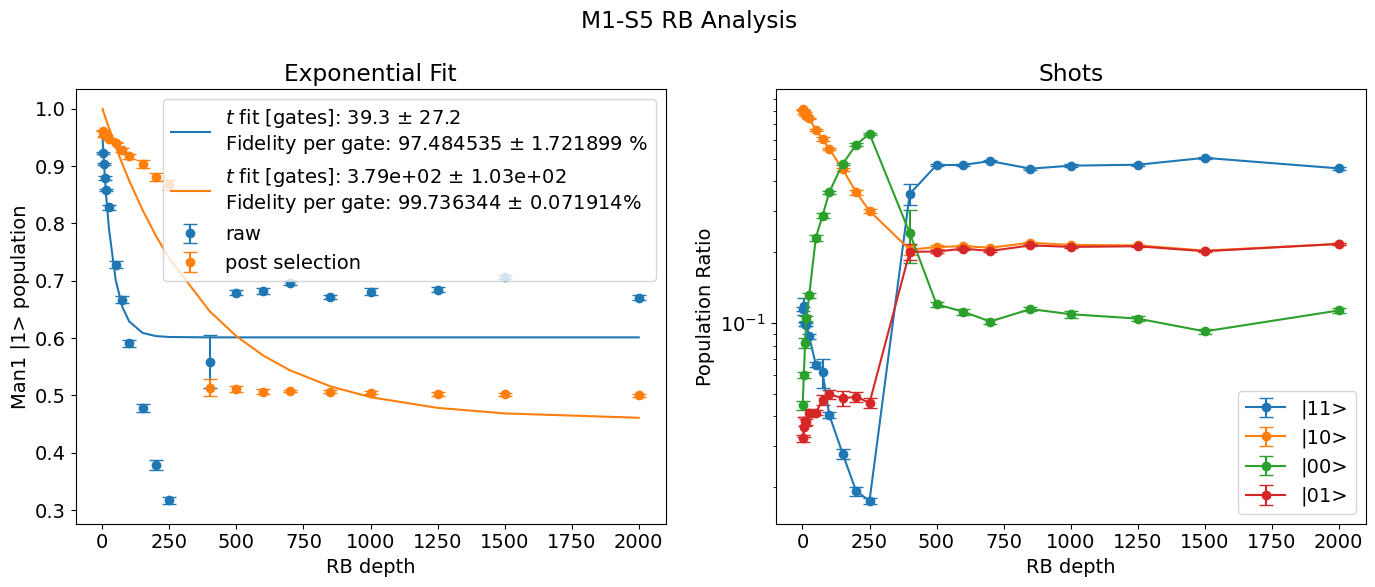

supertitle is  Text(0.5, 0.98, 'M1-S5 RB Analysis')
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-26_08-54-46_M1-S5_RB_Analysis.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-26.md
filenames: ['00000_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00001_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00002_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00003_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00004_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00005_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00006_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00007_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00008_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00009_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00010_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00011_SingleBeamSplitterRBPostSelection_sweep_d

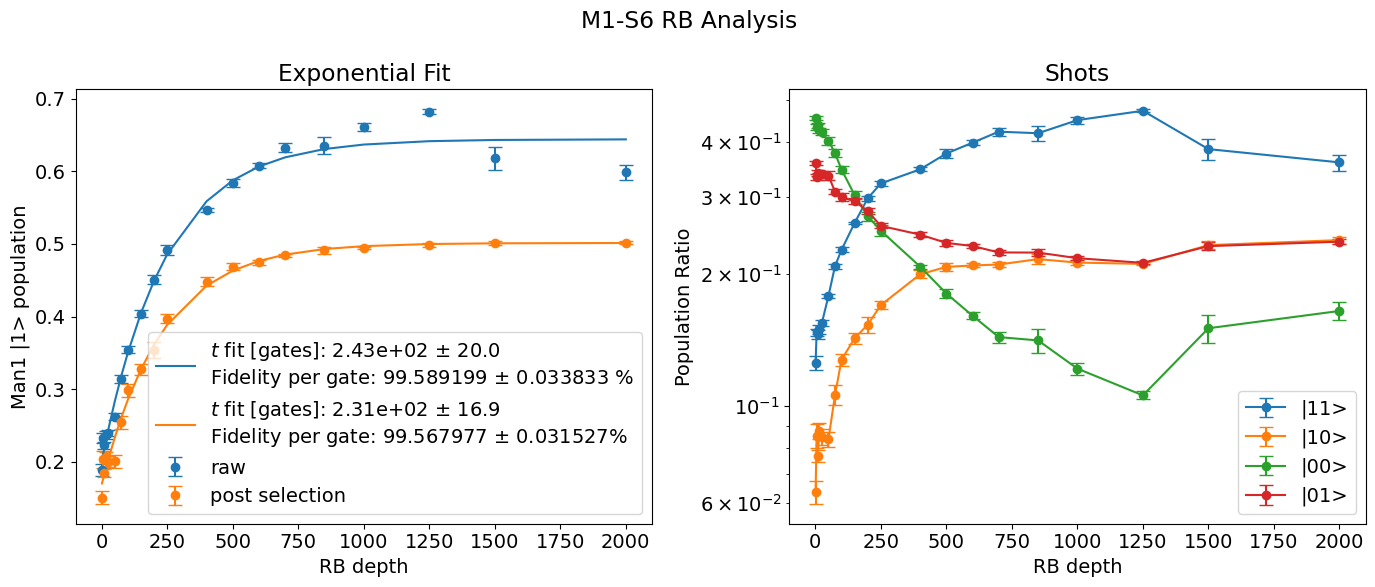

supertitle is  Text(0.5, 0.98, 'M1-S6 RB Analysis')
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-26_08-54-58_M1-S6_RB_Analysis.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-26.md
filenames: ['00000_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00001_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00002_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00003_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00004_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00005_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00006_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00007_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00008_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00009_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00010_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00011_SingleBeamSplitterRBPostSelection_sweep_d

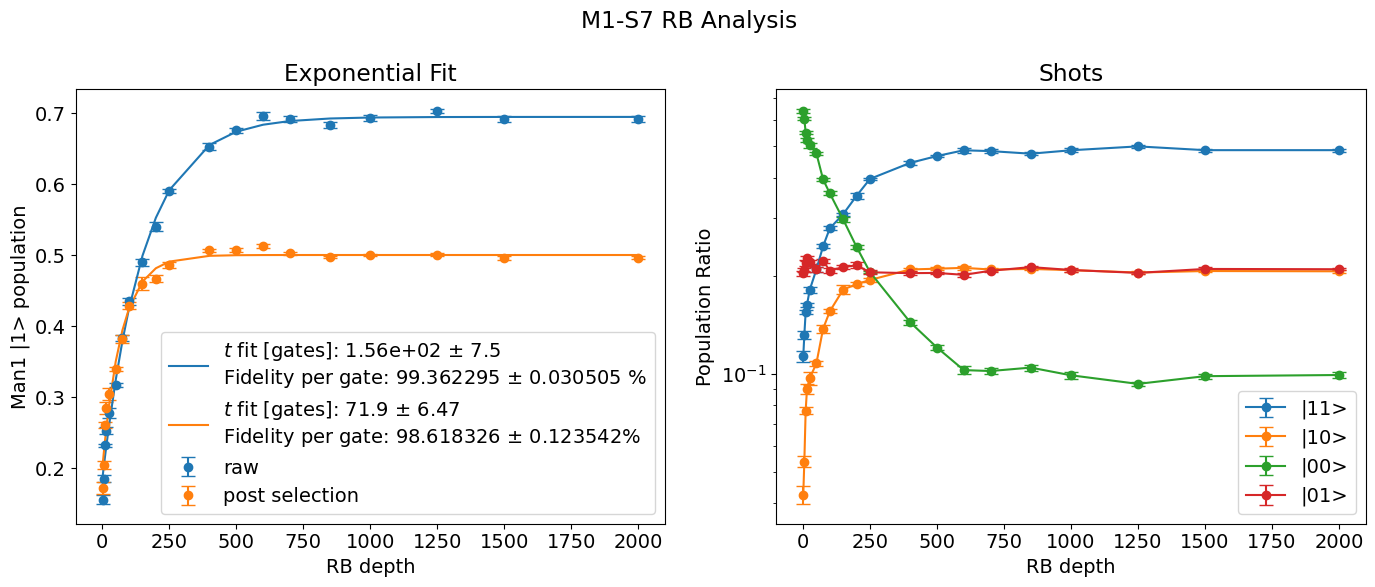

supertitle is  Text(0.5, 0.98, 'M1-S7 RB Analysis')
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-26_08-55-10_M1-S7_RB_Analysis.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-26.md
filenames: 0


TypeError: object of type 'int' has no len()

In [ ]:
from multimode_expts.fit_display_classes import MM_DualRailRBFitting
dir_no = np.arange(72, 80, 1 )
for idx, dir_no in enumerate(dir_no):
    prefix = f"SingleBeamSplitterRBPostSelection_sweep_depth"
    dir_name = f"{str(dir_no).zfill(5)}_SingleBeamSplitterRBPostSelection_sweep_depth" 
    dir_path = r"H:\\\\Shared drives\\\\SLab\\\\Multimode\\\\experiment\\\\250505_craqm\\\\data\\\\" + dir_name
    filepath = dir_path
    # Initialize RB analysis
    rb_analysis = MM_DualRailRBFitting(
        filename=None,
        file_prefix=prefix,
        config=yaml_cfg,
        expt_path=expt_path,
        title=f"M1-S{idx + 1} RB Analysis",
        prev_data=prev_data,
        dir_path=filepath
    )
    rb_analysis.show_rb(save_fig=True)



In [155]:
dir_no = 78
dir_name = f"{str(dir_no).zfill(5)}_SingleBeamSplitterRBPostSelection_sweep_depth" 
dir_path = r"H:\\\\Shared drives\\\\SLab\\\\Multimode\\\\experiment\\\\250505_craqm\\\\data\\\\" + dir_name
temp_data, attrs, filename = prev_data(dir_path, prefix='SingleBeamSplitterRBPostSelection_sweep_depth')

In [175]:
atrrs = AttrDict(attrs)
attrs['config']['device']['qubit']['f_ge']

[3569.4263053206314]

In [30]:
storage_rb

In [308]:
expt_test = Experiment(
            path=expt_path,
            prefix="yoyoyo",
            config_file=config_path,
        )

In [304]:
expt_test.data = {}
f = expt_test.save_data()

In [313]:
filename = expt_test.fname
#create a directory with the filename but no .h5 extension
import os
directory = filename
if directory.lower().endswith('.h5'):
    directory = directory[:-3]
if not os.path.exists(directory):
    # Only create the directory if it is not the same as the filename (i.e., filename is not a directory itself)
    # Make sure the directory name does not have a .h5 extension
    os.makedirs(directory)

In [319]:
directory
filename_only = os.path.basename(expt_test.fname)
filename_only

'00001_yoyoyo.h5'

In [297]:
from multimode_expts.fit_display_classes import MM_DualRailRBFitting
rb_analysis = MM_DualRailRBFitting(file_prefix = "SingleBeamSplitterRBPostSelection_sweep_depth", 
                                   config=config_thisrun, expt_path=expt_path, title='M1_S1', 
                                   prev_data= prev_data)
rb_analysis.show_rb()

KeyError: 'Idata'

In [270]:
temp_data, attrs, filename = prev_data(expt_path, '00036_SingleBeamSplitterRBPostSelection_sweep_depth.h5')

In [272]:
attrs['config'].keys()

dict_keys(['device', 'hw', 'aliases', 'data_management'])

In [262]:
temp_data.keys()

dict_keys(['Idata', 'Ie', 'Ig', 'Qdata', 'Qe', 'Qg', 'angle', 'confusion_matrix', 'depth_sweep', 'fids', 'sequences', 'thresholds'])

In [263]:
num_entries = len(temp_data['Idata'])
print(f"Number of entries in 'Idata': {num_entries}")

Number of entries in 'Idata': 3


In [264]:
temp_data['sequences']

array([[[ 6.,  4., nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [ 5.,  3., nan, nan, nan, nan, nan, nan, nan, nan, nan]],

       [[ 6.,  6.,  5.,  6.,  1.,  3., nan, nan, nan, nan, nan],
        [ 4.,  4.,  3.,  3.,  6.,  4., nan, nan, nan, nan, nan]],

       [[ 4.,  2.,  4.,  5.,  6.,  2.,  3.,  3.,  2.,  2.,  5.],
        [ 5.,  4.,  3.,  4.,  4.,  6.,  6.,  4.,  3.,  1.,  6.]]])

In [ ]:
temp_data.keys()
num_entries = len(temp_data['depth_sweep'])
print(f"Number of entries in 'depth_list': {num_entries}")
#for each entry make a mini dictionary with the i'th element of each key 
for i in range(num_entries):
    entry = {key: temp_data[key][i] for key in temp_data.keys()}
    print(f"Entry {i}: {entry}")

KeyError: 'depth_sweep'

In [221]:
temp_data.keys()

dict_keys(['Idata', 'Ie', 'Ig', 'Qdata', 'Qe', 'Qg', 'angle', 'confusion_matrix', 'depth_sweep', 'fids', 'reps_sweep', 'sequences', 'thresholds'])

In [ ]:
[[[1.0, 1.0]], [[1.0, 1.0]], [[1.0, 1.0]], [[1.0, 1.0]], [[1.0, 1.0]], [[1.0, 1.0]], [[1.0, 1.0]], [[1.0, 1.0]], [[1.0, 1.0]], [[1.0, 1.0]], [[1.0, 1.0]], [[1.0, 1.0]], [[1, 1]], [[1, 1]], [[2, 4, 3, 5, 4]]]

In [209]:
def pad_sequences_to_homogeneous( sequences):
        """
        Pads a list of list of arrays so that the last dimension of each array matches the maximum length
        at each index position across all sequences, and returns a list of lists of lists (no arrays).

        Example:
            Input: [[[0], [0], [0]], [[1,1], [1,1], [1,1]]]
            Output: [
                [[0, np.nan], [0, np.nan], [0, np.nan]],
                [[1.0, 1.0], [1.0, 1.0], [1.0, 1.0]]
            ]
        """
        if not sequences:
            return []

        num_arrays = max(len(seq) for seq in sequences)
        max_lengths = []
        for arr_idx in range(num_arrays):
            max_len = 0
            for seq in sequences:
                if arr_idx < len(seq):
                    arr = np.asarray(seq[arr_idx])
                    arr_len = arr.shape[-1]
                    if arr_len > max_len:
                        max_len = arr_len
            max_lengths.append(max_len)

        padded_sequences = []
        for seq in sequences:
            padded_seq = []
            for arr_idx in range(num_arrays):
                if arr_idx < len(seq):
                    arr = np.asarray(seq[arr_idx], dtype=float)
                    pad_width = max_lengths[arr_idx] - arr.shape[-1]
                    if pad_width > 0:
                        arr_padded = np.pad(arr, [(0, 0)] * (arr.ndim - 1) + [(0, pad_width)], mode='constant', constant_values=np.nan)
                    else:
                        arr_padded = arr
                    # Convert to list
                    arr_list = arr_padded.tolist()
                else:
                    # If this sequence is missing this array, fill with nan list
                    shape = list(np.asarray(seq[0]).shape) if seq else [1]
                    shape[-1] = max_lengths[arr_idx]
                    arr_list = np.full(shape, np.nan).tolist()
                padded_seq.append(arr_list)
            padded_sequences.append(padded_seq)
        return padded_sequences


In [212]:
listy = [[[4.0, 6.0]], [[4, 6]], [[4, 6]], [[6, 5, 4, 4, 1, 6]]]
padded_listy = pad_sequences_to_homogeneous(listy)
print(padded_listy)

[[[4.0, 6.0, nan, nan, nan, nan]], [[4.0, 6.0, nan, nan, nan, nan]], [[4.0, 6.0, nan, nan, nan, nan]], [[6.0, 5.0, 4.0, 4.0, 1.0, 6.0]]]


In [ ]:
listy =[[[4.0, 6.0]], [[4.0, 6.0]], [[4.0, 6.0]], [[4.0, 6.0]], [[4.0, 6.0]], [[4.0, 6.0]], [[4.0, 6.0]], [[4.0, 6.0]], [[4.0, 6.0]], [[4.0, 6.0]], [[4.0, 6.0]], [[4.0, 6.0]]]

# Update Config and Dataset

In [49]:
def convert_attrdict_to_dict(attrdict):
    """
    Recursively converts an AttrDict or a nested dictionary into a standard Python dictionary.
    Converts np.float64 values to standard Python float.

    Args:
        attrdict (AttrDict or dict): The input AttrDict or dictionary to be converted.

    Returns:
        dict: A standard Python dictionary with all nested AttrDicts or dictionaries converted.
    """
    if isinstance(attrdict, AttrDict):
        return {key: convert_attrdict_to_dict(value) for key, value in attrdict.items()}
    elif isinstance(attrdict, dict):
        return {key: convert_attrdict_to_dict(value) for key, value in attrdict.items()}
    elif isinstance(attrdict, np.float64):
        return float(attrdict)
    else:
        return attrdict


def convert_numbers_to_float(data):
    """
    Recursively converts all numbers in a dictionary to float.

    Args:
        data (dict): The input dictionary.

    Returns:
        dict: A dictionary with all numbers converted to float.
    """
    if isinstance(data, dict):
        return {key: convert_numbers_to_float(value) for key, value in data.items()}
    elif isinstance(data, list):
        return [convert_numbers_to_float(item) for item in data]
    elif isinstance(data, float):
        return float(data)
    elif isinstance(data, int):
        return int(data)
    else:
        return data

## Dataset

In [50]:
#compare the two datsets
differences = ds_thisrun.compare_with(ds)
# Filter out differences related to 'last_update' column
filtered_differences = [diff for diff in differences if diff['column'] != 'last_update']
# Update labels and calculate differences
for diff in filtered_differences:
    diff['label'] = f"New value: {diff['self_value']}, Old value: {diff['other_value']}"
    diff['difference'] = diff['self_value'] - diff['other_value'] if isinstance(diff['self_value'], (int, float)) and isinstance(diff['other_value'], (int, float)) else None

# Group differences by storage name
grouped_differences = {}
for diff in filtered_differences:
    stor_name = diff['stor_name']
    if stor_name not in grouped_differences:
        grouped_differences[stor_name] = []
    grouped_differences[stor_name].append(diff)

# Print grouped differences
for stor_name, diffs in grouped_differences.items():
    print(f"In {stor_name}:")
    for diff in diffs:
        print(f"  Column '{diff['column']}': new_value = {diff['self_value']}, old_value = {diff['other_value']}, difference = {diff['difference']}")
    grouped_differences[stor_name].append(diff)


In M1-S1:
  Column 'precision (MHz)': new_value = nan, old_value = nan, difference = nan
In M1-S2:
  Column 'precision (MHz)': new_value = nan, old_value = nan, difference = nan
In M1-S3:
  Column 'precision (MHz)': new_value = nan, old_value = nan, difference = nan
In M1-S4:
  Column 'precision (MHz)': new_value = nan, old_value = nan, difference = nan
In M1-S5:
  Column 'precision (MHz)': new_value = nan, old_value = nan, difference = nan
In M1-S6:
  Column 'precision (MHz)': new_value = nan, old_value = nan, difference = nan
In M1-S7:
  Column 'precision (MHz)': new_value = nan, old_value = nan, difference = nan
In M1:
  Column 'precision (MHz)': new_value = nan, old_value = nan, difference = nan


In [208]:
ds_thisrun.df

stor_name  freq (MHz)  precision (MHz)   pi (mus)  h_pi (mus)  \
0      M1-S1     349.110              NaN   0.813627    0.360513   
1      M1-S2     520.610              NaN   0.165878    0.080903   
2      M1-S3     696.350              NaN   1.122884    0.512333   
3      M1-S4     875.285              NaN   1.068157    0.488362   
4      M1-S5    1053.040              NaN   1.744303    0.833387   
5      M1-S6    1244.860              NaN   1.388454    0.652345   
6      M1-S7    1422.660              NaN   1.993553    0.948300   
7      M1-S8      -1.000            -1.00  -1.000000   -1.000000   
8      M1-S9      -1.000            -1.00  -1.000000   -1.000000   
9     M1-S10      -1.000            -1.00  -1.000000   -1.000000   
10    M1-S11      -1.000            -1.00  -1.000000   -1.000000   
11    M1-S12      -1.000            -1.00  -1.000000   -1.000000   
12        M1    2008.975              NaN   0.630303    0.310483   
13        M2    1834.950             0.01   1.054456    0.520515   
14     M2-S1     175.630             0.01   2.173484    1.086742   
15     M2-S2     346.840             0.01   0.908835    0.454417   
16     M2-S3     523.220             0.01   1.561615    0.780808   
17     M2-S4     702.650             0.01   1.386764    0.693382   
18     M2-S5     878.780             0.01   1.303372    0.651686   
19     M2-S6    1070.100             0.01   2.379622    1.189811   
20     M2-S7    1249.700             0.01   1.796981    0.898491   
21     M2-M1     173.790             0.01   0.463481    0.231741   
22     M1-D1    2313.440             0.01  10.000000    0.000000   
23     M2-D2    2094.050             0.01  15.000000    0.000000   
24      M1-C     973.230             0.02   0.251127    0.122354   
25     M1_ce    2008.780             0.02   0.617915    0.304523   

    gain (DAC units)                 last_update  
0               3000  2025-05-22 16:05:21.623488  
1               5000  2025-05-22 15:50:43.604290  
2               9000  2025-05-22 15:50:34.895075  
3               9000  2025-05-22 15:54:56.582975  
4               7500  2025-05-22 15:55:49.320754  
5              13500  2025-05-22 15:56:51.940958  
6              10000  2025-05-22 15:57:38.027389  
7                 -1                     51:31.3  
8                 -1                     51:31.3  
9                 -1                     51:31.3  
10                -1                     51:31.3  
11                -1                     51:31.3  
12             15000  2025-05-22 11:41:48.460289  
13             15000  2025-04-30 11:22:11.432806  
14              1000                     28:20.8  
15              5000                     33:56.1  
16              5000                     22:30.3  
17              9000                     25:33.1  
18             13500                     00:05.4  
19              9000                     30:59.0  
20             12000                     56:07.5  
21              2000  2024-10-06 01:47:25.946153  
22              5000  2025-01-23 14:54:56.384507  
23              8000  2025-01-23 17:22:53.776061  
24              1000  2025-01-20 09:34:00.029234  
25             15000  2025-01-20 09:52:35.311227

In [192]:
# stor new datset at old file path
updateDataset = True
if updateDataset:
    # store old dataset  into autocalib_path with date-time in the name
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    old_dataset_path = os.path.join(autocalib_path, f'old_dataset_{current_time}.h5')
    ds_thisrun.save_to_file(old_dataset_path)
    print('Old dataset saved to:', old_dataset_path)

    #save new dataset to curreent_dataset path
    ds_thisrun.save_to_file(ds.filename)
    # ds = copy(ds_thisrun)
    print('New dataset saved to old file path!')

Old dataset saved to: H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\autocalibration_plots_2025-05-23\old_dataset_2025-05-23_13-52-07.h5
New dataset saved to old file path!


## Config

In [174]:
from pprint import pprint
print("Comparing configurations:")

def recursive_compare(d1, d2, path=""):
    for key in d1.keys():
        current_path = f"{path}.{key}" if path else key
        if key not in d2:
            print(f"Key '{current_path}' is missing in config2.")
        elif isinstance(d1[key], dict) and isinstance(d2[key], dict):
            recursive_compare(d1[key], d2[key], current_path)
        elif d1[key] != d2[key]:
            print(f"Key '{current_path}' differs:")
            if isinstance(d1[key], list) and len(d1[key]) == 1:
                print(f"  Old value (config1): {d1[key][0]}")
                print(f"  New value (config2): {d2[key][0]}")
            else:
                print(f"  Old value (config1): {d1[key]}")
                print(f"  New value (config2): {d2[key]}")
    for key in d2.keys():
        current_path = f"{path}.{key}" if path else key
        if key not in d1:
            print(f"Key '{current_path}' is missing in config1.")

recursive_compare(yaml_cfg, config_thisrun)

Comparing configurations:
Key 'device.qubit.f_ge' differs:
  Old value (config1): 3569.4263053206314
  New value (config2): 3569.268703246875
Key 'device.readout.phase' differs:
  Old value (config1): 0.8473846167680859
  New value (config2): 173.61636552679084
Key 'device.readout.threshold' differs:
  Old value (config1): -148.02027429647023
  New value (config2): -144.0901885932094
Key 'device.readout.threshold_list' differs:
  Old value (config1): [-148.02027429647023]
  New value (config2): [-144.0901885932094]
Key 'device.readout.confusion_matrix_without_reset' differs:
  Old value (config1): [0.9880000000000001, 0.0119999999999999, 0.025599999999999998, 0.9744]
  New value (config2): [0.9874, 0.012599999999999945, 0.0256, 0.9744]
Key 'device.readout.Ie' differs:
  Old value (config1): 13.759785764449656
  New value (config2): 17.01795584435721
Key 'device.readout.Ig' differs:
  Old value (config1): -292.02027429647035
  New value (config2): -288.0901885932093
Key 'device.storage.

In [ ]:
# Copy contents from config_thisrun to yaml_cfg except for the storage_man_file
def update_yaml_config(yaml_cfg, config_thisrun):
    """
    Update the yaml_cfg with values from config_thisrun, excluding the storage_man_file.
    """
    updated_config = deepcopy(config_thisrun)
    updated_config.device.storage.storage_man_file = yaml_cfg.device.storage.storage_man_file
    return updated_config

def save_configurations(yaml_cfg, config_thisrun, autocalib_path, config_path):
    """
    Save the old and updated configurations to their respective files.
    """
    # Save old configuration
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    old_config_path = os.path.join(autocalib_path, f'old_config_{current_time}.yaml')
    old_config = convert_numbers_to_float(convert_attrdict_to_dict(yaml_cfg) )
    with open(old_config_path, 'w') as cfg_file:
        yaml.dump(old_config, cfg_file, default_flow_style=False, indent=4, width=80, canonical=False,
                  explicit_start=True, explicit_end=False, sort_keys=False, line_break=True)

    # Save updated configuration
    updated_config = convert_numbers_to_float(convert_attrdict_to_dict(update_yaml_config(yaml_cfg, config_thisrun)))
    with open(config_path, 'w') as f:
        yaml.dump(updated_config, f, default_flow_style=False, indent=4, width=80, canonical=False,
                  explicit_start=True, explicit_end=False, sort_keys=False, line_break=True)

# Main logic
updateConfig_bool = False# Set to FALSE after this run!!!!!!
updated_config = update_yaml_config(yaml_cfg, config_thisrun)
if updateConfig_bool:
    save_configurations(yaml_cfg, updated_config, autocalib_path, config_path)
    yaml_cfg = updated_config
    updateConfig_bool = False
    print("Configuration updated and saved, excluding storage_man_file. \n!!!!Please set updateConfig to False after this run!!!!!!.")

Configuration updated and saved, excluding storage_man_file. 
!!!!Please set updateConfig to False after this run!!!!!!.
